## Setup

In [1]:
import pandas as pd
import torch
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch import nn, optim
from torch.utils.data import TensorDataset
from torcheval.metrics import functional as funcmetrics

from common import *

In [2]:
torch.manual_seed(2024)
torch.use_deterministic_algorithms(True)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU()
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU()
        )
        self.out = nn.Linear(hidden_dims[1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out(x)
        return x

In [4]:
data = pd.read_csv('datasets/banana_quality.csv')

X = data.drop('Quality', axis=1)
y = data['Quality']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [5]:
banana_scaler = StandardScaler()
banana_dataset = TensorDataset(
    torch.tensor(banana_scaler.fit_transform(X), dtype=torch.float),
    torch.tensor(y, dtype=torch.long).flatten()
)

banana_datasets = shuffle_train_valid_test_split(banana_dataset)
banana_headers: list =  X.keys().to_list()

In [6]:
def optimizer_factory(model):
    return optim.Adam(model.parameters(), lr=0.001)

criterion = nn.CrossEntropyLoss()

In [7]:
labels = ("accuracy", "f1-score")


def score_outputs(outputs, targets):
    return (
        funcmetrics.multiclass_accuracy(
            outputs, targets, average='macro', num_classes=2).item(),
        funcmetrics.multiclass_f1_score(
            outputs, targets, average='macro', num_classes=2).item(),
    )

## Base model

/home/szynka/Projects/Studia/xai/.venv/lib64/python3.12/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:232.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


test: ('accuracy', 'f1-score'): (0.9779185056686401, 0.9779158234596252)


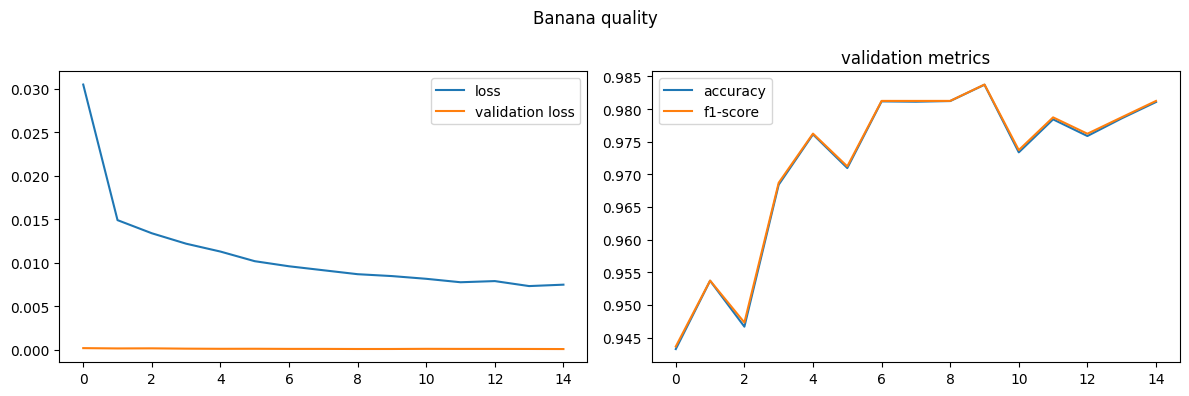

In [8]:
datasets = banana_datasets

model = MLP(len(banana_headers), (32, 32), 2)
optimizer = optimizer_factory(model)

metrics = model_train(datasets, model, optimizer, criterion, score_outputs, 15)


with torch.no_grad():
    inputs, targets = datasets["test"][:]
    outputs = model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test: {labels}: {test_metrics}")
plot_metrics('Banana quality', metrics, labels)

## DGSM

In [9]:
best_model = MLP(len(banana_headers), (32, 32), 2)

### input layer

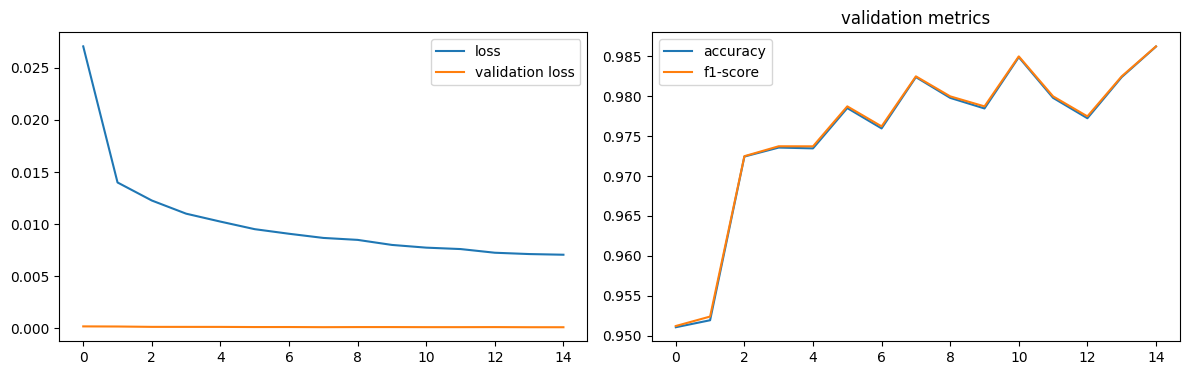

Test: loss: 0.07832299917936325, avg metrics: (0.9769900918006897, 0.9769983291625977)
dropping feature: (0, 'Size')


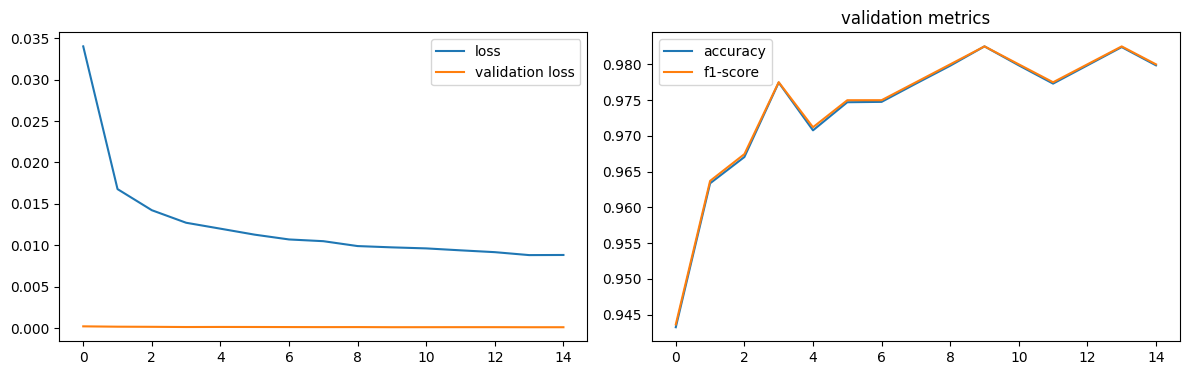

Test: loss: 0.09034319967031479, avg metrics: (0.9734438180923461, 0.9734152674674987)
dropping feature: (4, 'Ripeness')


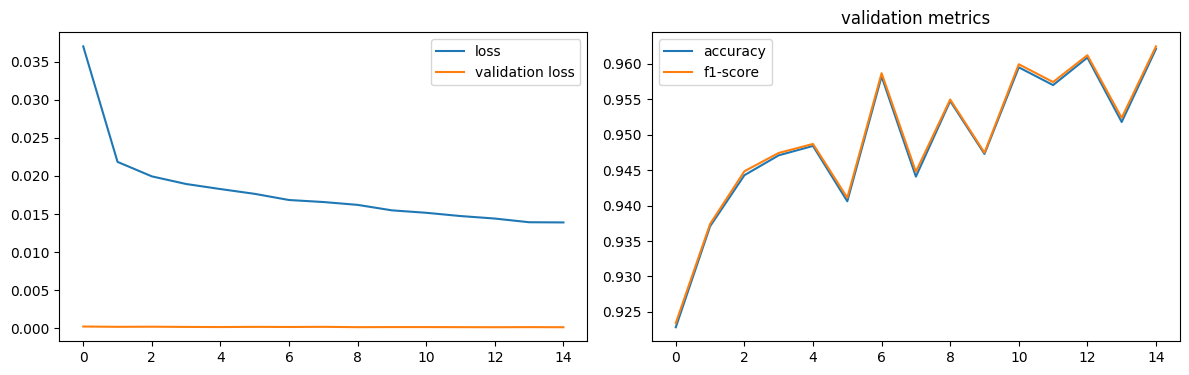

Test: loss: 0.12871383130550385, avg metrics: (0.9515839576721191, 0.951577115058899)
dropping feature: (1, 'Sweetness')


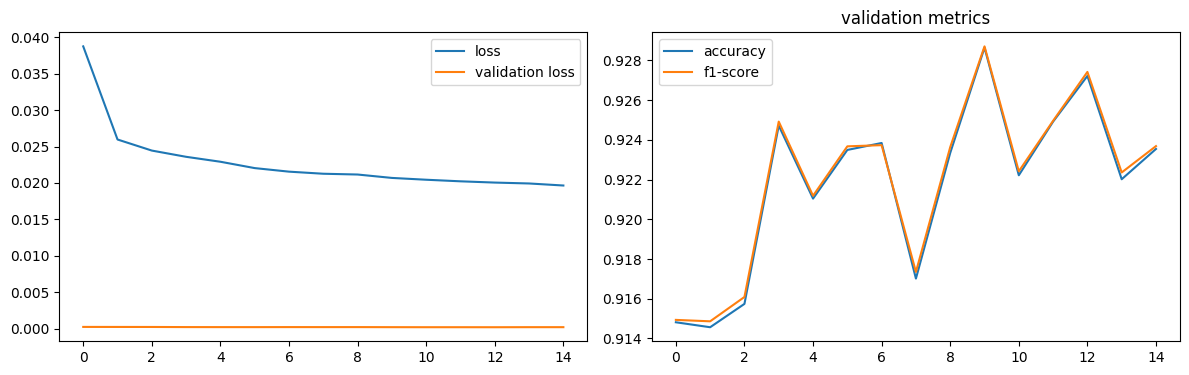

Test: loss: 0.1655687391757965, avg metrics: (0.9350787758827209, 0.9350754141807556)
dropping feature: (2, 'HarvestTime')


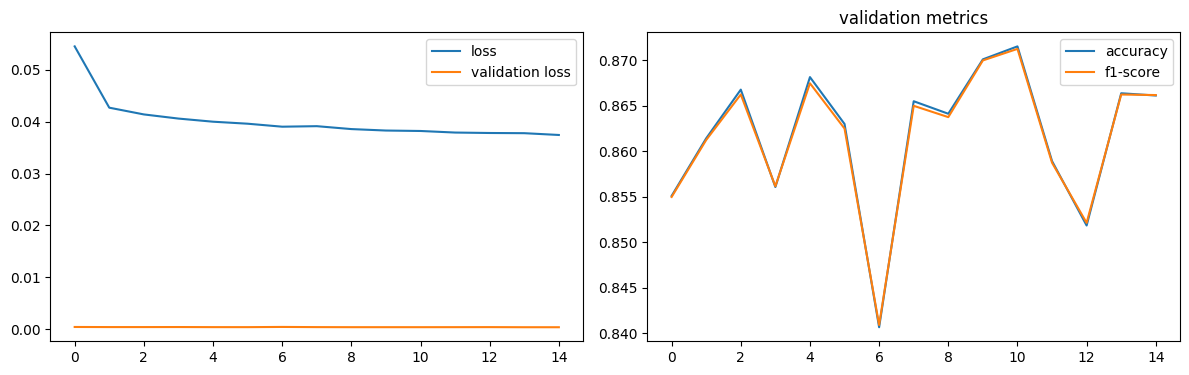

Test: loss: 0.3067600131034851, avg metrics: (0.8730760216712952, 0.8730748772621155)
dropping feature: (0, 'Weight')


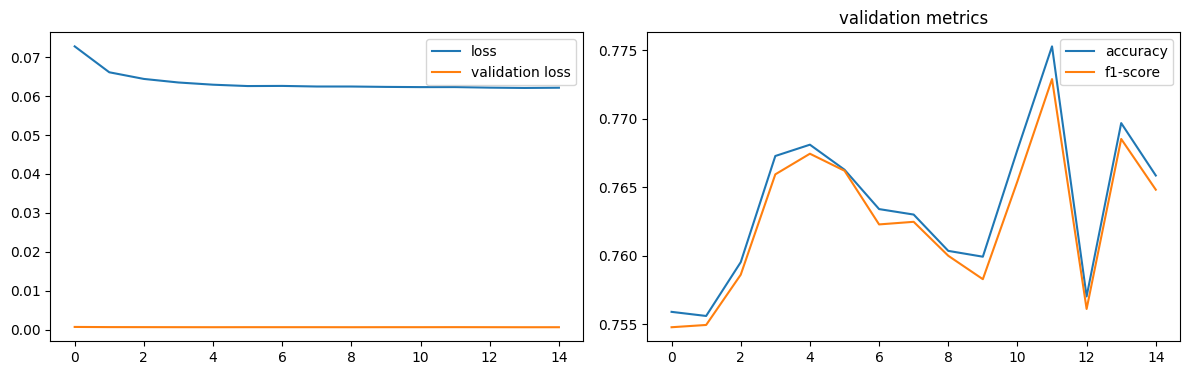

Test: loss: 0.4919204115867615, avg metrics: (0.7607537984848023, 0.7601808667182922)
dropping feature: (1, 'Acidity')


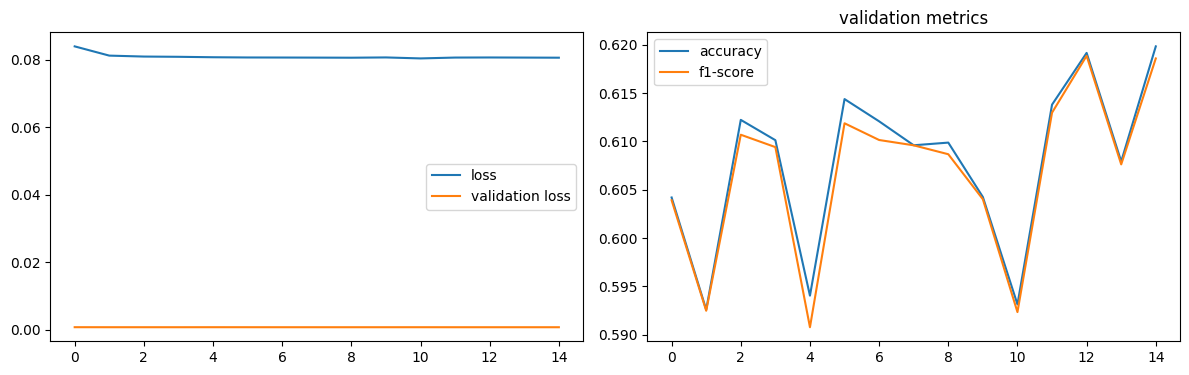

Test: loss: 0.6505280137062073, avg metrics: (0.6106171369552612, 0.6090312123298645)


In [10]:
torch.manual_seed(2024)

datasets = banana_datasets.copy()
headers = banana_headers.copy()


def model_factory(size):
    return MLP(size, (32, 32), 2)


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 15,
    labels, "", None
)

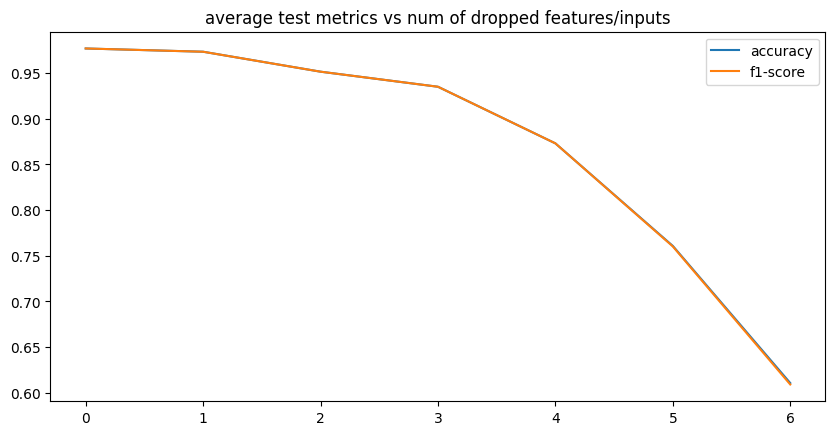

In [11]:
plot_dropping_metrics(test_metrics, labels)

In [12]:
num_drop_features = 1

save_models("banana", "layer1", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_features)
layer = models[num_drop_features].layer1

best_model.layer1 = layer

dgsm_datasets = reduced_datasets

features left [6]:  ['Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness', 'Acidity']


### 1st hidden layer

In [13]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

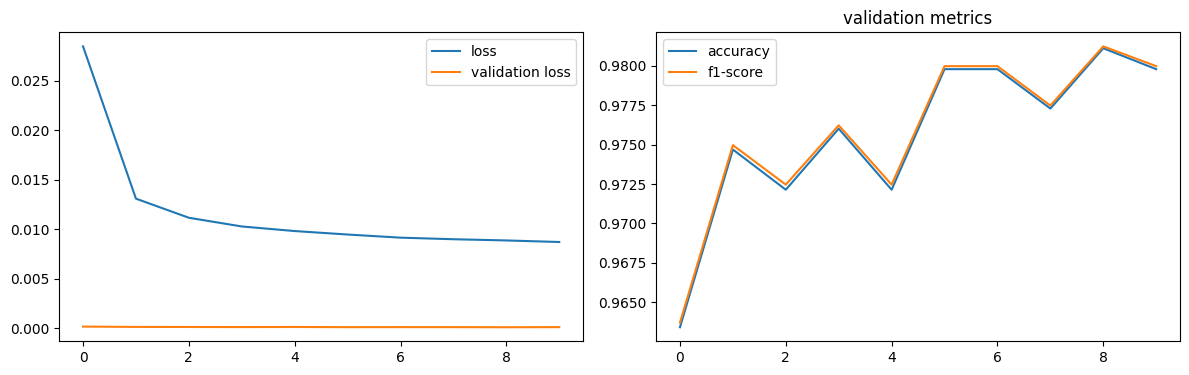

Test: loss: 0.09280698746442795, avg metrics: (0.9735021710395813, 0.9734986662864685)
dropping feature: (18, 'neuron18')


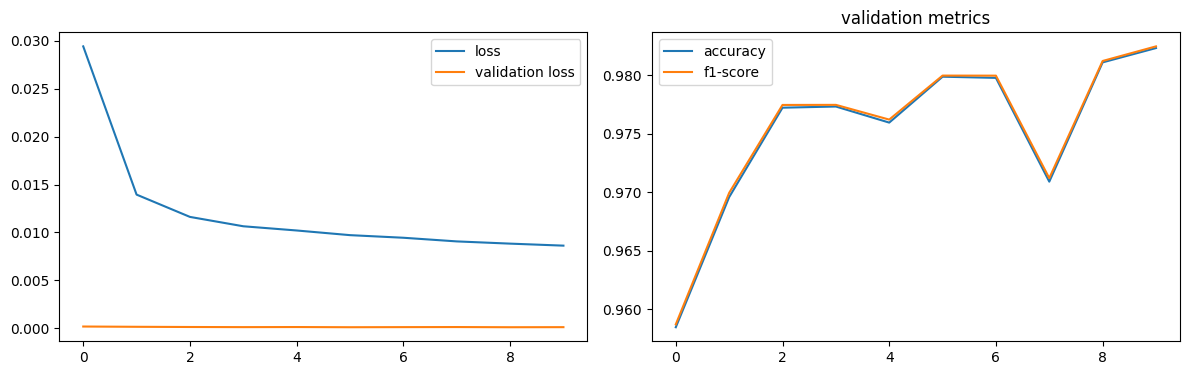

Test: loss: 0.09370016306638718, avg metrics: (0.9730187892913819, 0.9729985952377319)
dropping feature: (16, 'neuron16')


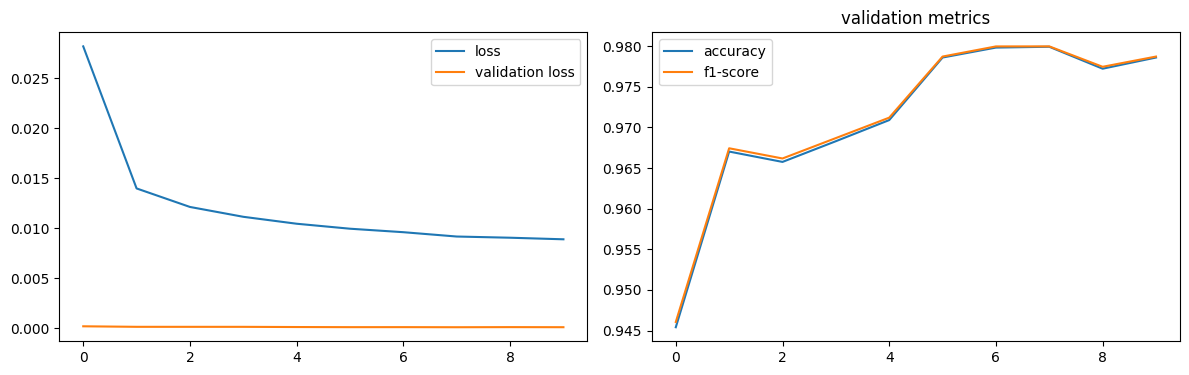

Test: loss: 0.0932055339217186, avg metrics: (0.9739027142524719, 0.9739143967628479)
dropping feature: (29, 'neuron31')


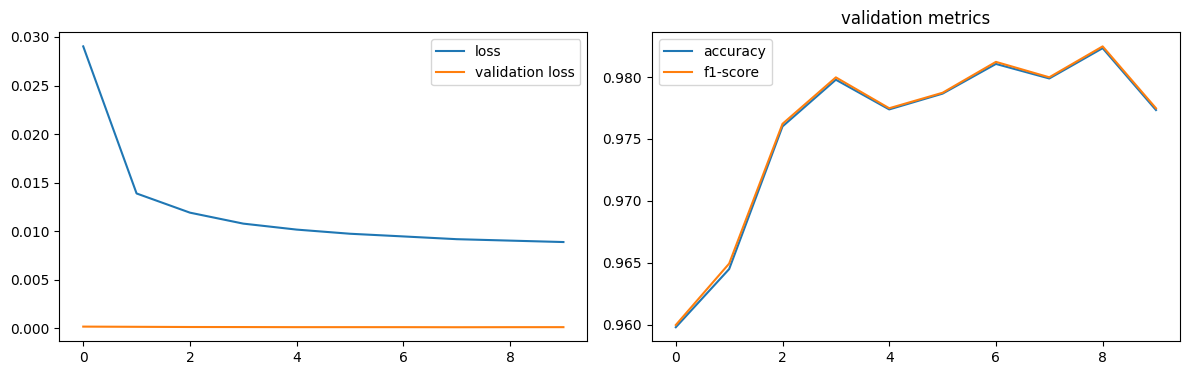

Test: loss: 0.09711409360170364, avg metrics: (0.972150981426239, 0.9721630096435547)
dropping feature: (16, 'neuron17')


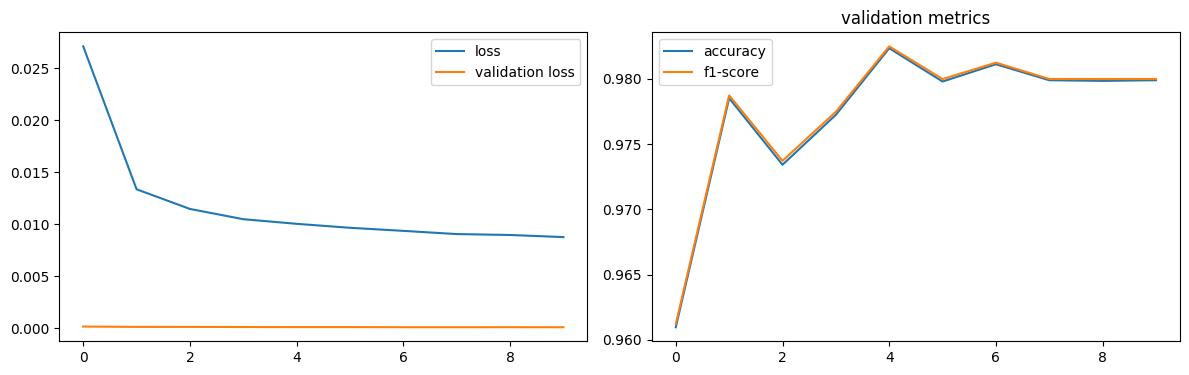

Test: loss: 0.09070448577404022, avg metrics: (0.9721965551376343, 0.9721657395362854)
dropping feature: (21, 'neuron24')


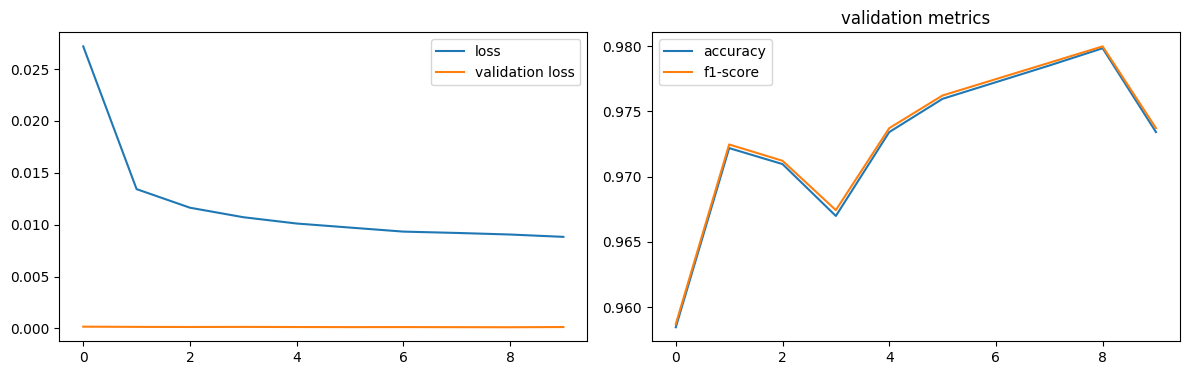

Test: loss: 0.10028042644262314, avg metrics: (0.9722371101379395, 0.9722467303276062)
dropping feature: (4, 'neuron4')


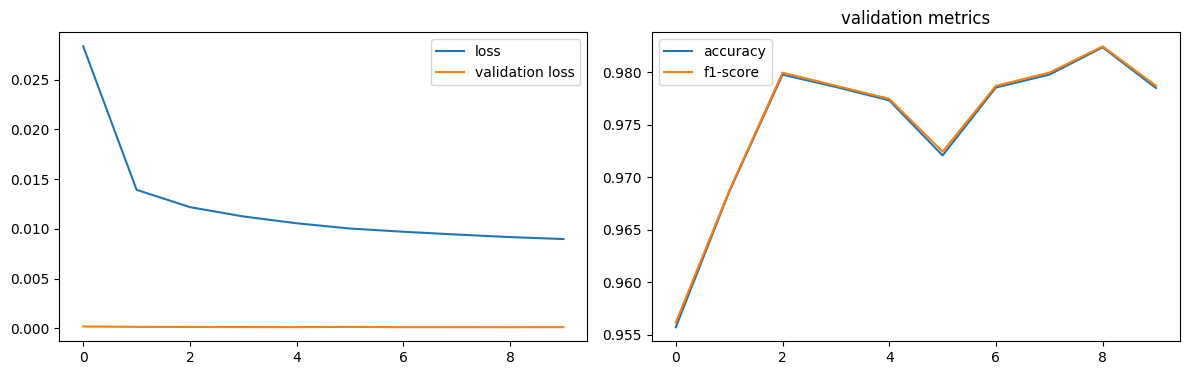

Test: loss: 0.0962391123175621, avg metrics: (0.9733132481575012, 0.9733304500579834)
dropping feature: (4, 'neuron5')


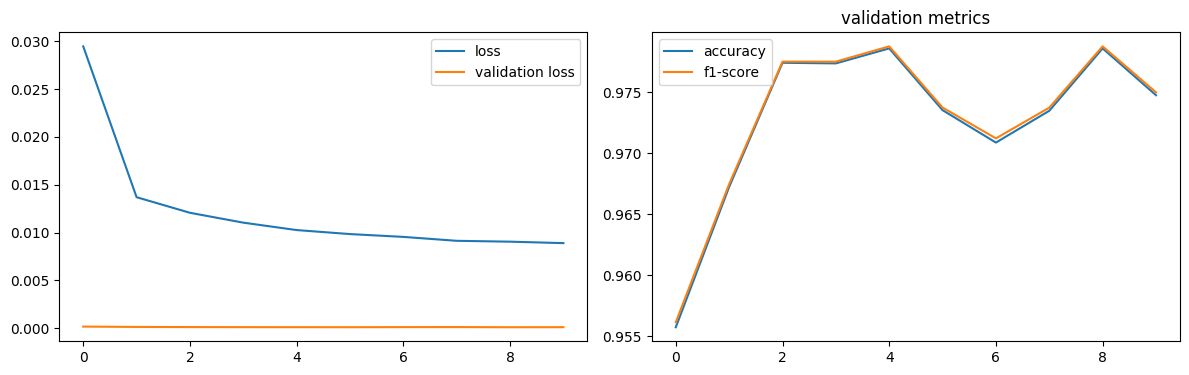

Test: loss: 0.09456251561641693, avg metrics: (0.9725109934806824, 0.9724993705749512)
dropping feature: (16, 'neuron21')


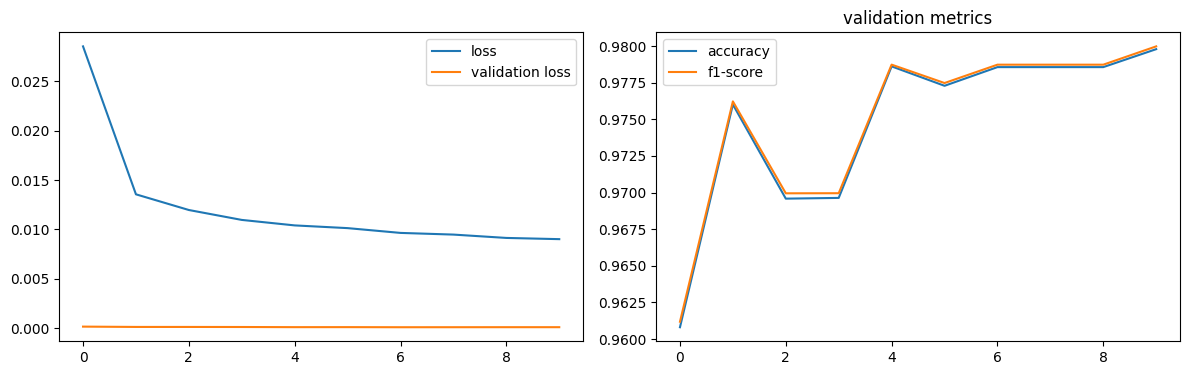

Test: loss: 0.09760528802871704, avg metrics: (0.9719026446342468, 0.9719144344329834)
dropping feature: (7, 'neuron9')


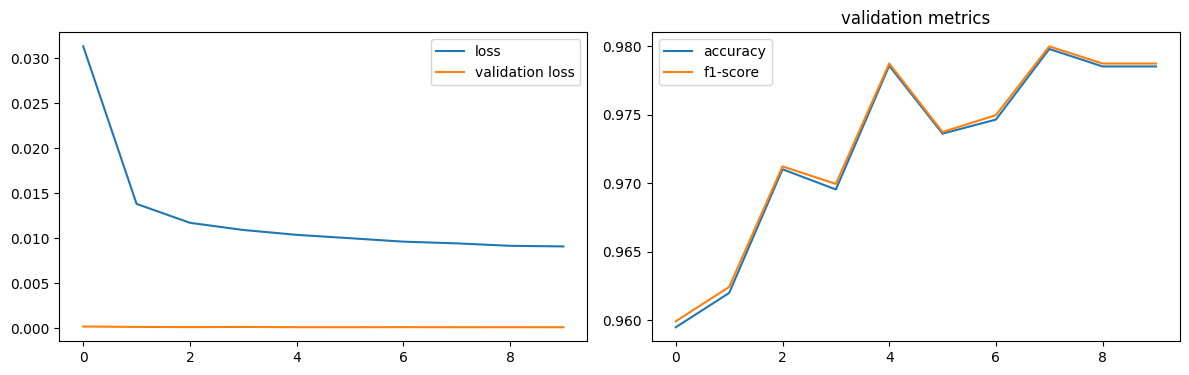

Test: loss: 0.09744442254304886, avg metrics: (0.9718298554420471, 0.9718311309814454)
dropping feature: (6, 'neuron8')


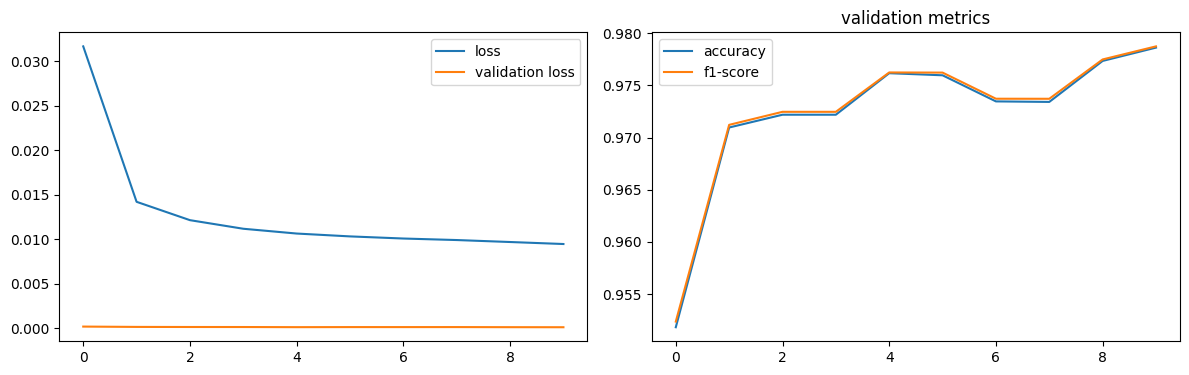

Test: loss: 0.10052767395973206, avg metrics: (0.9711464881896973, 0.9711630463600158)
dropping feature: (6, 'neuron10')


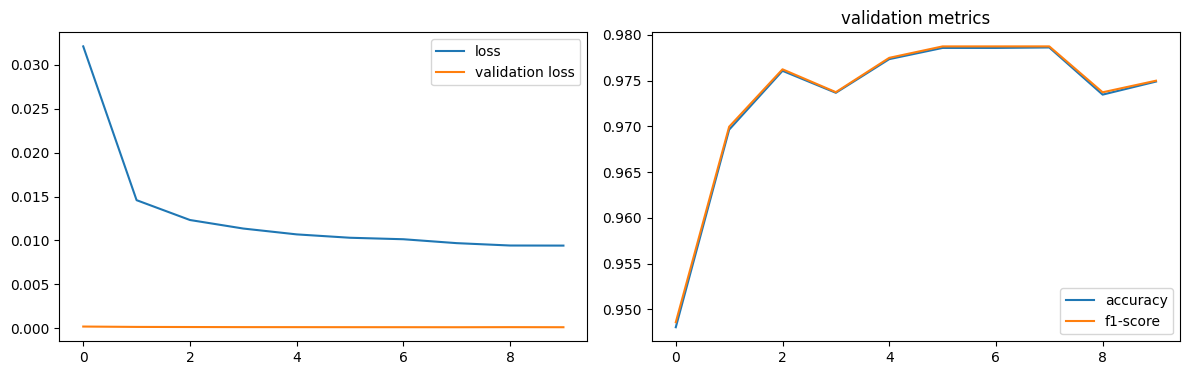

Test: loss: 0.10145267844200134, avg metrics: (0.9717615246772766, 0.971749234199524)
dropping feature: (8, 'neuron13')


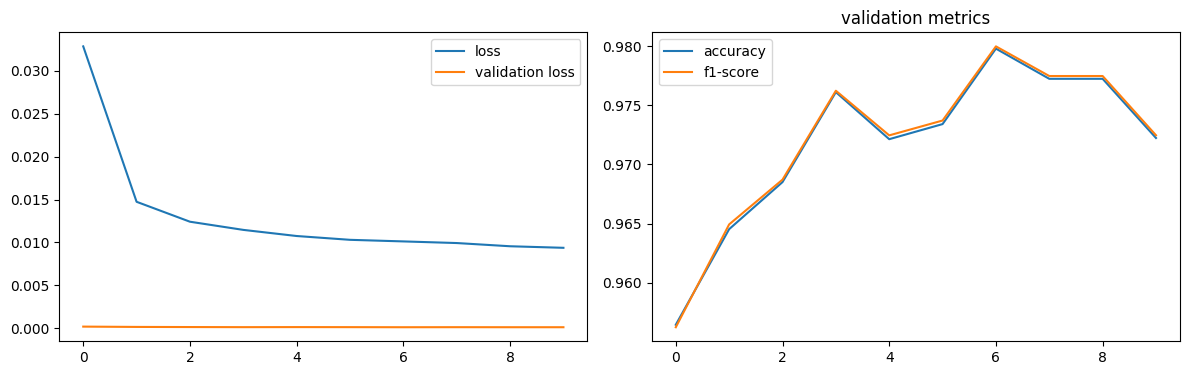

Test: loss: 0.10066891461610794, avg metrics: (0.9725748777389527, 0.972581148147583)
dropping feature: (3, 'neuron3')


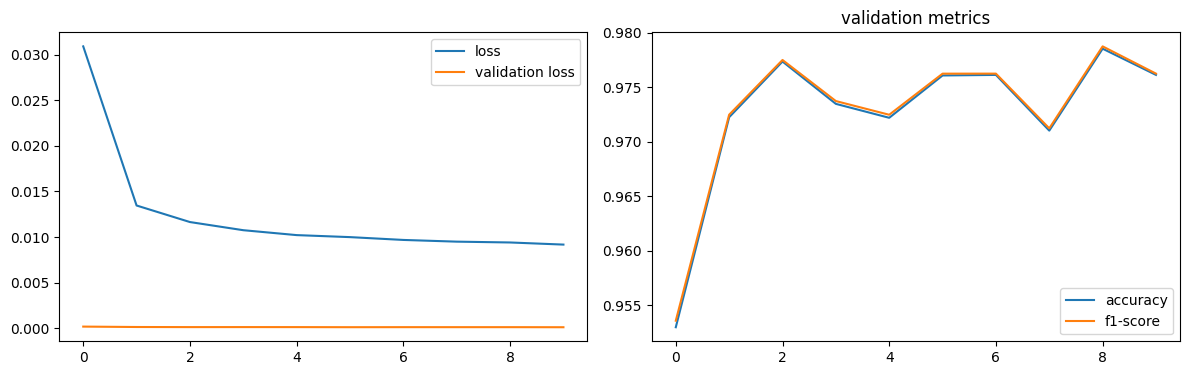

Test: loss: 0.0944984033703804, avg metrics: (0.9717359423637391, 0.9717469692230225)
dropping feature: (2, 'neuron2')


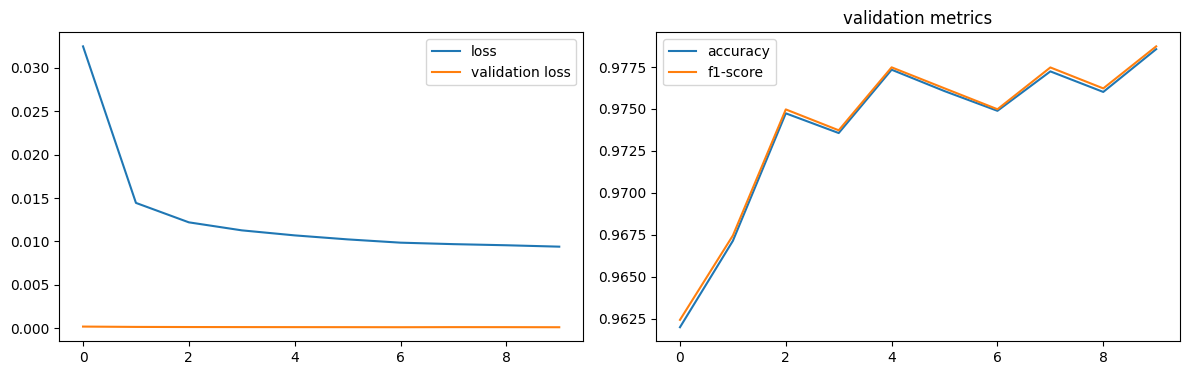

Test: loss: 0.09666101634502411, avg metrics: (0.9709126234054566, 0.9709124088287353)
dropping feature: (16, 'neuron29')


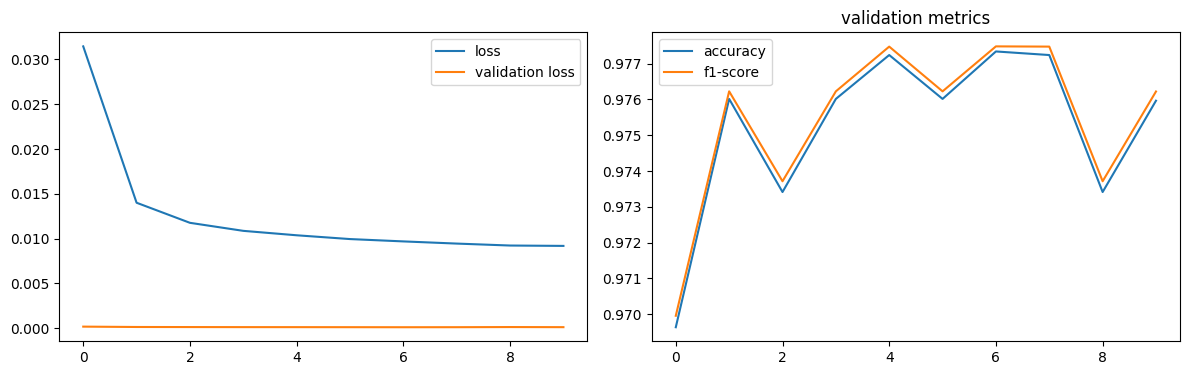

Test: loss: 0.09780864417552948, avg metrics: (0.9715637326240539, 0.9715804696083069)
dropping feature: (15, 'neuron28')


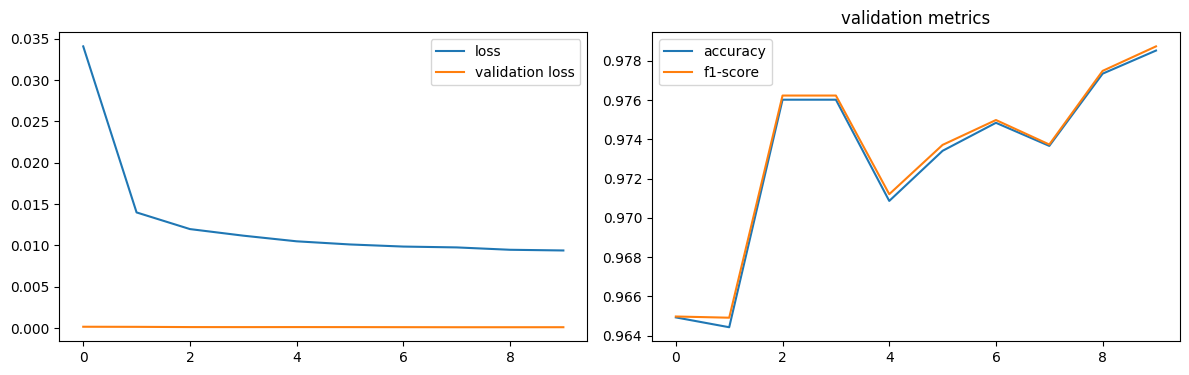

Test: loss: 0.09473416954278946, avg metrics: (0.9719326257705688, 0.9719156265258789)
dropping feature: (12, 'neuron25')


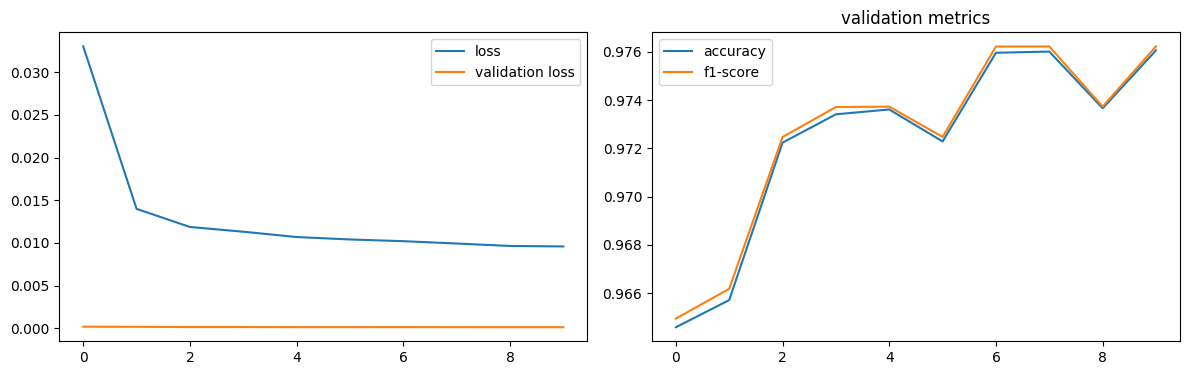

Test: loss: 0.09972837567329407, avg metrics: (0.9708342552185059, 0.9708320617675781)
dropping feature: (6, 'neuron14')


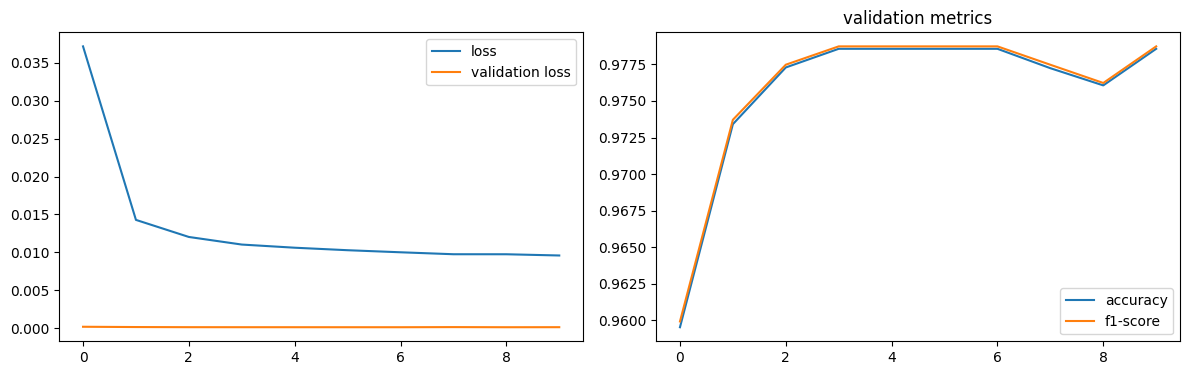

Test: loss: 0.10295475274324417, avg metrics: (0.9711931586265564, 0.9711661458015441)
dropping feature: (12, 'neuron27')


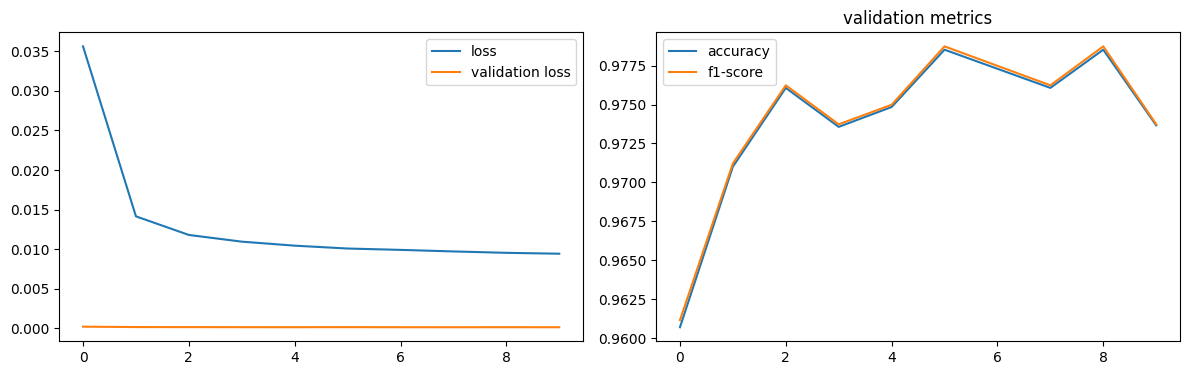

Test: loss: 0.10119657218456268, avg metrics: (0.9706653356552124, 0.9706648707389831)
dropping feature: (6, 'neuron15')


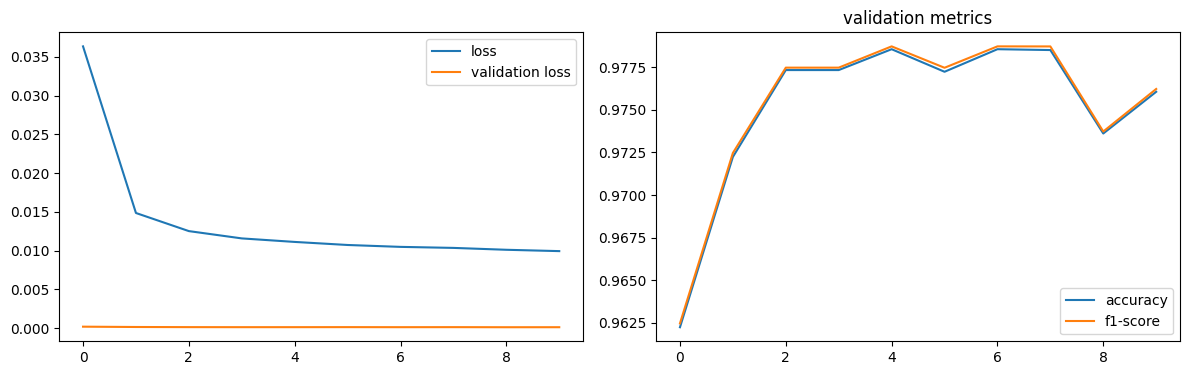

Test: loss: 0.10337447375059128, avg metrics: (0.9695736527442932, 0.969580864906311)
dropping feature: (4, 'neuron11')


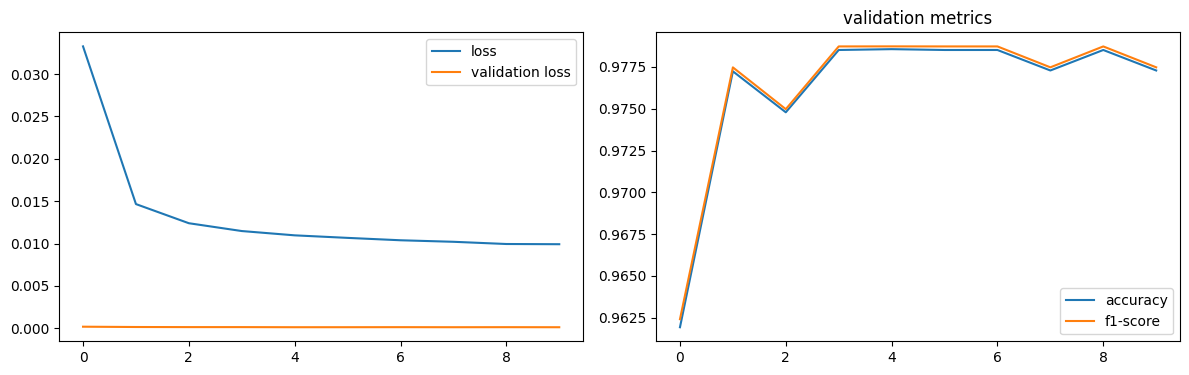

Test: loss: 0.10288696736097336, avg metrics: (0.9684191584587097, 0.9684147357940673)
dropping feature: (10, 'neuron30')


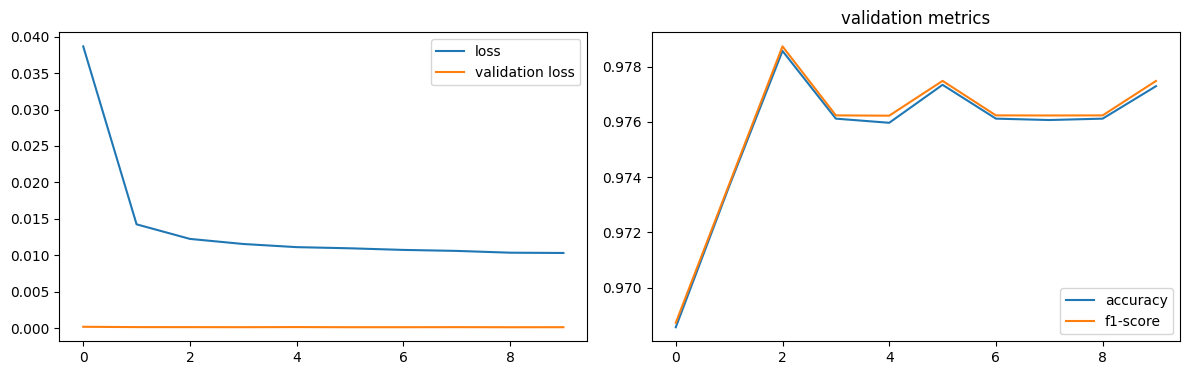

Test: loss: 0.10725545138120651, avg metrics: (0.9680657982826233, 0.9680804252624512)
dropping feature: (6, 'neuron20')


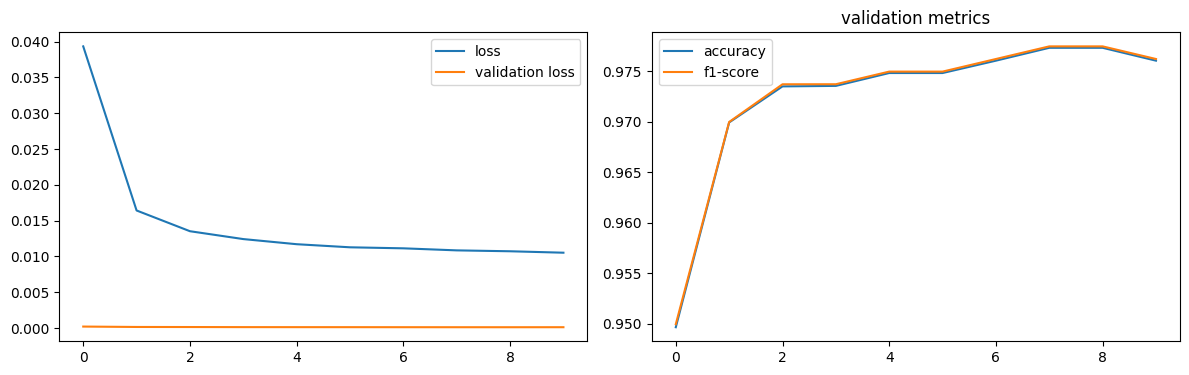

Test: loss: 0.10505466163158417, avg metrics: (0.9677491188049316, 0.9677481532096863)
dropping feature: (4, 'neuron12')


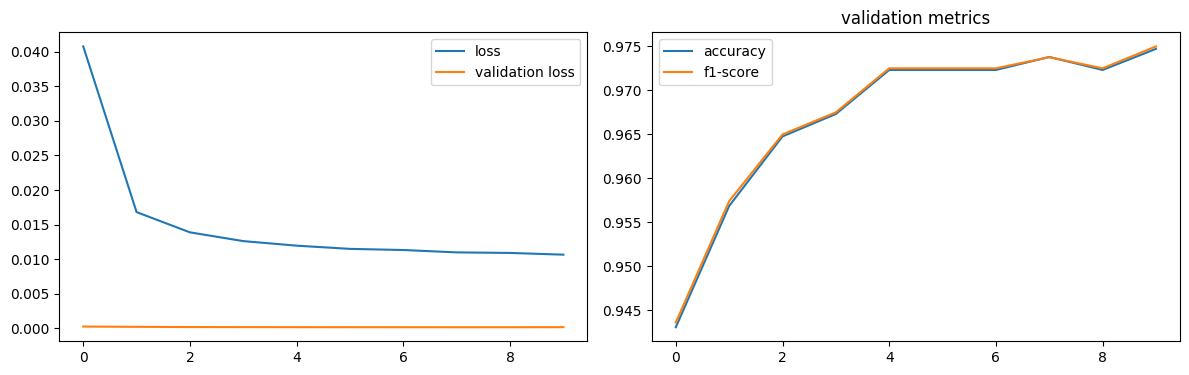

Test: loss: 0.11183517426252365, avg metrics: (0.9666751861572266, 0.9666653275489807)
dropping feature: (5, 'neuron22')


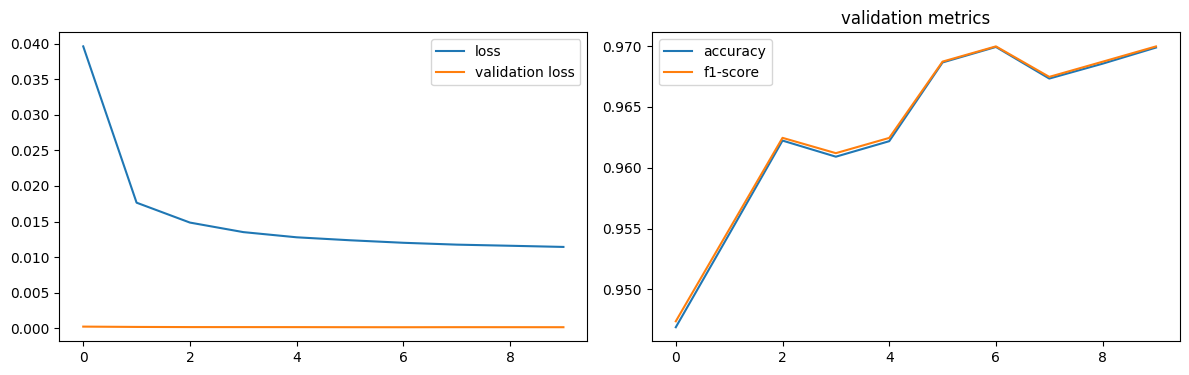

Test: loss: 0.11293909698724747, avg metrics: (0.96383615732193, 0.9638316631317139)
dropping feature: (2, 'neuron6')


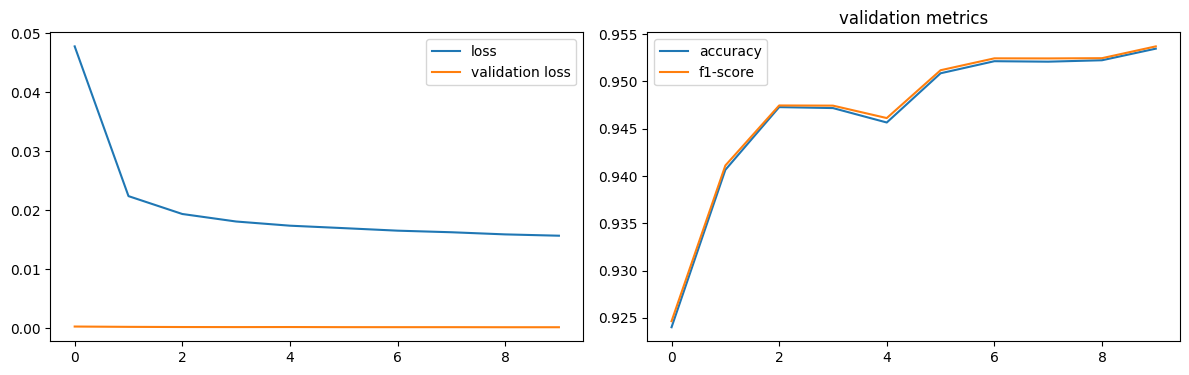

Test: loss: 0.14419125020503998, avg metrics: (0.9528323292732239, 0.9528299331665039)
dropping feature: (1, 'neuron1')


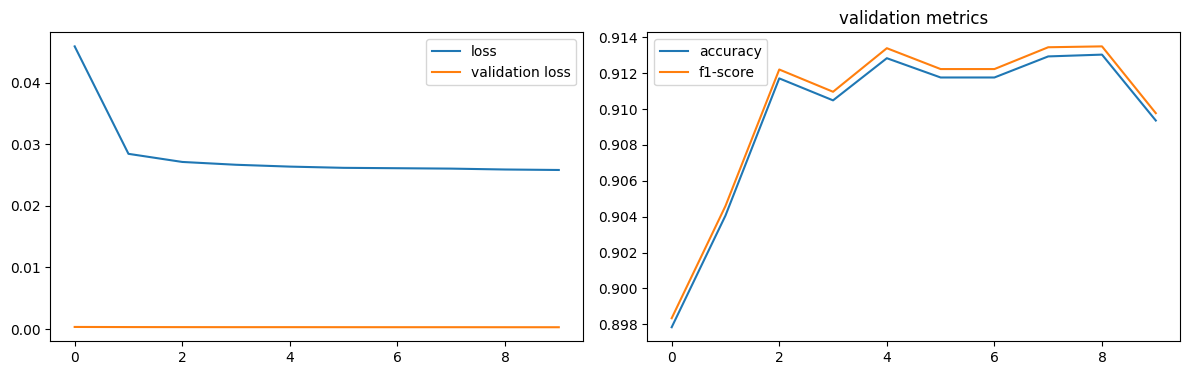

Test: loss: 0.22694379091262817, avg metrics: (0.9090803861618042, 0.9091524839401245)
dropping feature: (2, 'neuron19')


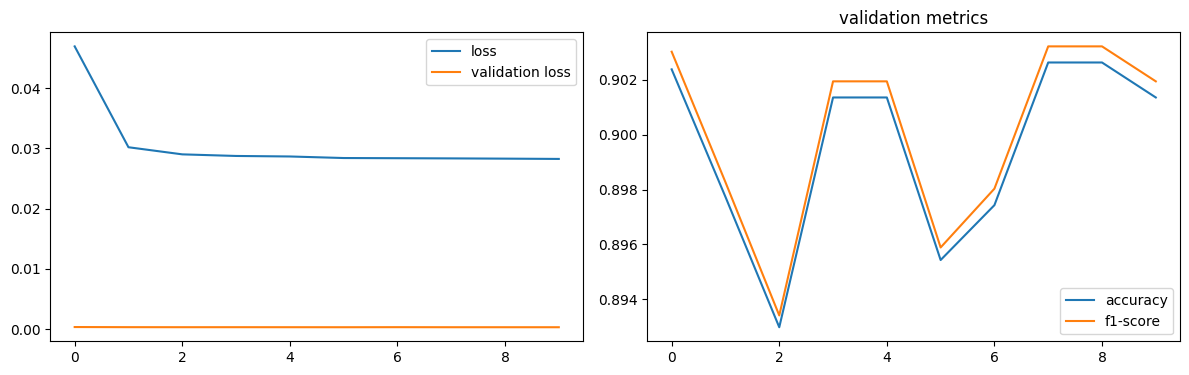

Test: loss: 0.24177433550357819, avg metrics: (0.9030362367630005, 0.9031039595603942)
dropping feature: (3, 'neuron26')


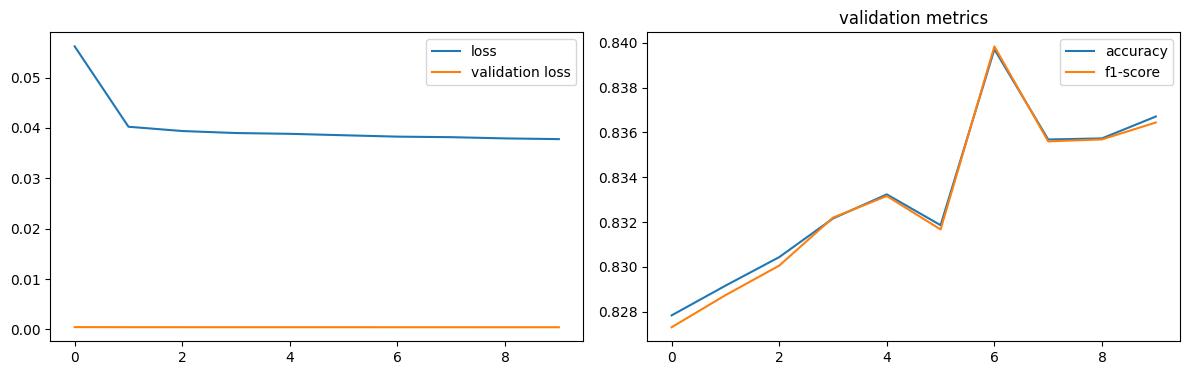

Test: loss: 0.32209065556526184, avg metrics: (0.8541518688201905, 0.8538558006286621)
dropping feature: (0, 'neuron0')


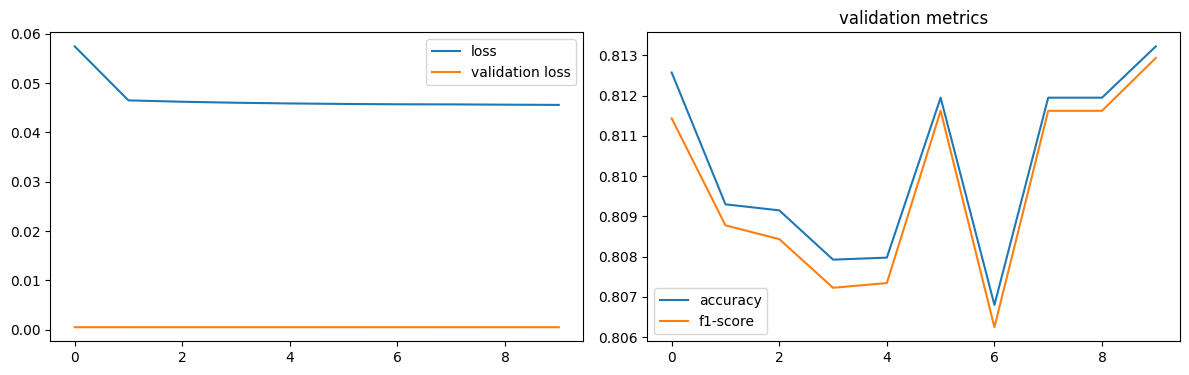

Test: loss: 0.3882960379123688, avg metrics: (0.8404690146446228, 0.8400598168373108)
dropping feature: (1, 'neuron23')


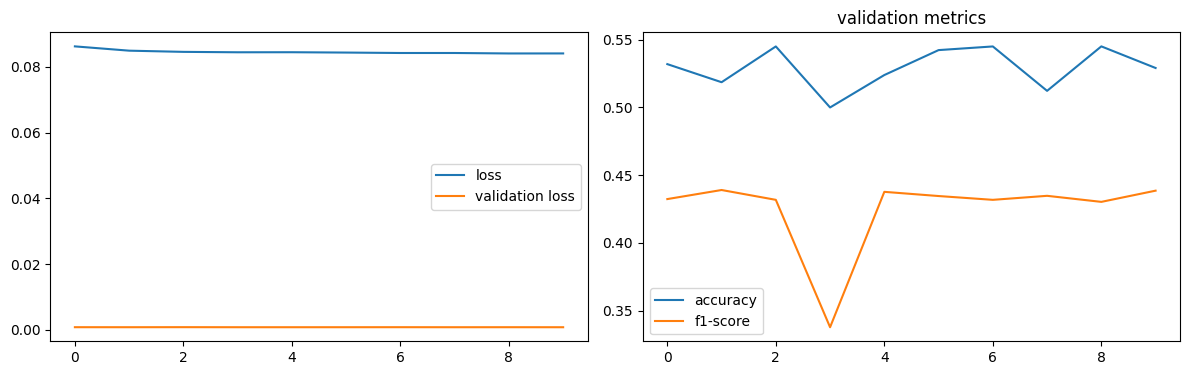

Test: loss: 0.6735349297523499, avg metrics: (0.5373861193656921, 0.42906726598739625)


In [14]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(32)]


def model_factory(size):
    model = MLP(1, (size, 32), 2)
    model.layer1 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 10,
    labels, "", None
)

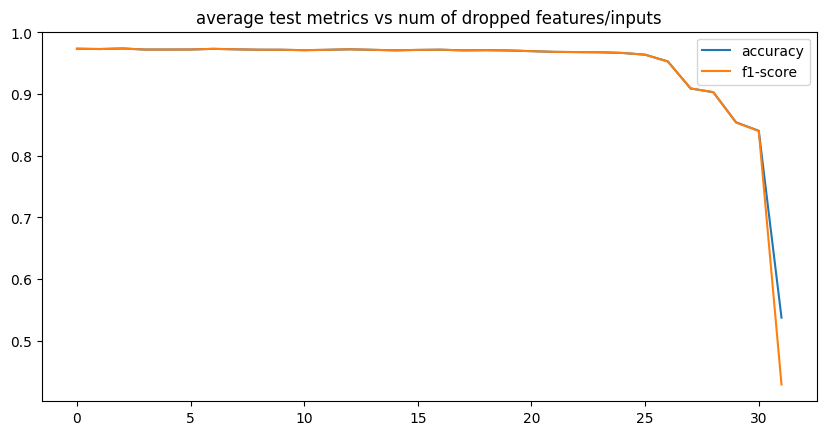

In [15]:
plot_dropping_metrics(test_metrics, labels)

In [16]:
num_drop_neurons = 25

save_models("banana", "layer2", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].layer2

best_model.layer2 = layer
best_model.layer1[0] = reduce_linear(best_model.layer1[0], dropped, num_drop_neurons)

features left [7]:  ['neuron0', 'neuron1', 'neuron6', 'neuron7', 'neuron19', 'neuron23', 'neuron26']


### 2nd hidden layer

In [17]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

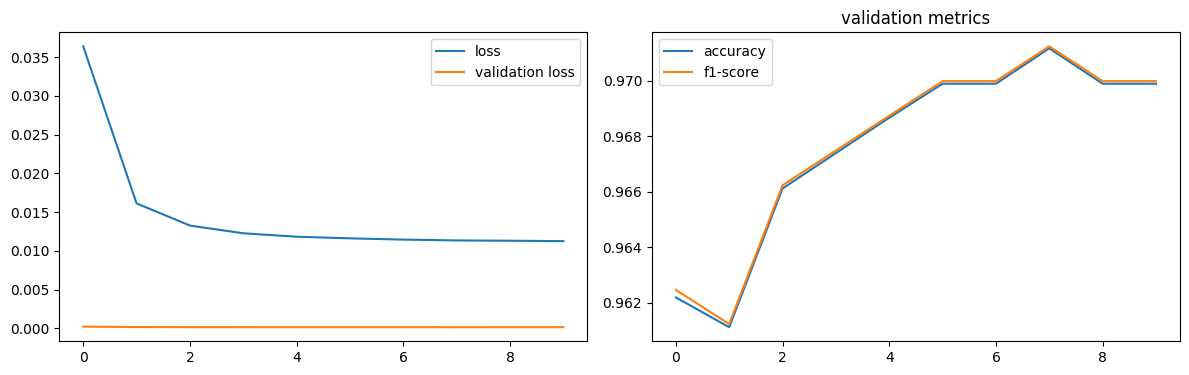

Test: loss: 0.11216304451227188, avg metrics: (0.9647389650344849, 0.9647475957870484)
dropping feature: (20, 'neuron20')


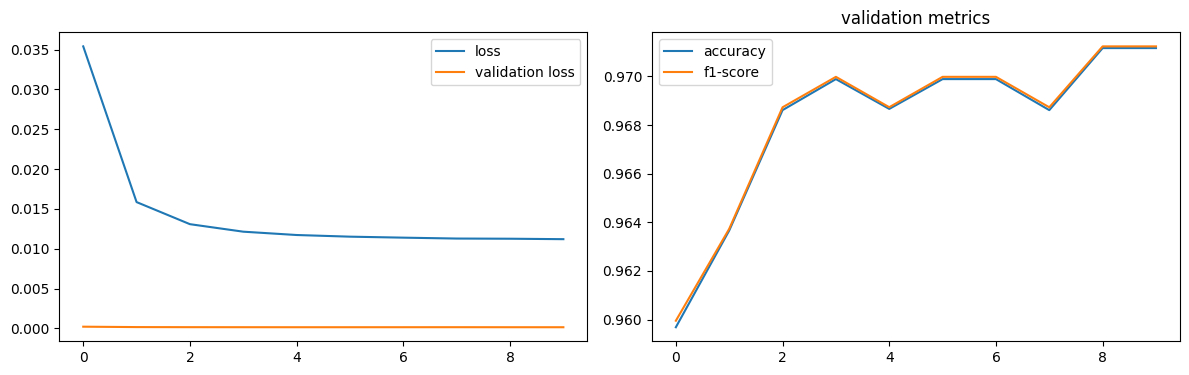

Test: loss: 0.11201086640357971, avg metrics: (0.9649089813232422, 0.9649145603179932)
dropping feature: (23, 'neuron24')


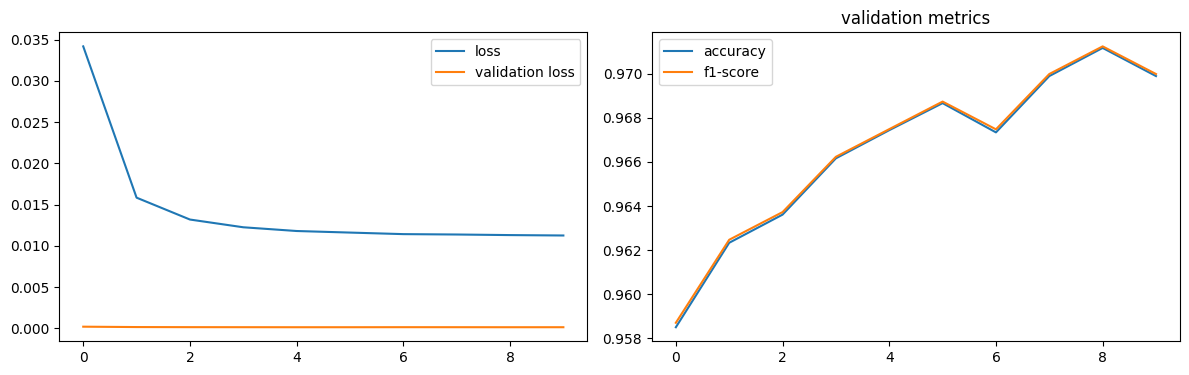

Test: loss: 0.11277590692043304, avg metrics: (0.9649895548820495, 0.9649977684020996)
dropping feature: (23, 'neuron25')


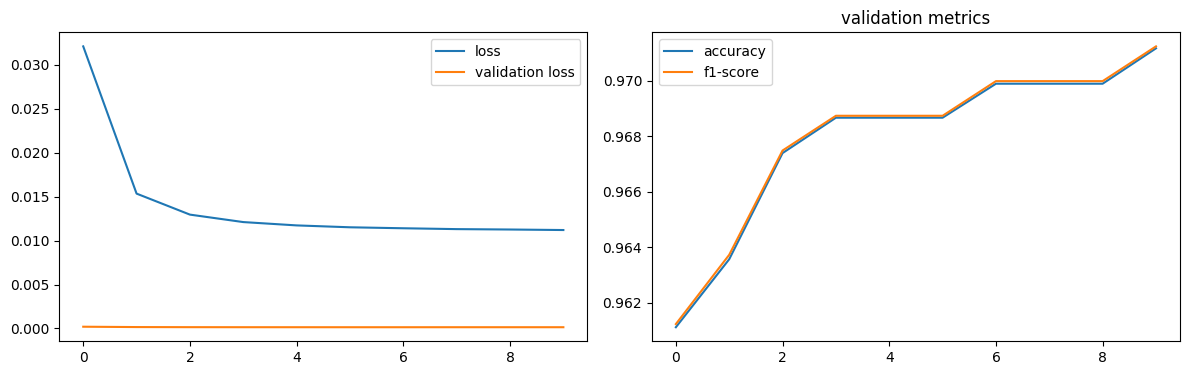

Test: loss: 0.11222445219755173, avg metrics: (0.965331768989563, 0.965331768989563)
dropping feature: (23, 'neuron26')


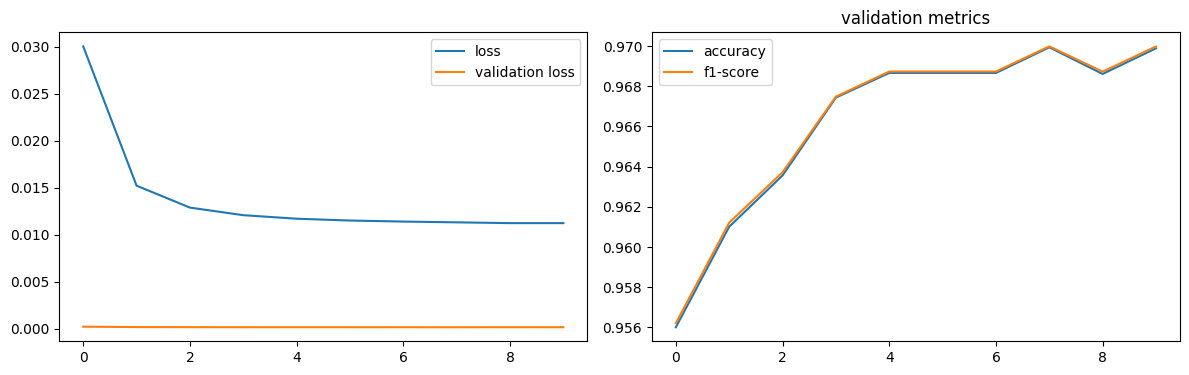

Test: loss: 0.1119551956653595, avg metrics: (0.9645745277404785, 0.9645812034606933)
dropping feature: (26, 'neuron30')


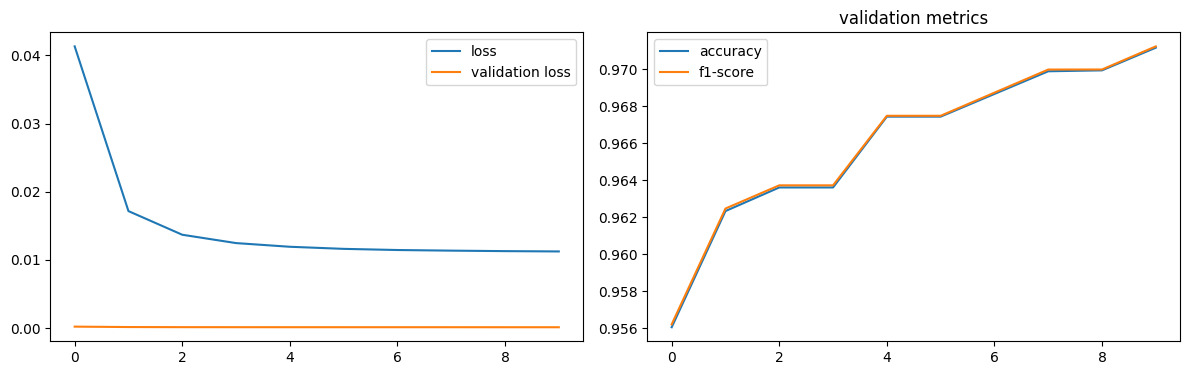

Test: loss: 0.1118696853518486, avg metrics: (0.9649112105369568, 0.9649148225784302)
dropping feature: (19, 'neuron19')


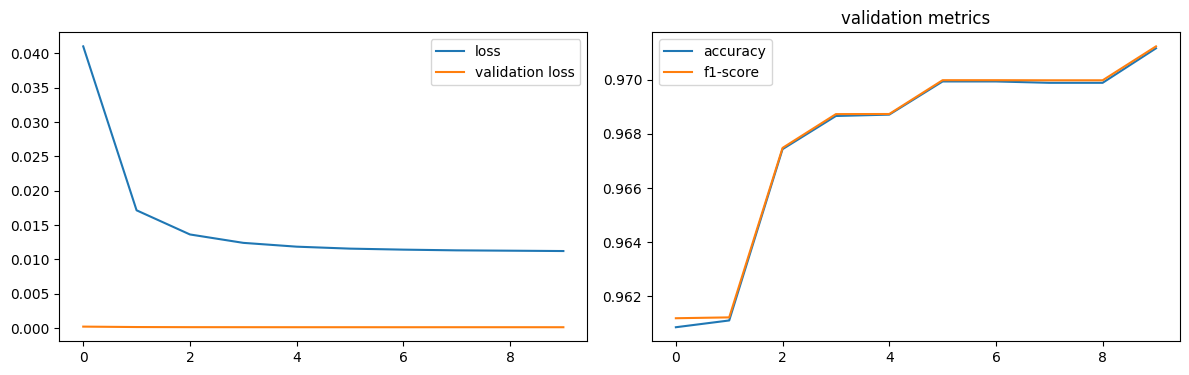

Test: loss: 0.11182628571987152, avg metrics: (0.9646506428718566, 0.964663851261139)
dropping feature: (0, 'neuron0')


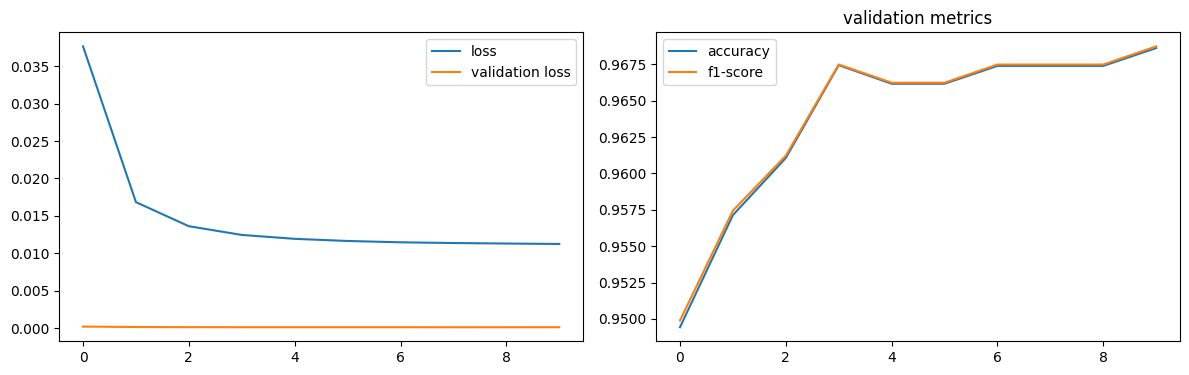

Test: loss: 0.11365129053592682, avg metrics: (0.9641561865806579, 0.9641643404960633)
dropping feature: (7, 'neuron8')


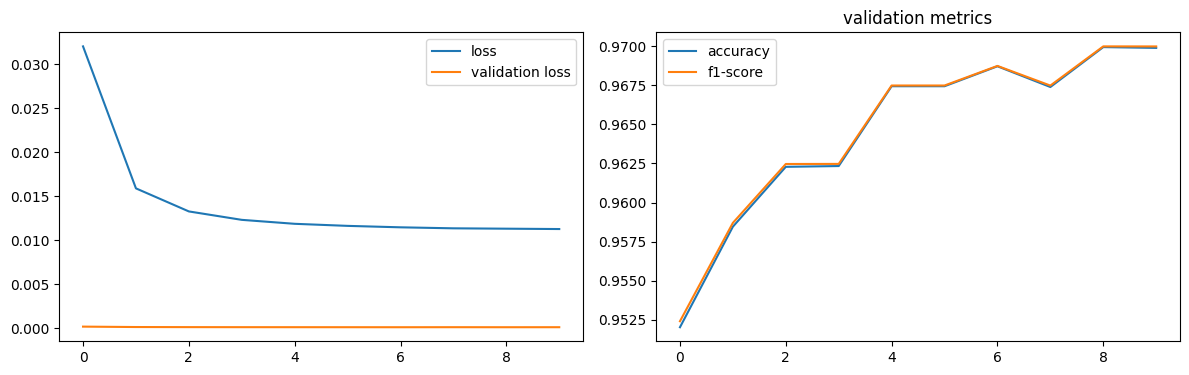

Test: loss: 0.1129801794886589, avg metrics: (0.9643250942230225, 0.9643312335014343)
dropping feature: (21, 'neuron28')


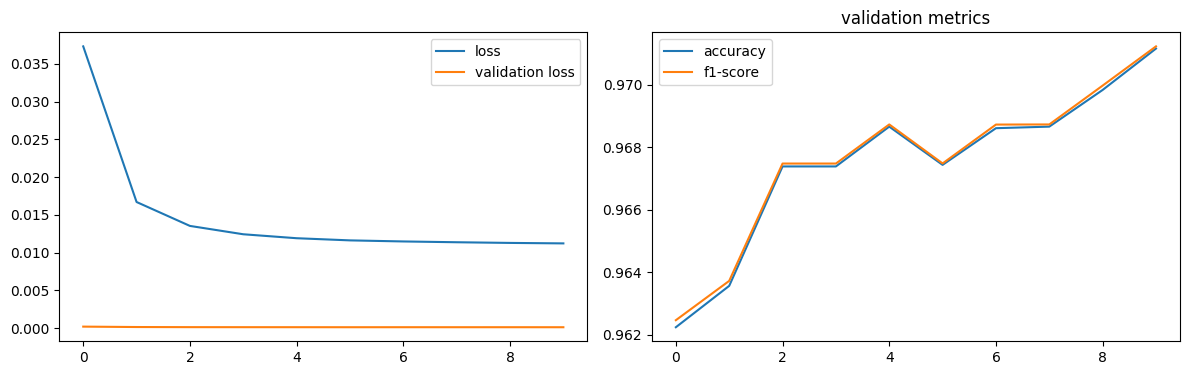

Test: loss: 0.11223827302455902, avg metrics: (0.9647423148155212, 0.9647479057312012)
dropping feature: (5, 'neuron6')


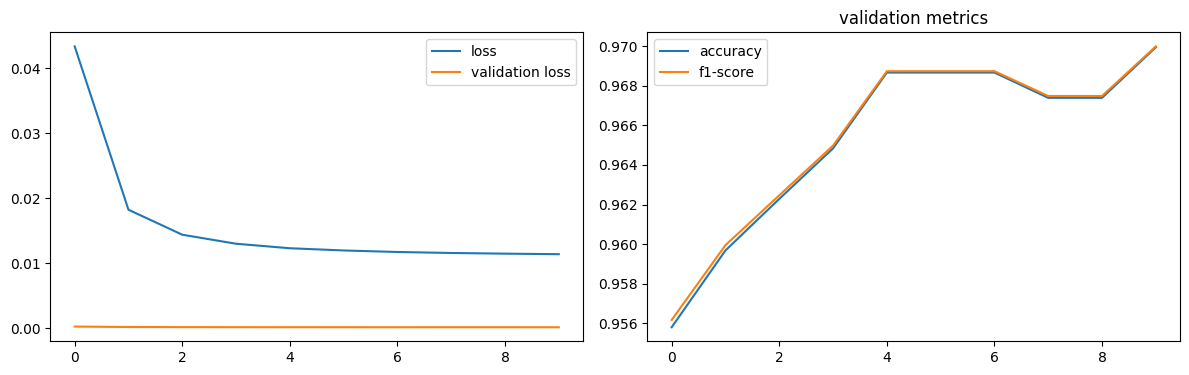

Test: loss: 0.11373499780893326, avg metrics: (0.9650779008865357, 0.9650814771652222)
dropping feature: (11, 'neuron14')


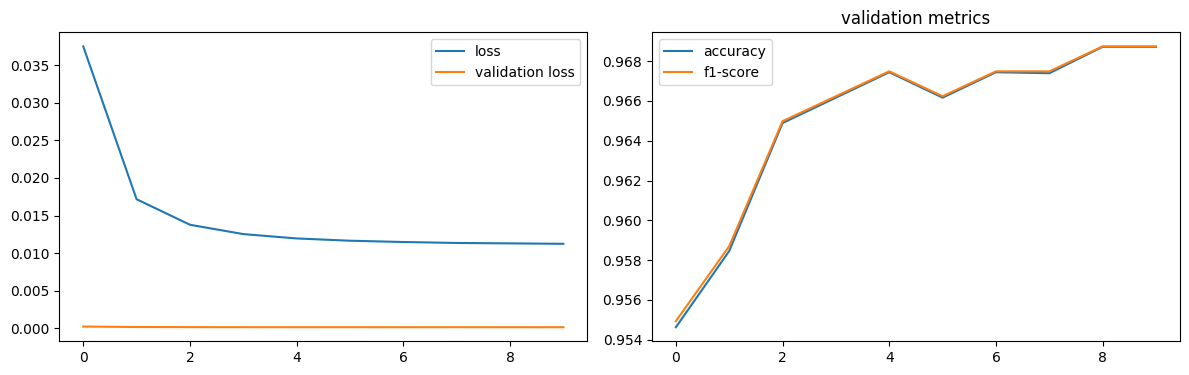

Test: loss: 0.1119987890124321, avg metrics: (0.9651628971099854, 0.9651648879051209)
dropping feature: (12, 'neuron16')


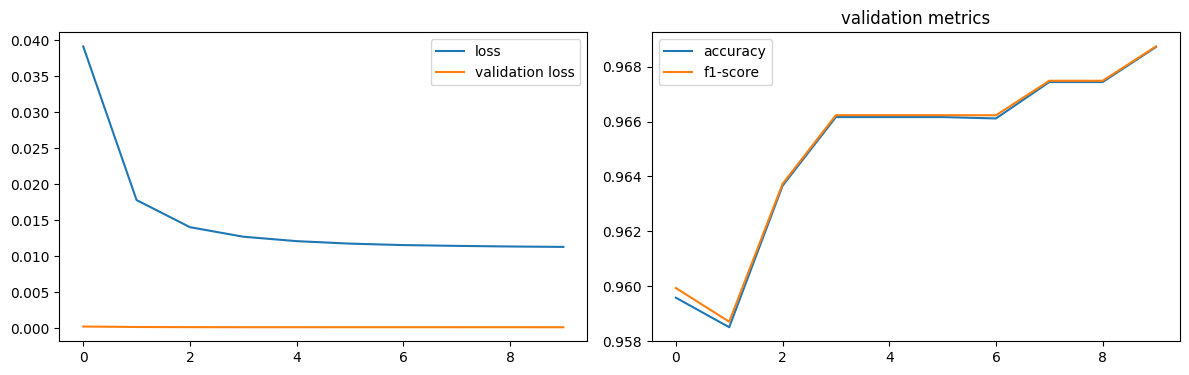

Test: loss: 0.11280937492847443, avg metrics: (0.9660801529884339, 0.966081690788269)
dropping feature: (12, 'neuron17')


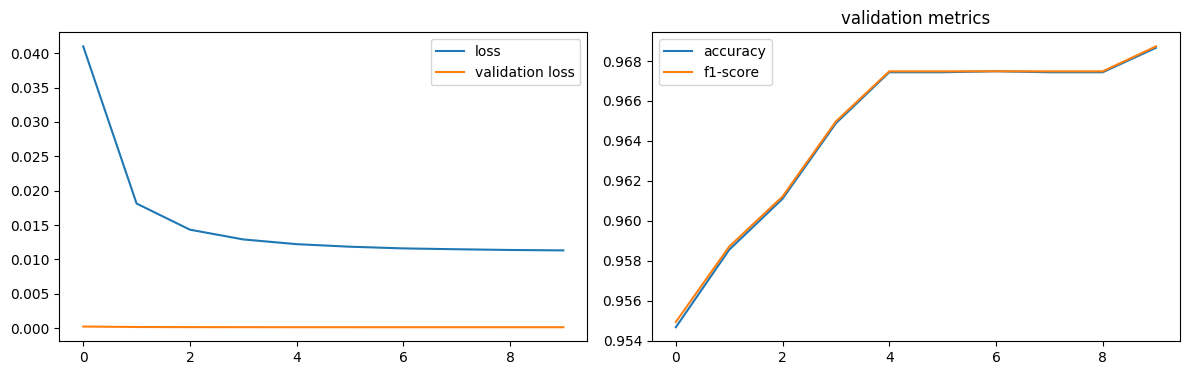

Test: loss: 0.11352857947349548, avg metrics: (0.9654862403869628, 0.9654974699020386)
dropping feature: (16, 'neuron27')


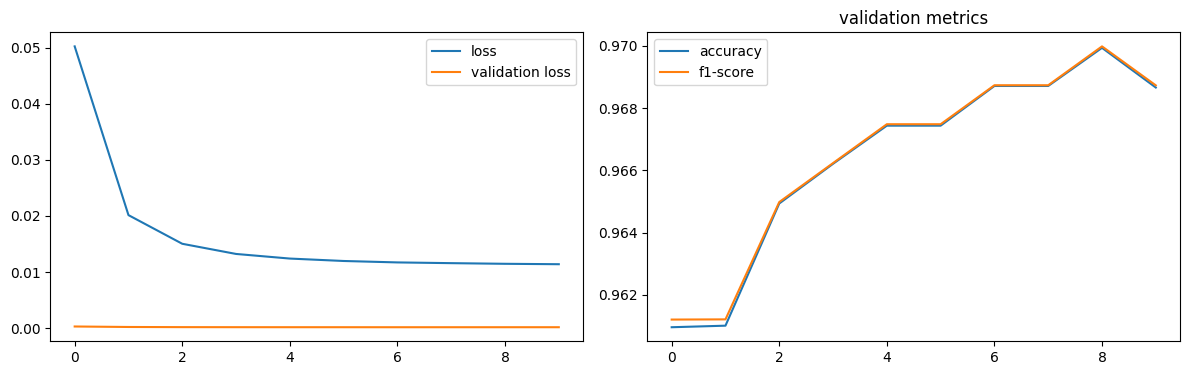

Test: loss: 0.11460516601800919, avg metrics: (0.9660757184028625, 0.9660813808441162)
dropping feature: (1, 'neuron2')


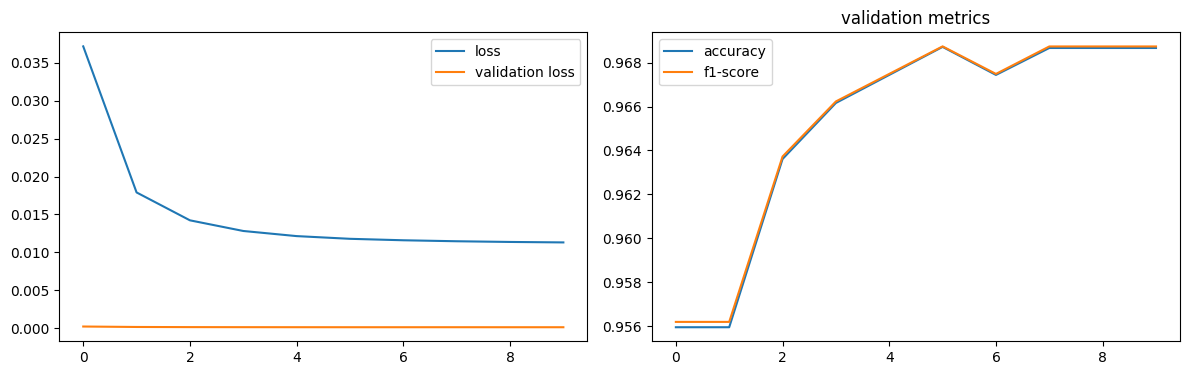

Test: loss: 0.11362207680940628, avg metrics: (0.9652434587478638, 0.9652480125427246)
dropping feature: (13, 'neuron22')


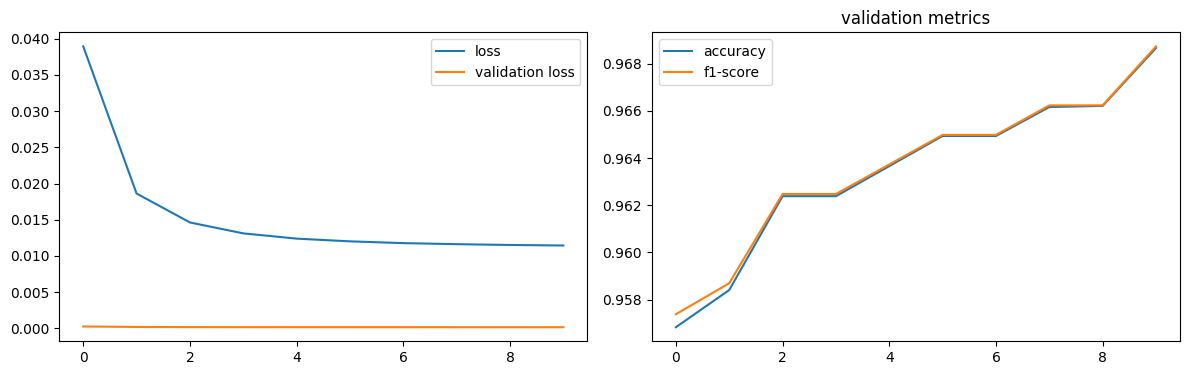

Test: loss: 0.11561968177556992, avg metrics: (0.9627200245857239, 0.9627455234527588)
dropping feature: (7, 'neuron11')


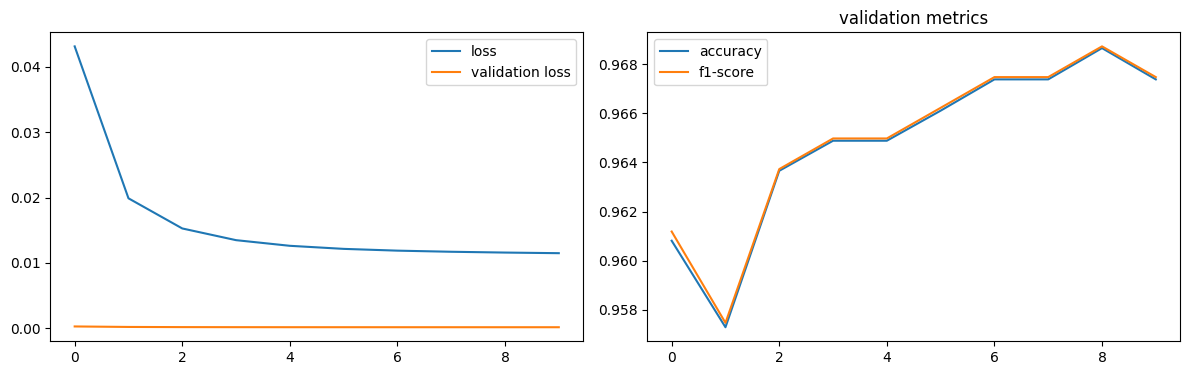

Test: loss: 0.11618297547101974, avg metrics: (0.9614794254302979, 0.9614965319633484)
dropping feature: (4, 'neuron7')


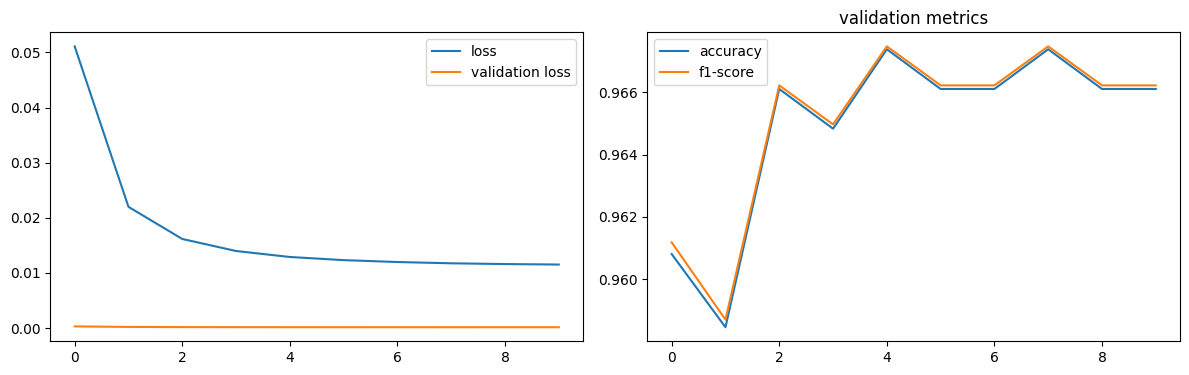

Test: loss: 0.11600273102521896, avg metrics: (0.9622938871383667, 0.9623276114463806)
dropping feature: (12, 'neuron29')


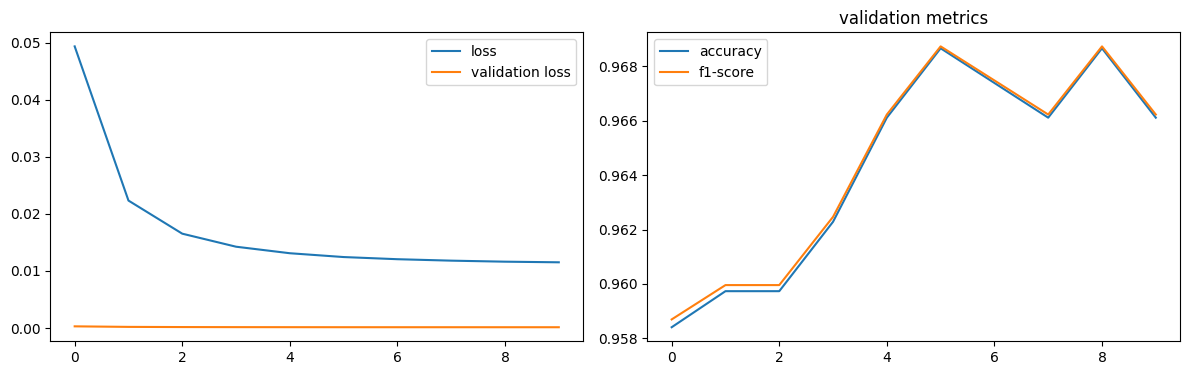

Test: loss: 0.11536461114883423, avg metrics: (0.962131667137146, 0.9621615171432495)
dropping feature: (6, 'neuron12')


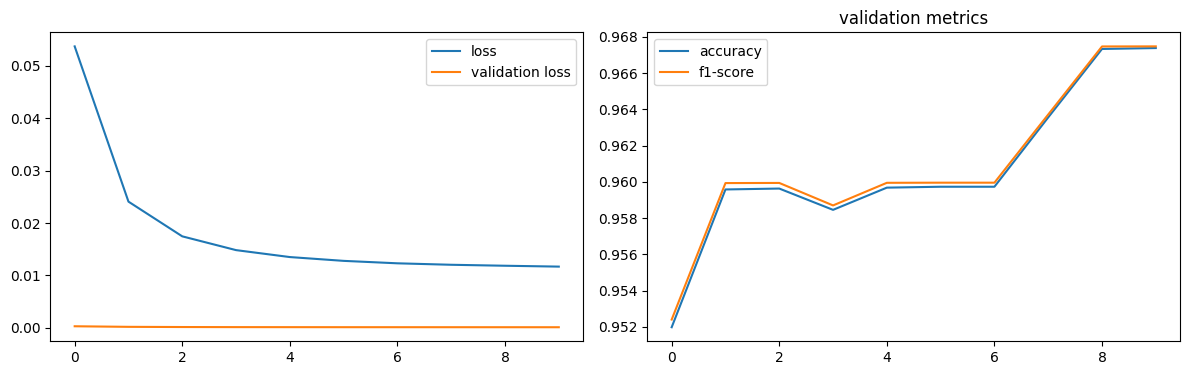

Test: loss: 0.11586649715900421, avg metrics: (0.9622188806533813, 0.9622453451156616)
dropping feature: (7, 'neuron15')


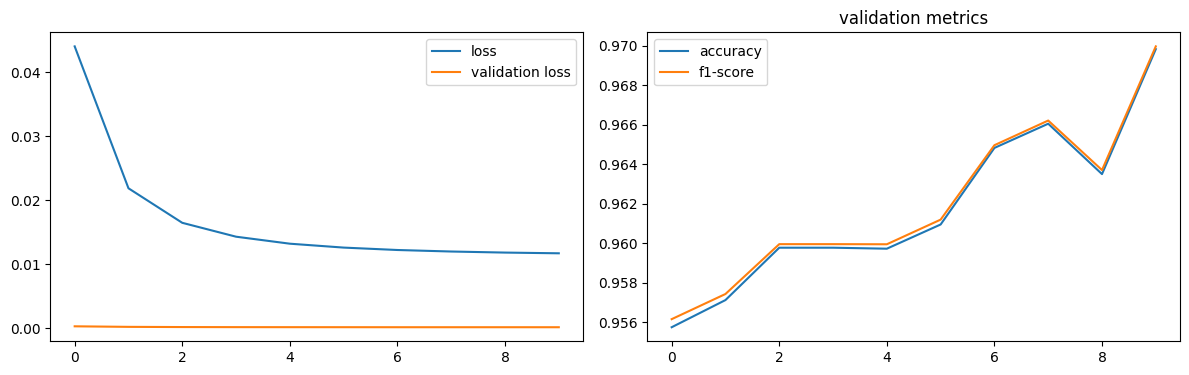

Test: loss: 0.11704180389642715, avg metrics: (0.9621394276618958, 0.9621624827384949)
dropping feature: (10, 'neuron31')


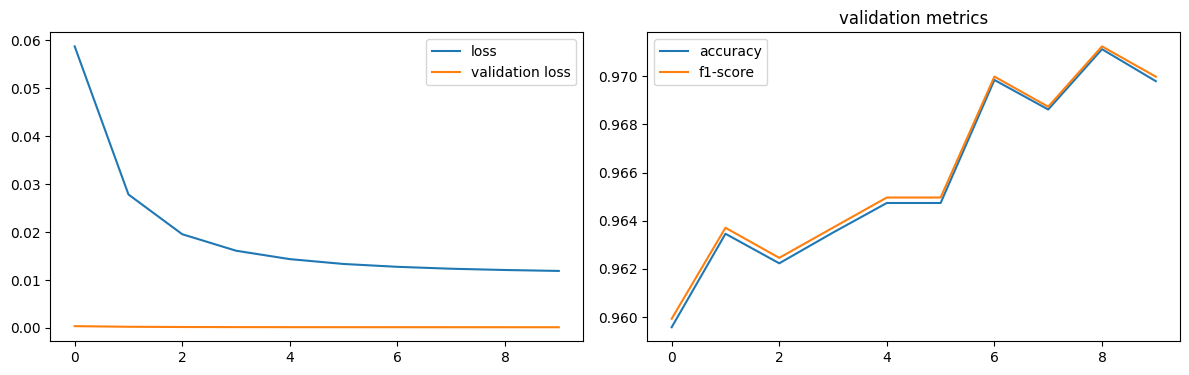

Test: loss: 0.11824020743370056, avg metrics: (0.9634850502014161, 0.9634971380233764)
dropping feature: (5, 'neuron10')


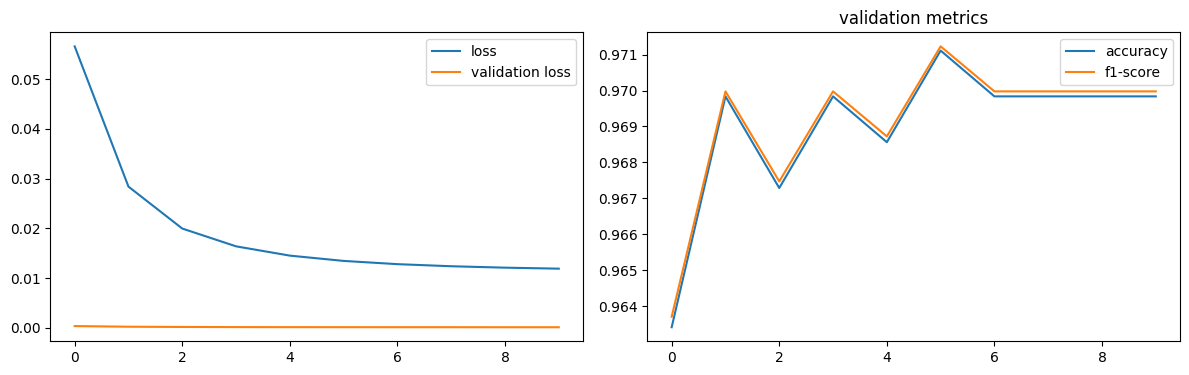

Test: loss: 0.11698521673679352, avg metrics: (0.9648350954055787, 0.9648319959640503)
dropping feature: (7, 'neuron21')


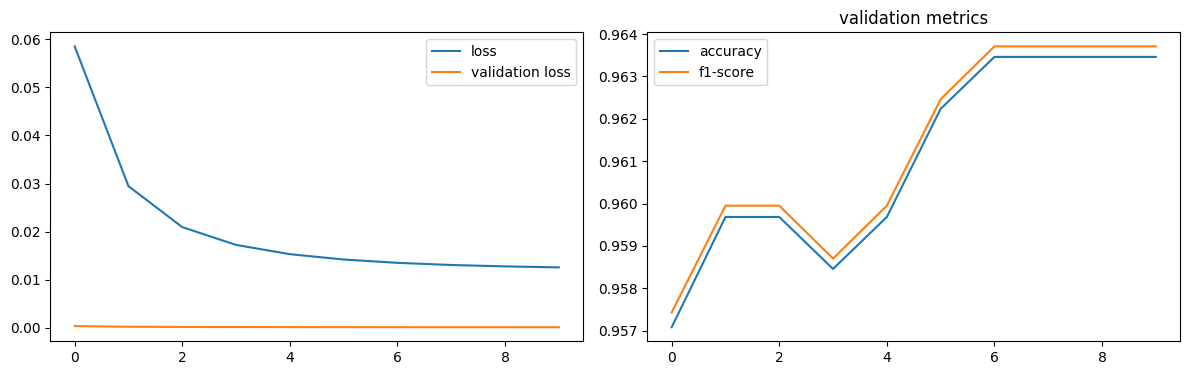

Test: loss: 0.12242644280195236, avg metrics: (0.9616472005844117, 0.961663293838501)
dropping feature: (5, 'neuron13')


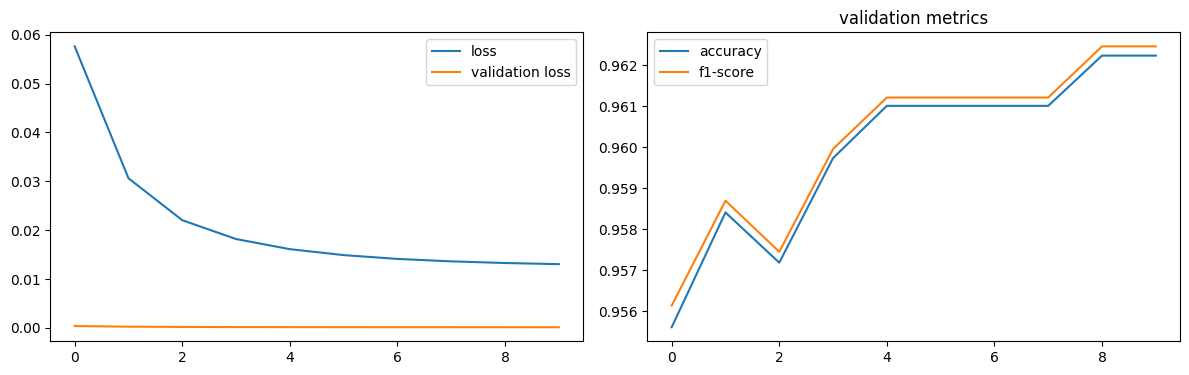

Test: loss: 0.12638810276985168, avg metrics: (0.960808277130127, 0.960829210281372)
dropping feature: (5, 'neuron18')


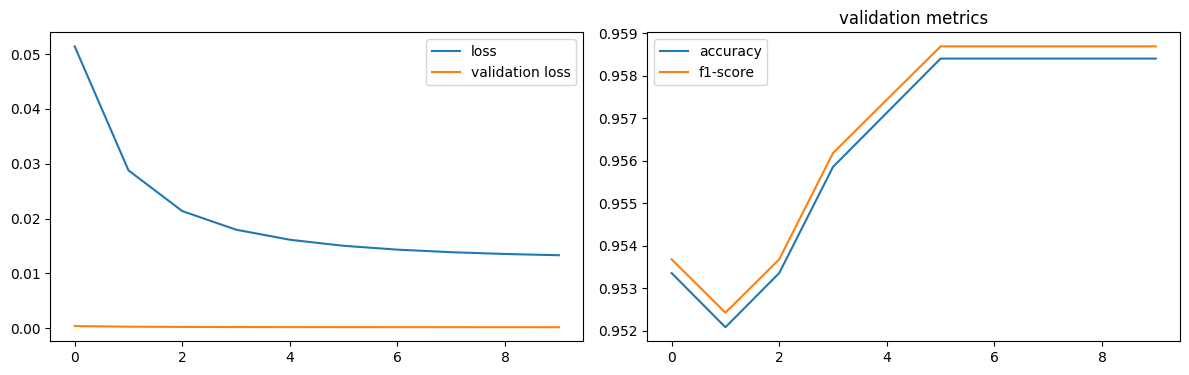

Test: loss: 0.12817686796188354, avg metrics: (0.9598048567771912, 0.9598287105560303)
dropping feature: (4, 'neuron9')


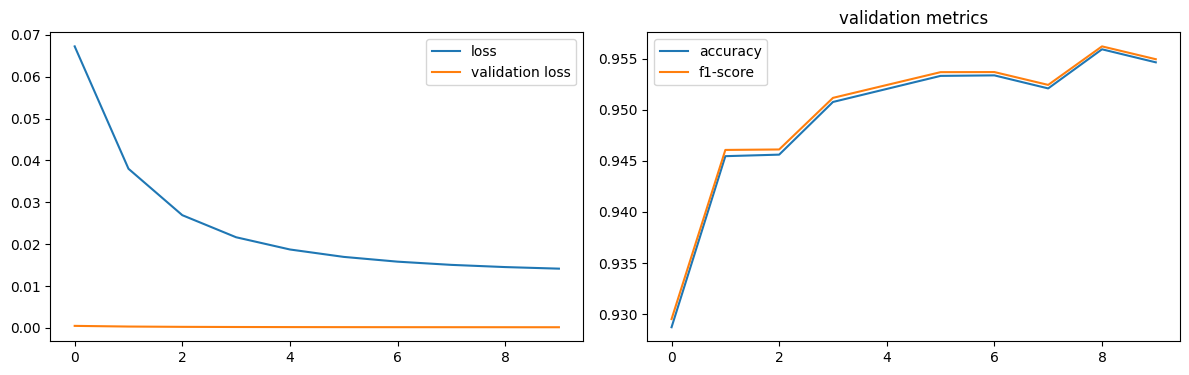

Test: loss: 0.13293662667274475, avg metrics: (0.9582992672920227, 0.958327841758728)
dropping feature: (1, 'neuron3')


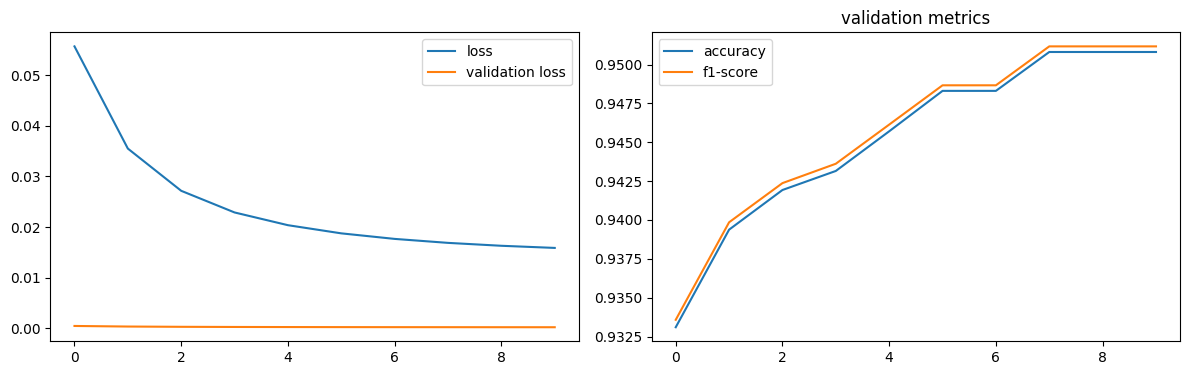

Test: loss: 0.14781366288661957, avg metrics: (0.9476287841796875, 0.9476590514183044)
dropping feature: (1, 'neuron4')


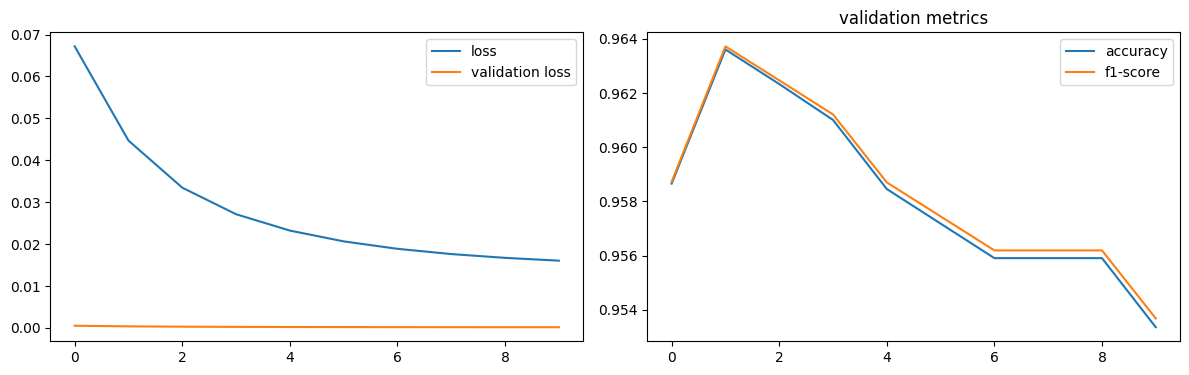

Test: loss: 0.1450783759355545, avg metrics: (0.9537723779678344, 0.9538222312927246)
dropping feature: (1, 'neuron5')


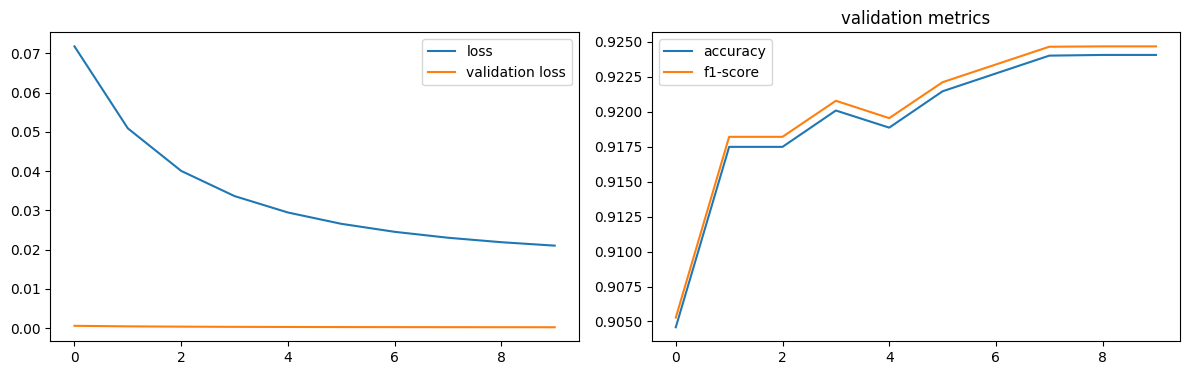

Test: loss: 0.18098953366279602, avg metrics: (0.9234682559967041, 0.923570191860199)
dropping feature: (1, 'neuron23')


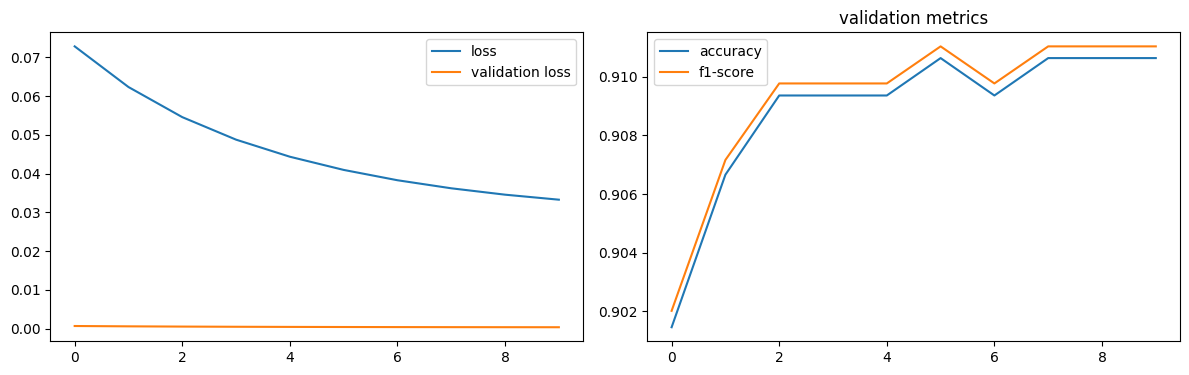

Test: loss: 0.2741987109184265, avg metrics: (0.9203686714172363, 0.9204465985298157)


In [18]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(32)]


def model_factory(size):
    model = MLP(1, (1, size), 2)
    model.layer1 = nn.Identity()
    model.layer2 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 10,
    labels, "", None
)

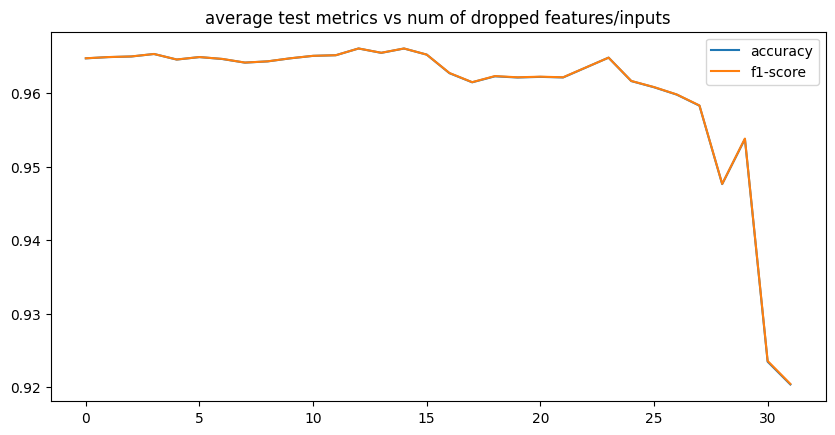

In [19]:
plot_dropping_metrics(test_metrics, labels)

In [20]:
num_drop_neurons = 23

save_models("banana", "layer3", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].out

best_model.out = layer
best_model.layer2[0] = reduce_linear(best_model.layer2[0], dropped, num_drop_neurons)

features left [9]:  ['neuron1', 'neuron3', 'neuron4', 'neuron5', 'neuron9', 'neuron13', 'neuron18', 'neuron21', 'neuron23']


### pruned

In [21]:
best_model

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=6, out_features=7, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=7, out_features=9, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=9, out_features=2, bias=True)
  (relu): ReLU()
)

In [22]:
with torch.no_grad():
    inputs, targets = dgsm_datasets["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test {labels}: {test_metrics}")

test ('accuracy', 'f1-score'): (0.9658373594284058, 0.9658322334289551)


test: ('accuracy', 'f1-score'): (0.9683208465576172, 0.9683311581611633)


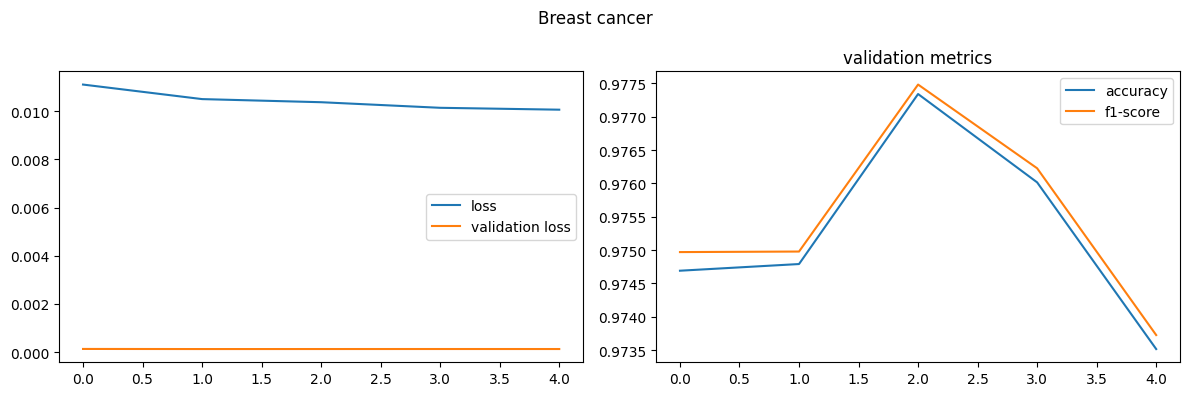

In [23]:
optimizer = optimizer_factory(best_model)
metrics = model_train(dgsm_datasets, best_model, optimizer, criterion, score_outputs, 5)

with torch.no_grad():
    inputs, targets = dgsm_datasets["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test: {labels}: {test_metrics}")
plot_metrics('Breast cancer', metrics, labels)

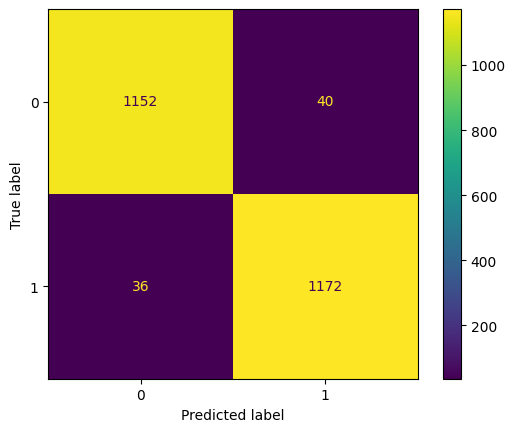

In [24]:
ConfusionMatrixDisplay.from_predictions(targets, outputs.argmax(dim=1))
plt.show()

In [25]:
save_models("banana", "prunned", [best_model], None)

## FAST

In [26]:
best_model = MLP(len(banana_headers), (32, 32), 2)

### input layer

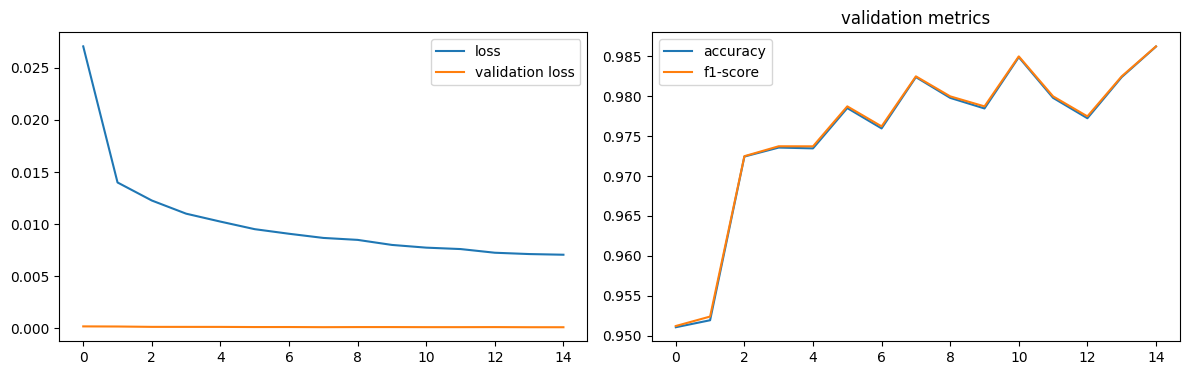

Test: loss: 0.07832299917936325, avg metrics: (0.9769900918006897, 0.9769983291625977)
dropping feature: (0, 'Size')


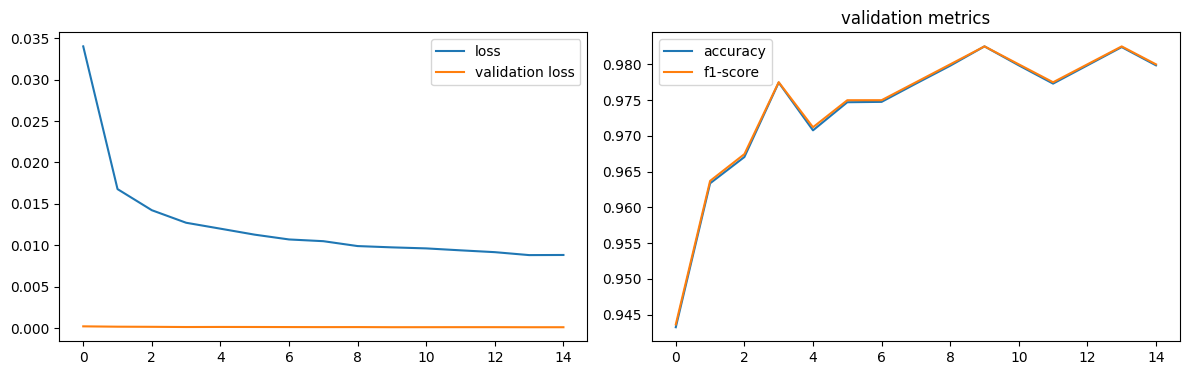

Test: loss: 0.09034319967031479, avg metrics: (0.9734438180923461, 0.9734152674674987)
dropping feature: (4, 'Ripeness')


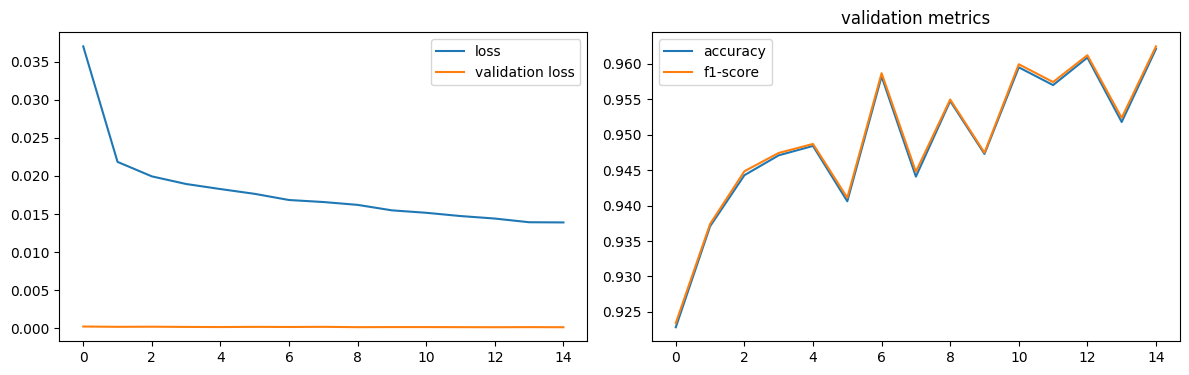

Test: loss: 0.12871383130550385, avg metrics: (0.9515839576721191, 0.951577115058899)
dropping feature: (1, 'Sweetness')


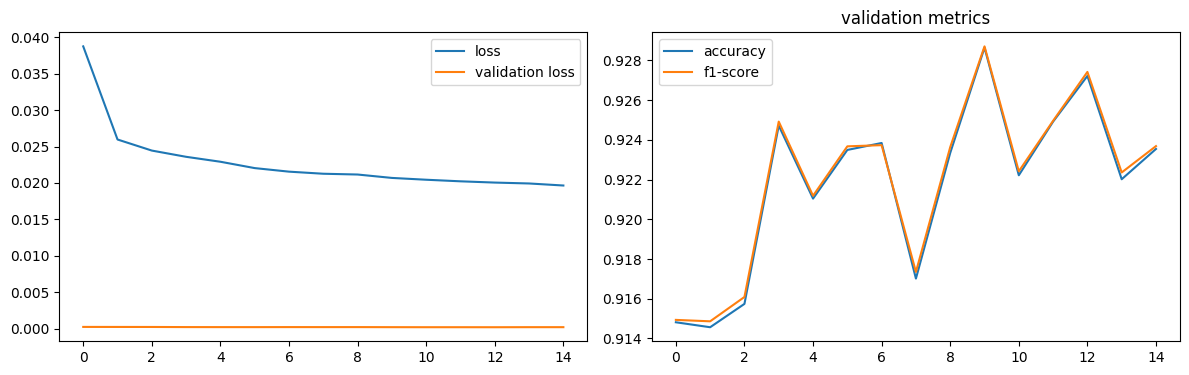

Test: loss: 0.1655687391757965, avg metrics: (0.9350787758827209, 0.9350754141807556)
dropping feature: (2, 'HarvestTime')


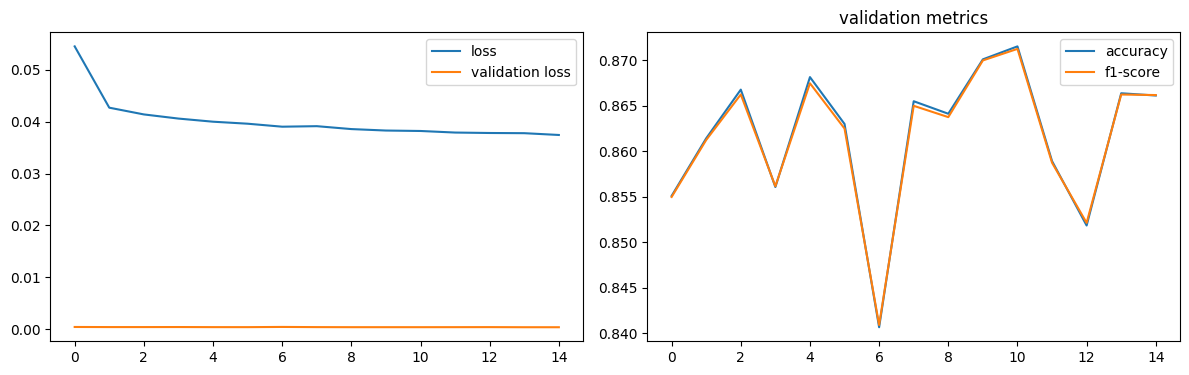

Test: loss: 0.3067600131034851, avg metrics: (0.8730760216712952, 0.8730748772621155)
dropping feature: (0, 'Weight')


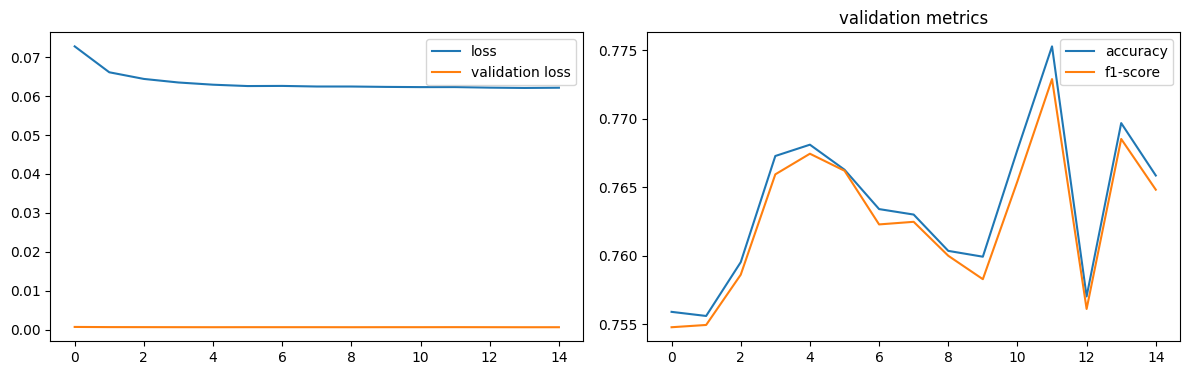

Test: loss: 0.4919204115867615, avg metrics: (0.7607537984848023, 0.7601808667182922)
dropping feature: (1, 'Acidity')


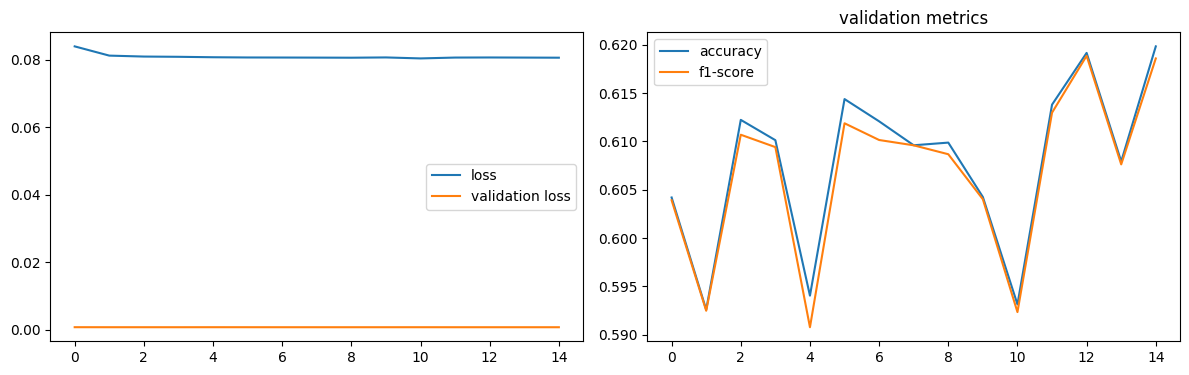

Test: loss: 0.6505280137062073, avg metrics: (0.6106171369552612, 0.6090312123298645)


In [27]:
torch.manual_seed(2024)

datasets = banana_datasets.copy()
headers = banana_headers.copy()


def model_factory(size):
    return MLP(size, (32, 32), 2)


test_metrics, dropped, models = prune(
    datasets, headers, analyze_fast,
    model_factory, optimizer_factory, criterion, score_outputs, 15,
    labels, "", None
)

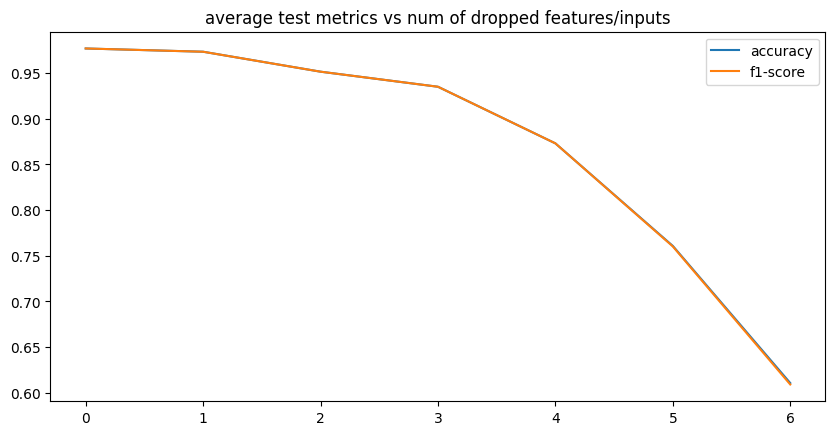

In [28]:
plot_dropping_metrics(test_metrics, labels)

In [29]:
num_drop_features = 1

save_models("banana", "fast-layer1", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_features)
layer = models[num_drop_features].layer1

best_model.layer1 = layer

fast_dataset = reduced_datasets

features left [6]:  ['Weight', 'Sweetness', 'Softness', 'HarvestTime', 'Ripeness', 'Acidity']


### 1st hidden layer

In [30]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

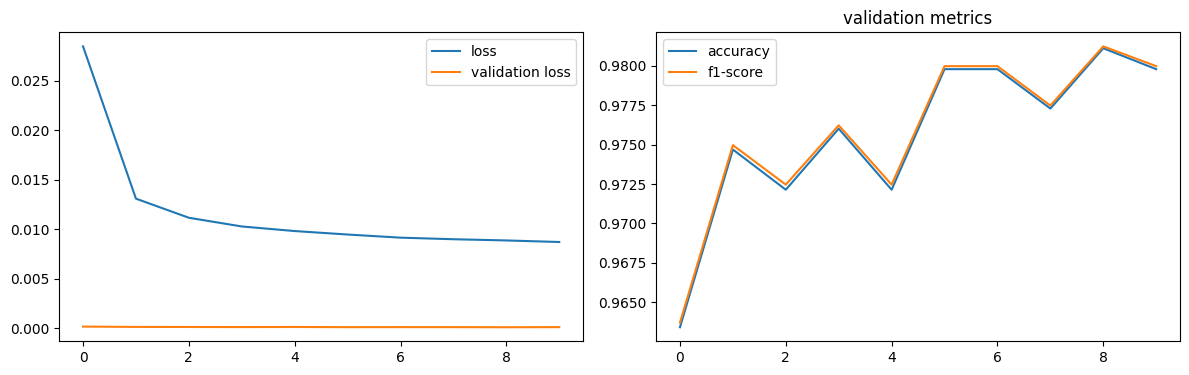

Test: loss: 0.09280698746442795, avg metrics: (0.9735021710395813, 0.9734986662864685)
dropping feature: (24, 'neuron24')


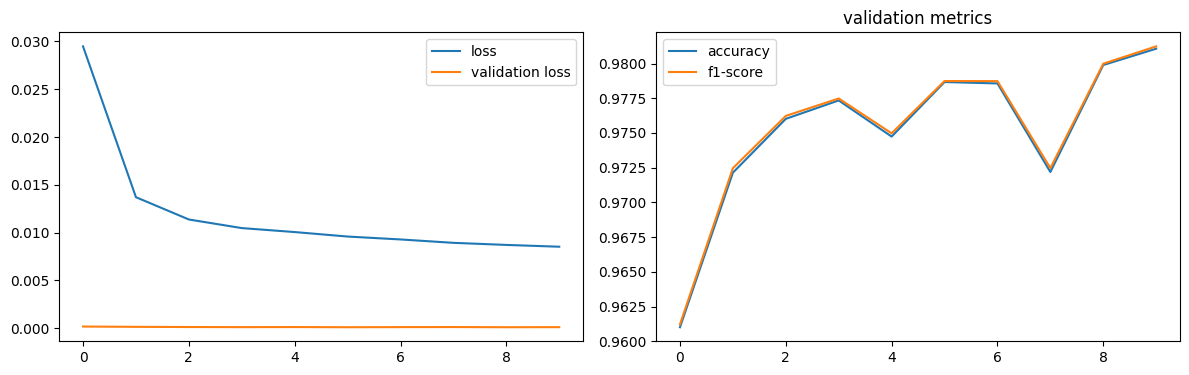

Test: loss: 0.09449800848960876, avg metrics: (0.9728532314300538, 0.9728320956230163)
dropping feature: (4, 'neuron4')


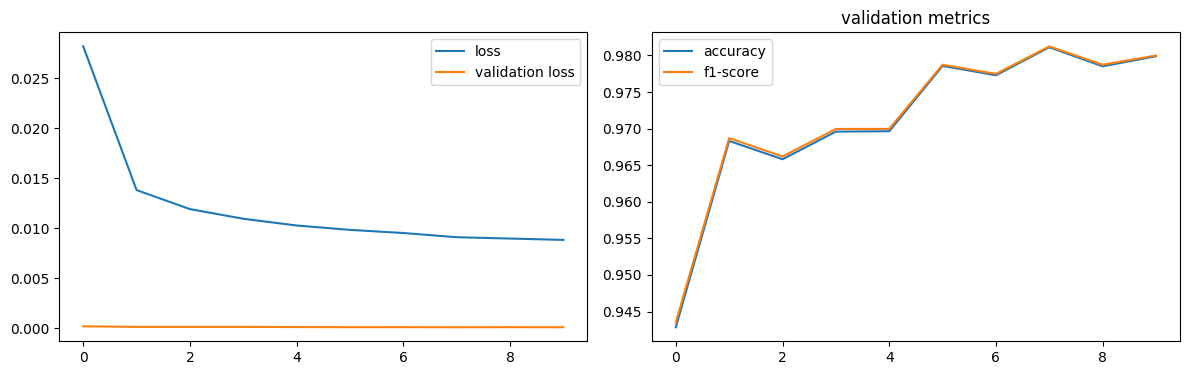

Test: loss: 0.09316997230052948, avg metrics: (0.9734910488128662, 0.9734980940818787)
dropping feature: (15, 'neuron16')


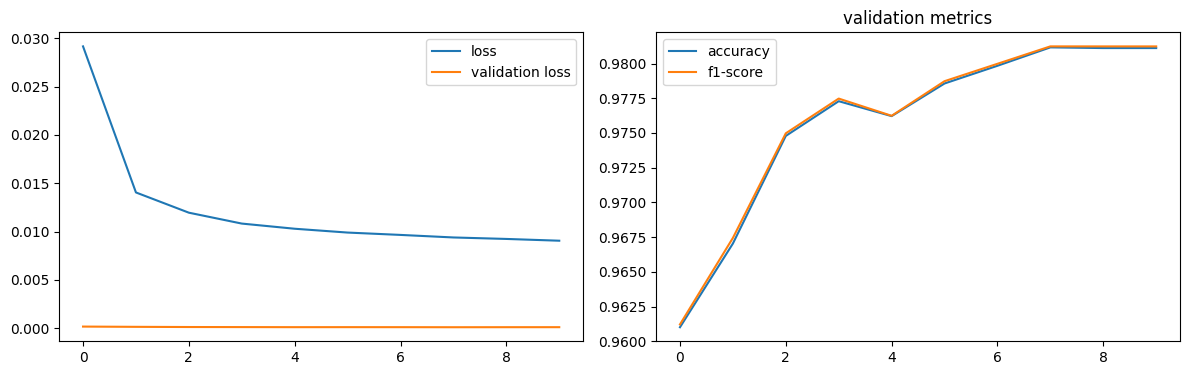

Test: loss: 0.09734664112329483, avg metrics: (0.971735954284668, 0.97174574136734)
dropping feature: (15, 'neuron17')


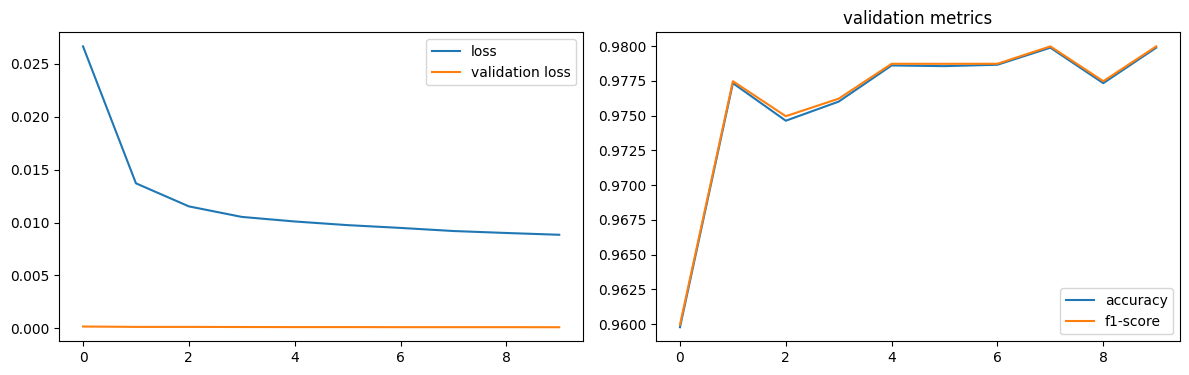

Test: loss: 0.09632135927677155, avg metrics: (0.9728654742240905, 0.972832465171814)
dropping feature: (15, 'neuron18')


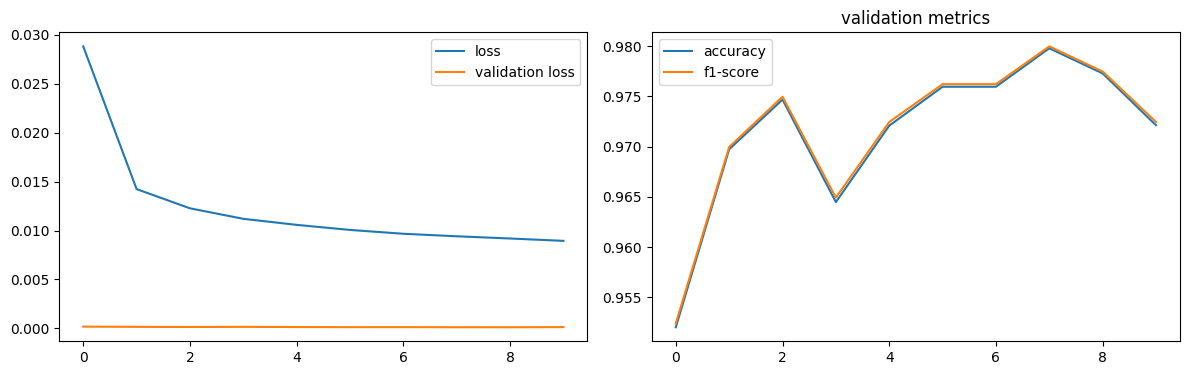

Test: loss: 0.10128973424434662, avg metrics: (0.9729899287223815, 0.9729971647262573)
dropping feature: (26, 'neuron31')


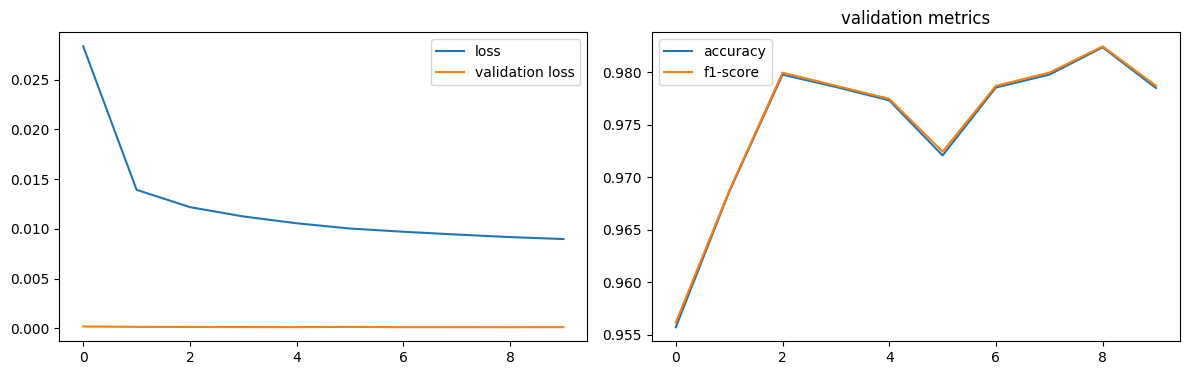

Test: loss: 0.0962391123175621, avg metrics: (0.9733132481575012, 0.9733304500579834)
dropping feature: (4, 'neuron5')


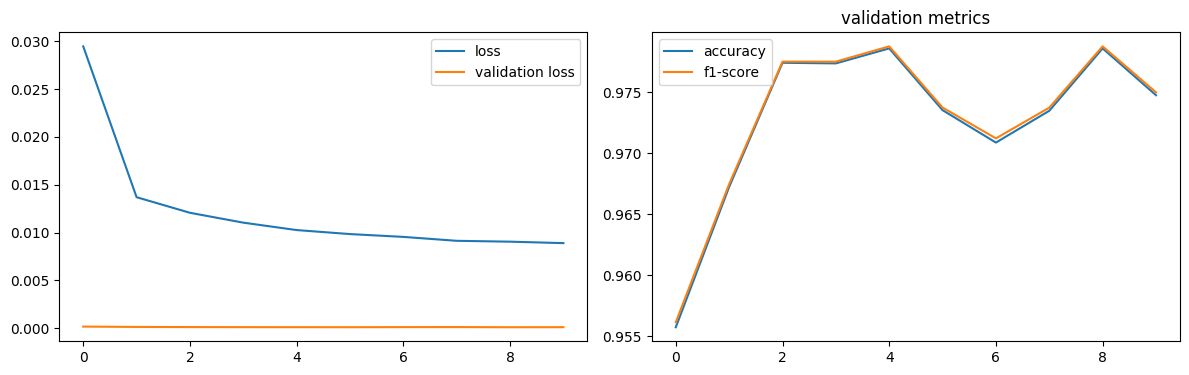

Test: loss: 0.09456251561641693, avg metrics: (0.9725109934806824, 0.9724993705749512)
dropping feature: (3, 'neuron3')


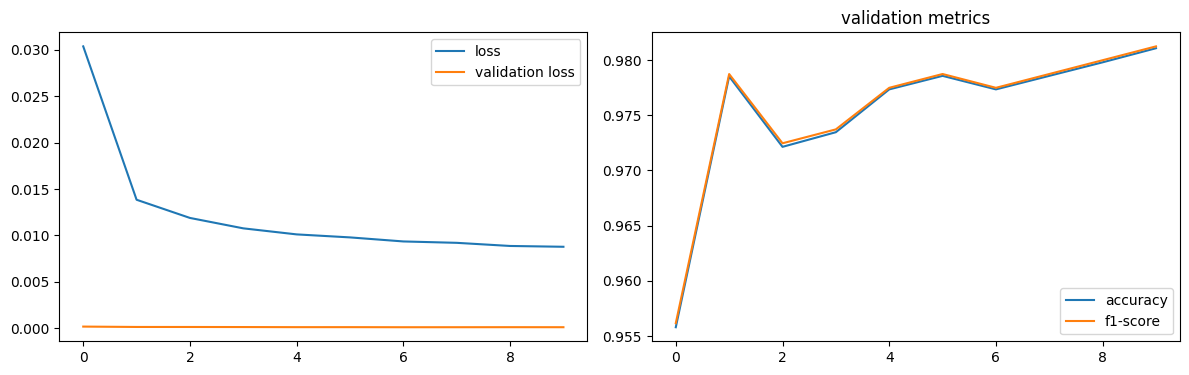

Test: loss: 0.09336838871240616, avg metrics: (0.9735010385513305, 0.9734986901283265)
dropping feature: (2, 'neuron2')


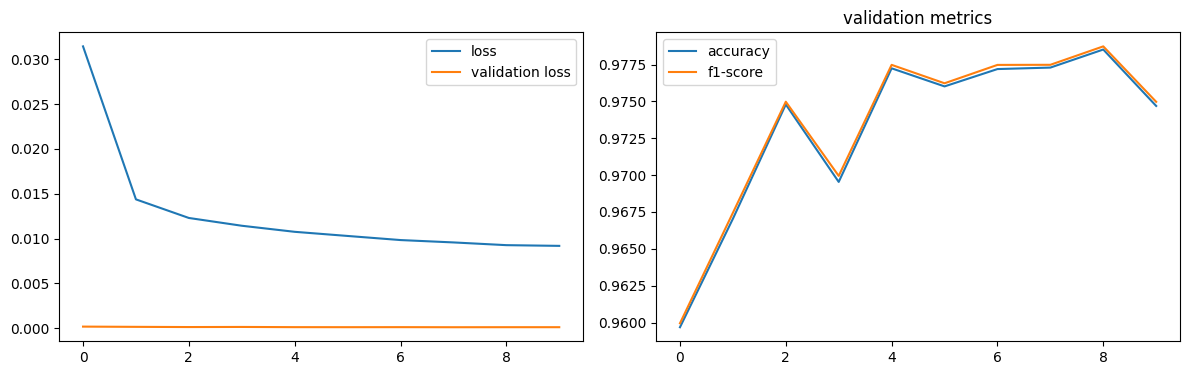

Test: loss: 0.09603244066238403, avg metrics: (0.9725021004676819, 0.9724980473518372)
dropping feature: (14, 'neuron21')


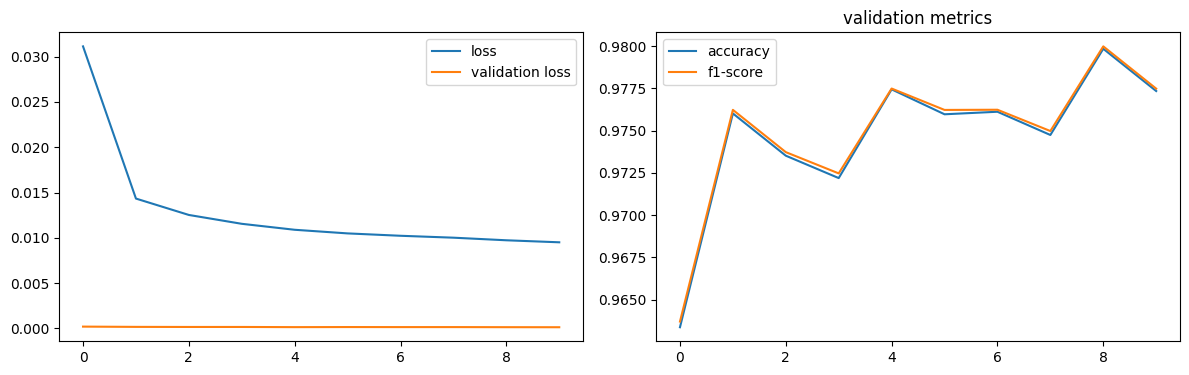

Test: loss: 0.0987149104475975, avg metrics: (0.9709081292152405, 0.9709142446517944)
dropping feature: (6, 'neuron10')


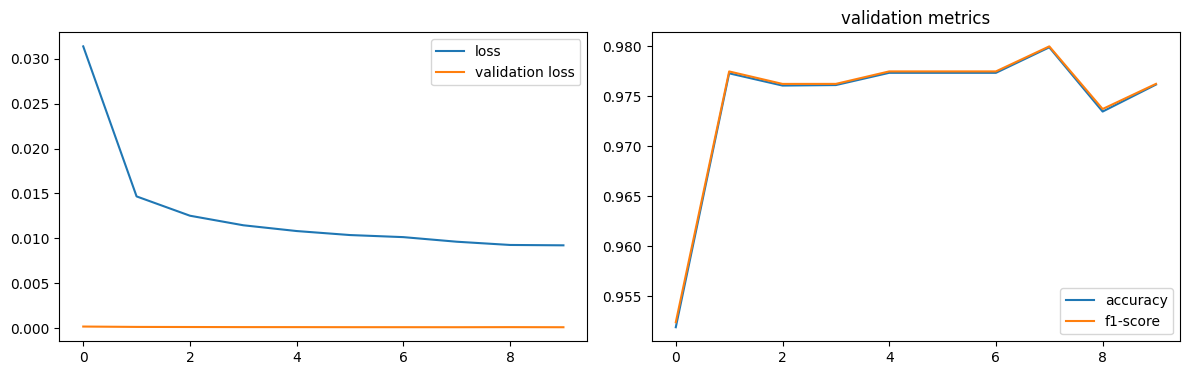

Test: loss: 0.09715771675109863, avg metrics: (0.9709359288215638, 0.97091623544693)
dropping feature: (8, 'neuron13')


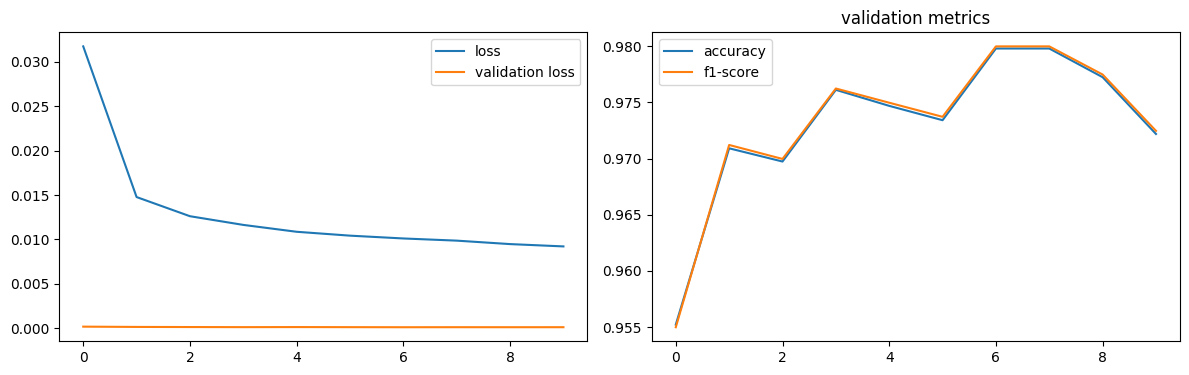

Test: loss: 0.10133317112922668, avg metrics: (0.9729238033294678, 0.9729155421257019)
dropping feature: (4, 'neuron8')


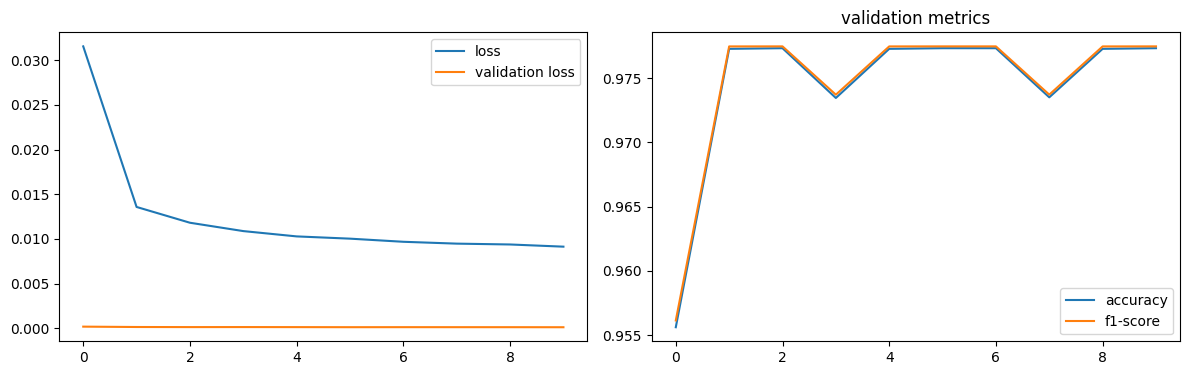

Test: loss: 0.09456975013017654, avg metrics: (0.9720770955085755, 0.9720813035964966)
dropping feature: (4, 'neuron9')


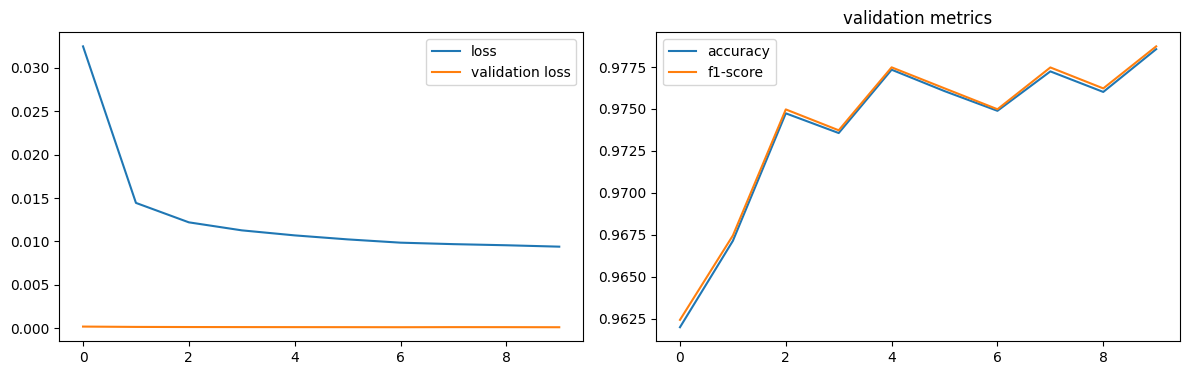

Test: loss: 0.09666101634502411, avg metrics: (0.9709126234054566, 0.9709124088287353)
dropping feature: (16, 'neuron29')


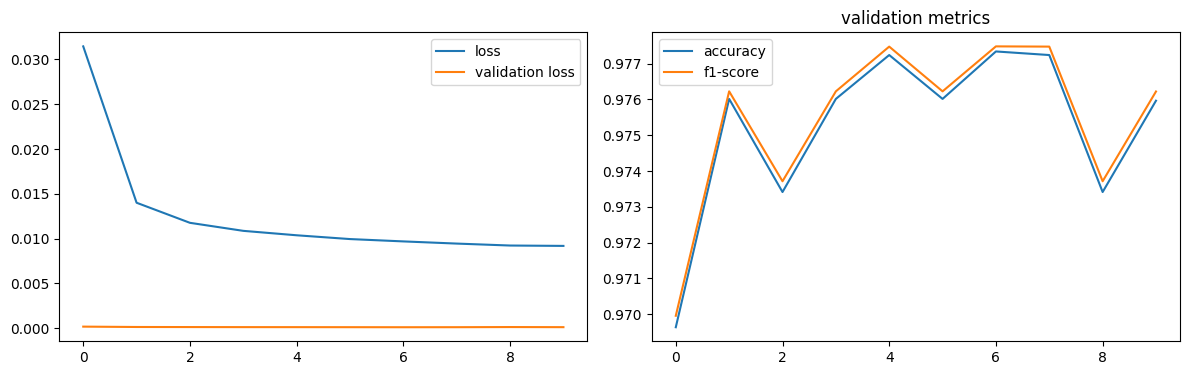

Test: loss: 0.09780864417552948, avg metrics: (0.9715637326240539, 0.9715804696083069)
dropping feature: (11, 'neuron23')


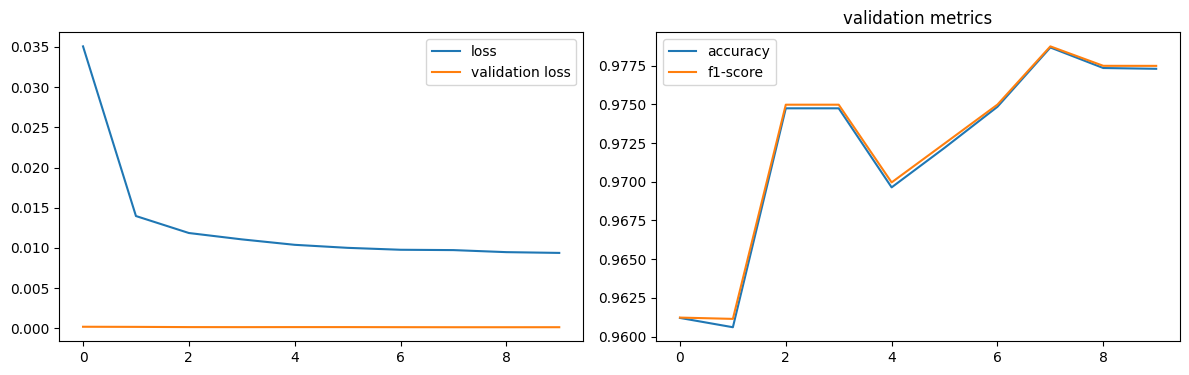

Test: loss: 0.09830682724714279, avg metrics: (0.9726048946380615, 0.9725824236869812)
dropping feature: (8, 'neuron19')


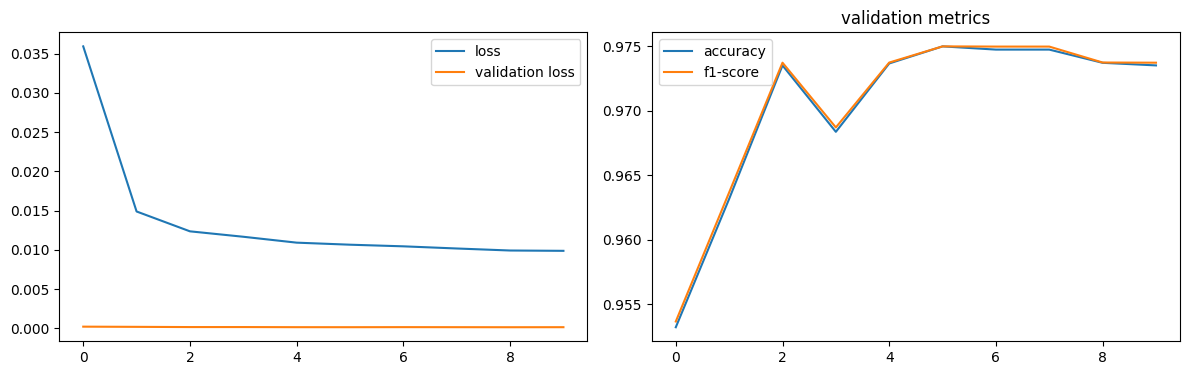

Test: loss: 0.10395902395248413, avg metrics: (0.9715970516204834, 0.9715824365615845)
dropping feature: (7, 'neuron15')


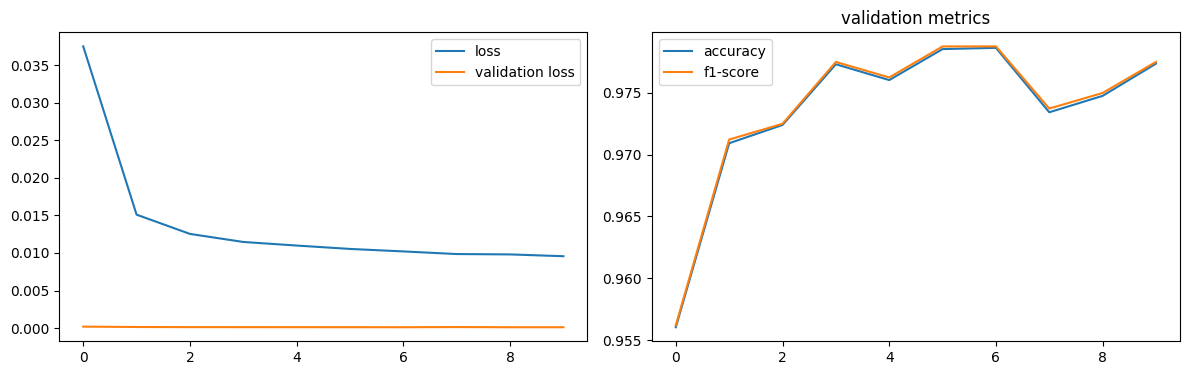

Test: loss: 0.09764858335256577, avg metrics: (0.9716115117073059, 0.9715829133987427)
dropping feature: (11, 'neuron27')


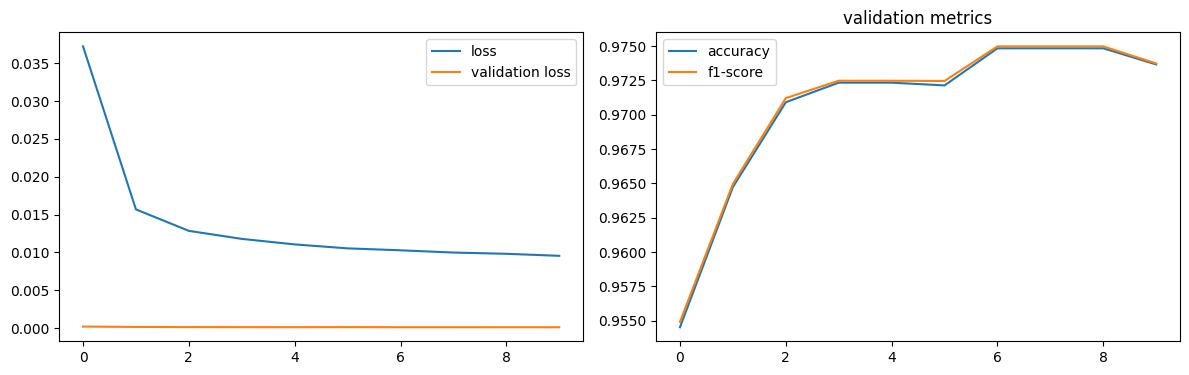

Test: loss: 0.10264204442501068, avg metrics: (0.9700064420700073, 0.9699983596801758)
dropping feature: (12, 'neuron30')


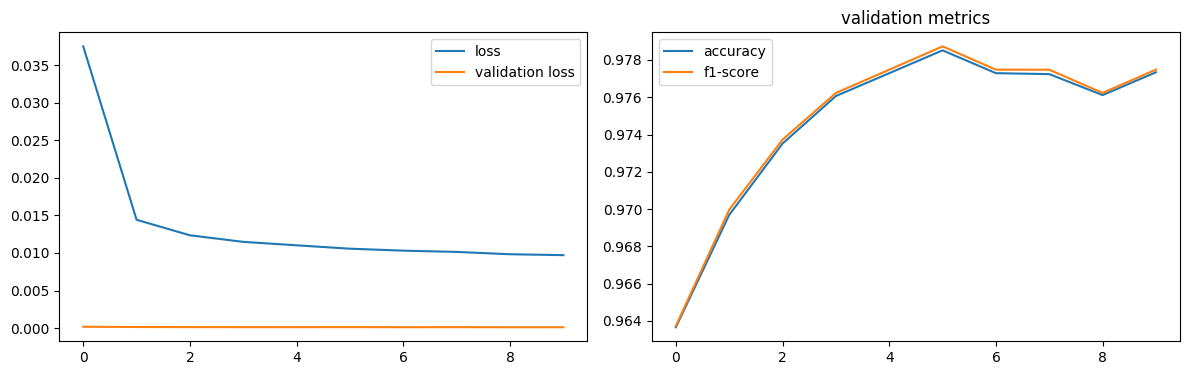

Test: loss: 0.09984170645475388, avg metrics: (0.9700836539268494, 0.9700815677642822)
dropping feature: (4, 'neuron11')


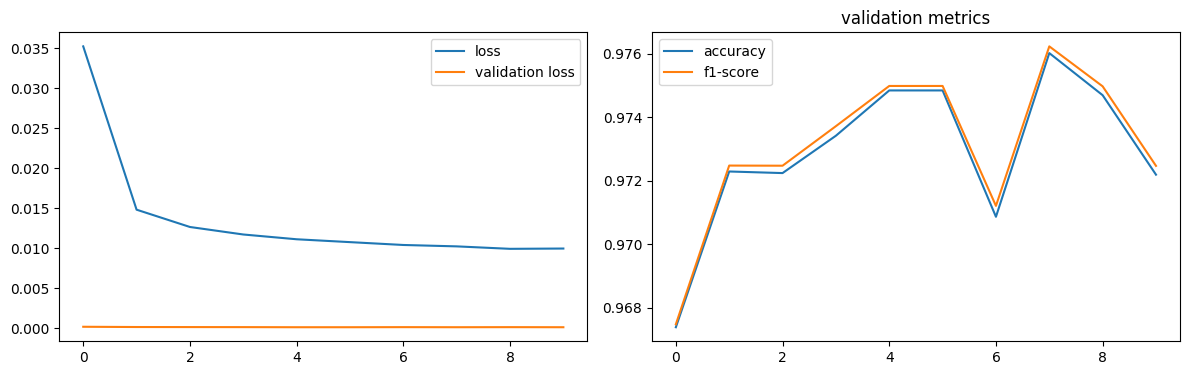

Test: loss: 0.10160712897777557, avg metrics: (0.9690947651863098, 0.969082486629486)
dropping feature: (2, 'neuron6')


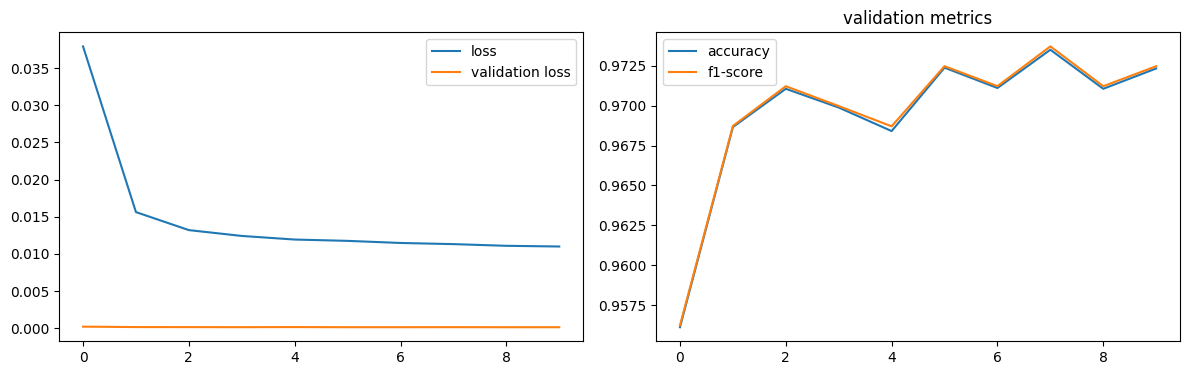

Test: loss: 0.11019577085971832, avg metrics: (0.9680824756622315, 0.9680818676948547)
dropping feature: (5, 'neuron20')


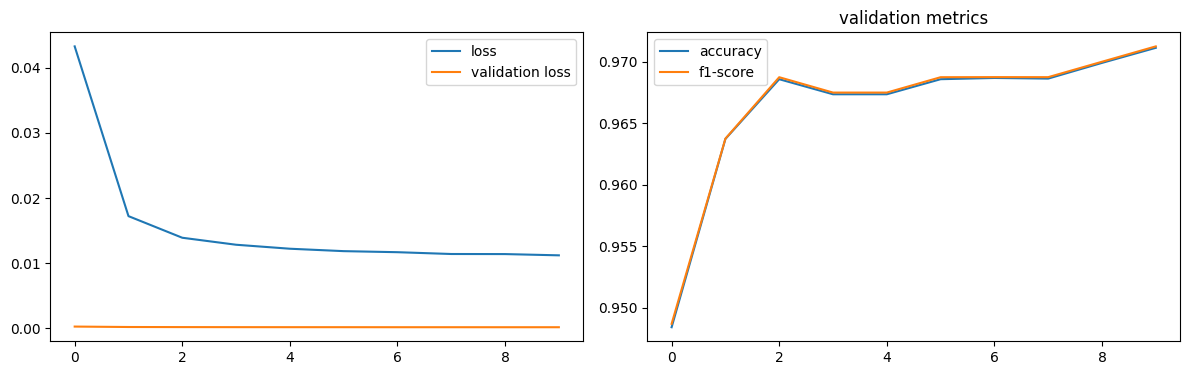

Test: loss: 0.10936359316110611, avg metrics: (0.9654279112815857, 0.965415358543396)
dropping feature: (5, 'neuron22')


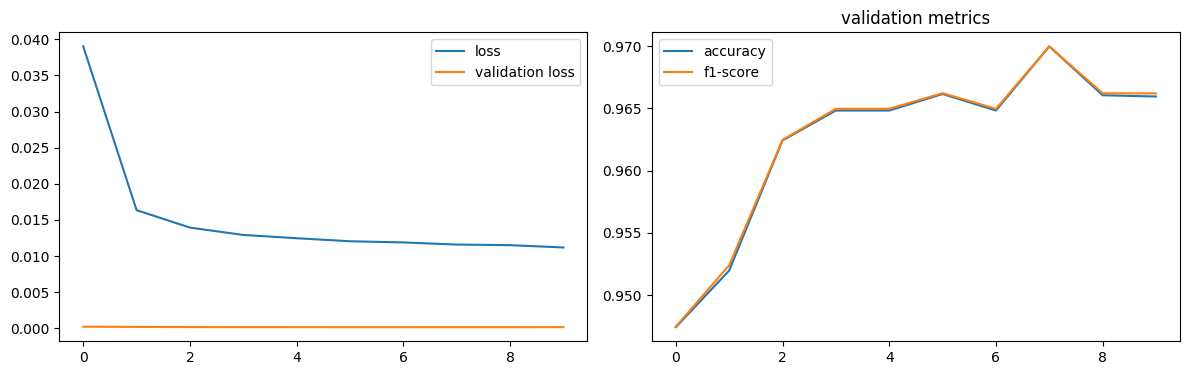

Test: loss: 0.11363491415977478, avg metrics: (0.9650990009307862, 0.9650821208953857)
dropping feature: (3, 'neuron12')


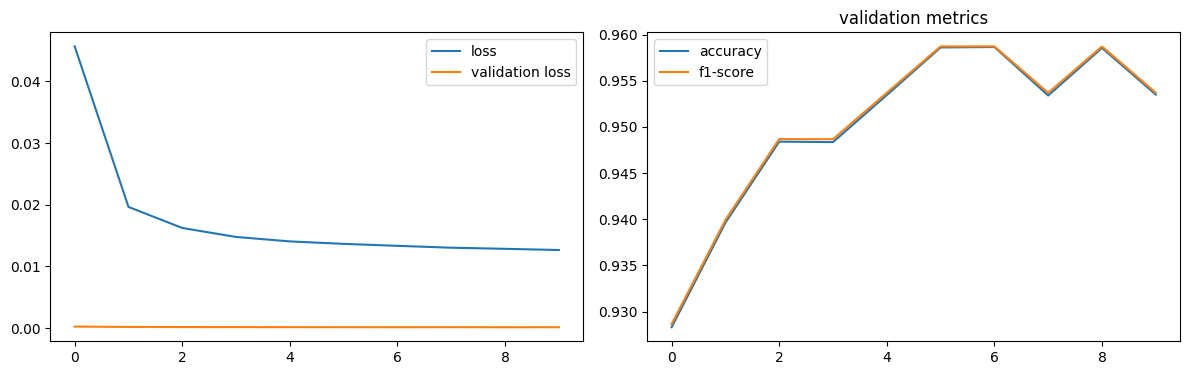

Test: loss: 0.11864329129457474, avg metrics: (0.9639289617538452, 0.9639153242111206)
dropping feature: (4, 'neuron25')


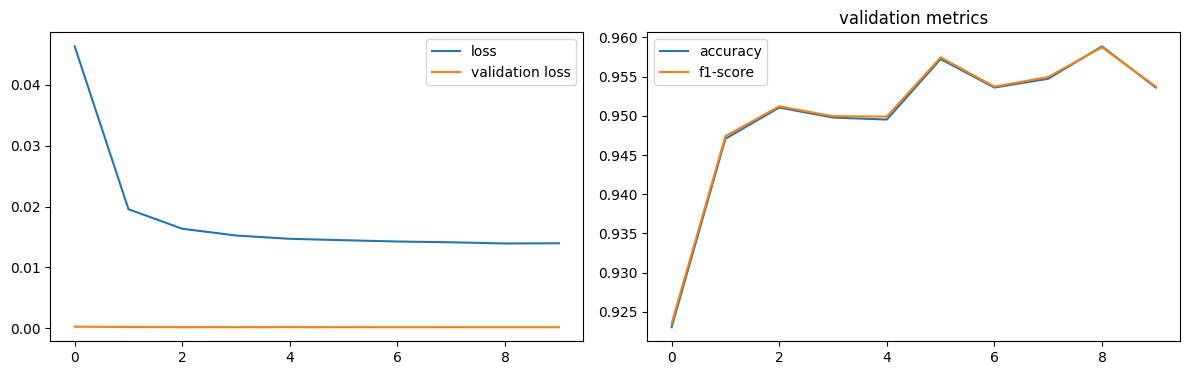

Test: loss: 0.12729890644550323, avg metrics: (0.9615932941436768, 0.9615817070007324)
dropping feature: (4, 'neuron26')


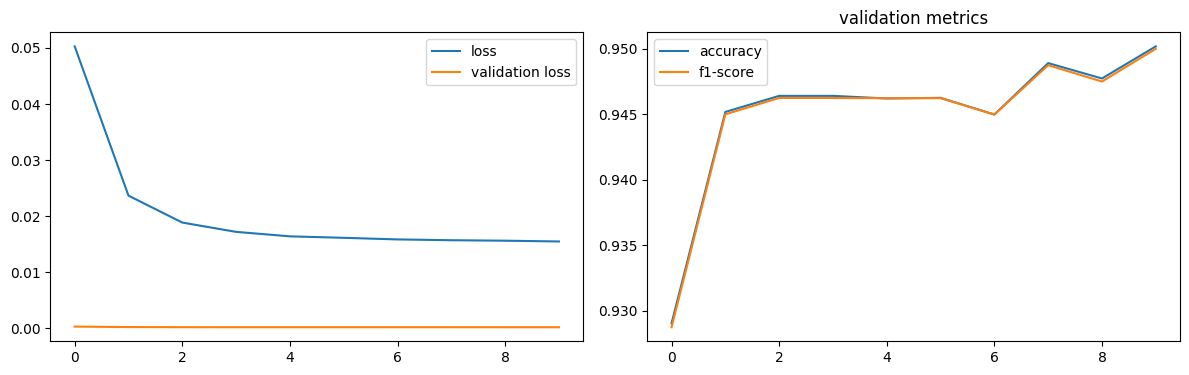

Test: loss: 0.13549193739891052, avg metrics: (0.9544507622718811, 0.9544154167175293)
dropping feature: (4, 'neuron28')


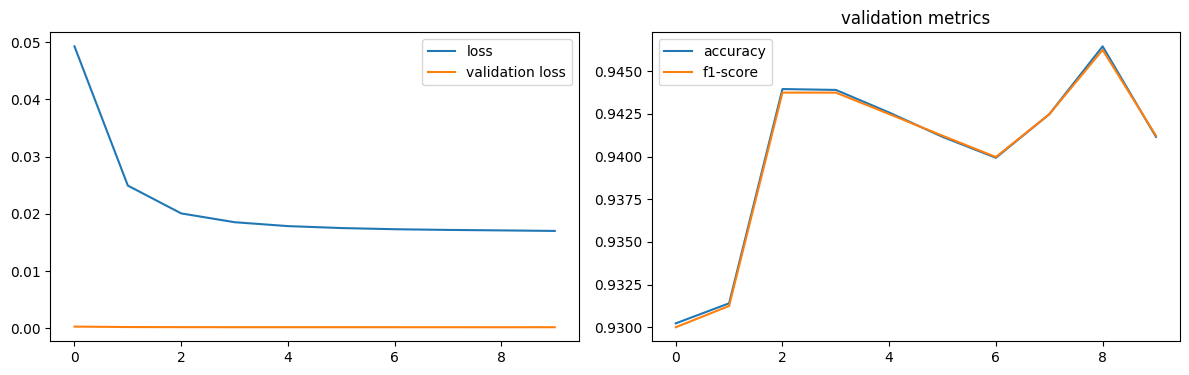

Test: loss: 0.14440007507801056, avg metrics: (0.9510367155075073, 0.9509983539581299)
dropping feature: (1, 'neuron1')


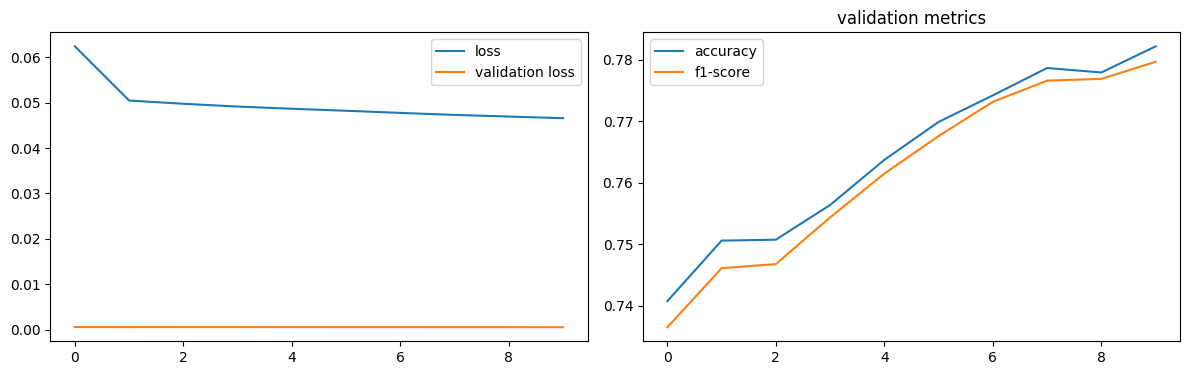

Test: loss: 0.3658914566040039, avg metrics: (0.7904773473739624, 0.7874253034591675)
dropping feature: (0, 'neuron0')


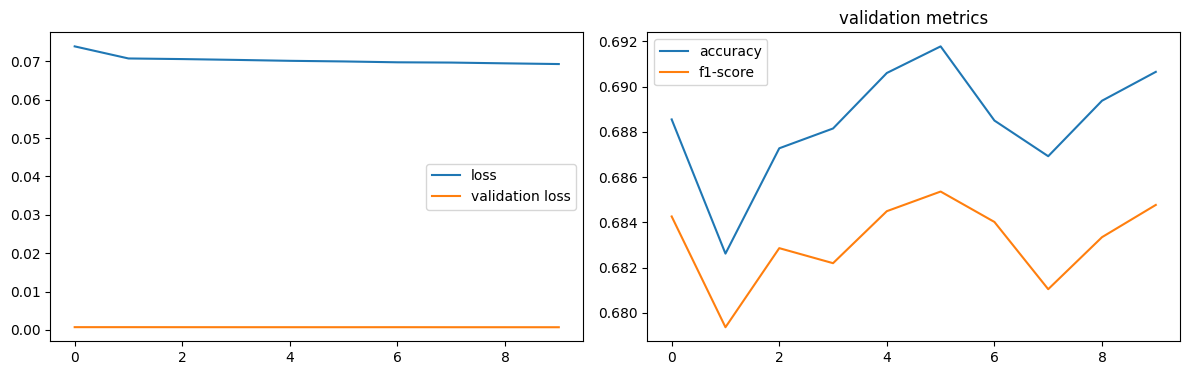

Test: loss: 0.5659323334693909, avg metrics: (0.7086064934730529, 0.7027710556983948)
dropping feature: (1, 'neuron14')


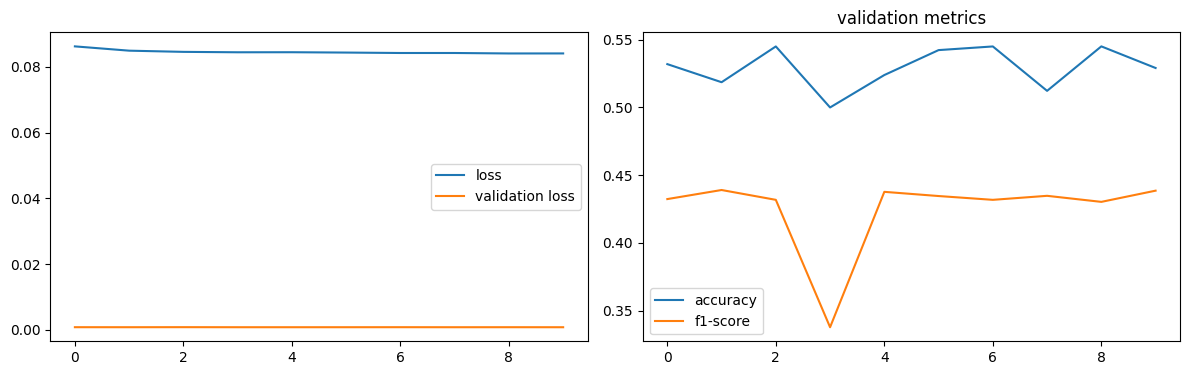

Test: loss: 0.6735349297523499, avg metrics: (0.5373861193656921, 0.42906726598739625)


In [31]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(32)]

def model_factory(size):
    model = MLP(1, (size, 32), 2)
    model.layer1 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_fast,
    model_factory, optimizer_factory, criterion, score_outputs, 10,
    labels, "", None
)

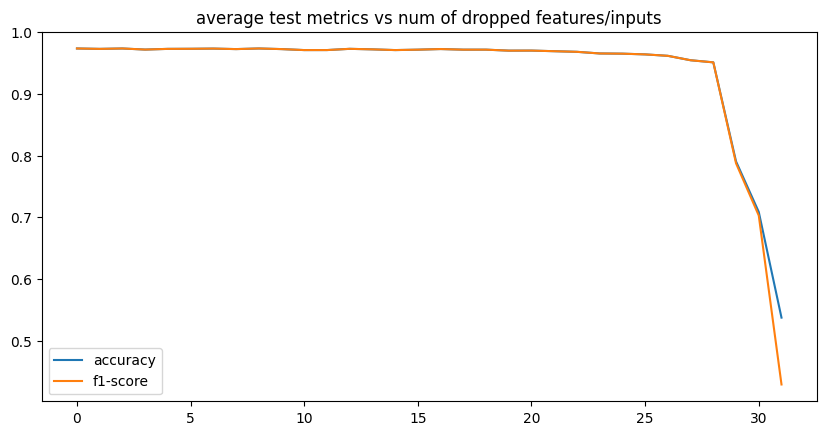

In [32]:
plot_dropping_metrics(test_metrics, labels)

In [33]:
num_drop_neurons = 28

save_models("banana", "fast-layer2", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].layer2

best_model.layer2 = layer
best_model.layer1[0] = reduce_linear(best_model.layer1[0], dropped, num_drop_neurons)

features left [4]:  ['neuron0', 'neuron1', 'neuron7', 'neuron14']


### 2nd hidden layer

In [34]:
layer.eval()

datasets = {
    key: TensorDataset(
        layer(dataset.tensors[0]).detach(),
        dataset.tensors[1]
    )
    for key, dataset in reduced_datasets.items()
}

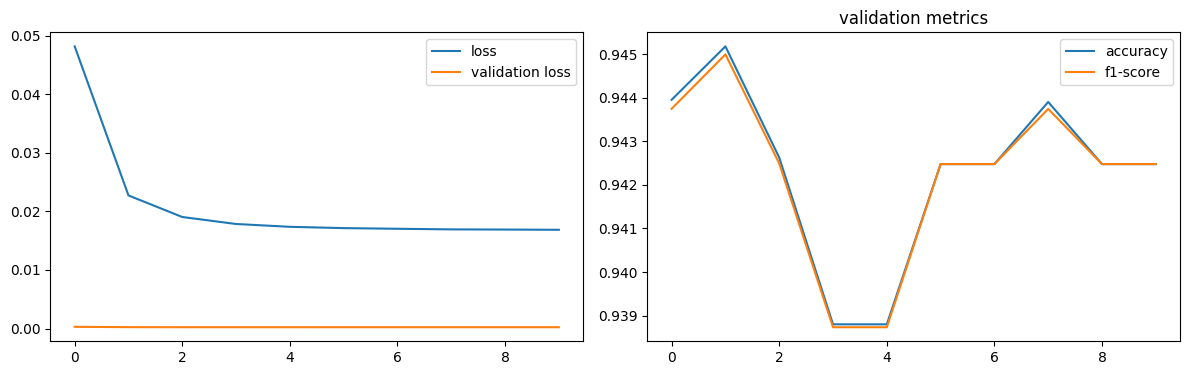

Test: loss: 0.14275623857975006, avg metrics: (0.9499727725982666, 0.9499155759811402)
dropping feature: (27, 'neuron27')


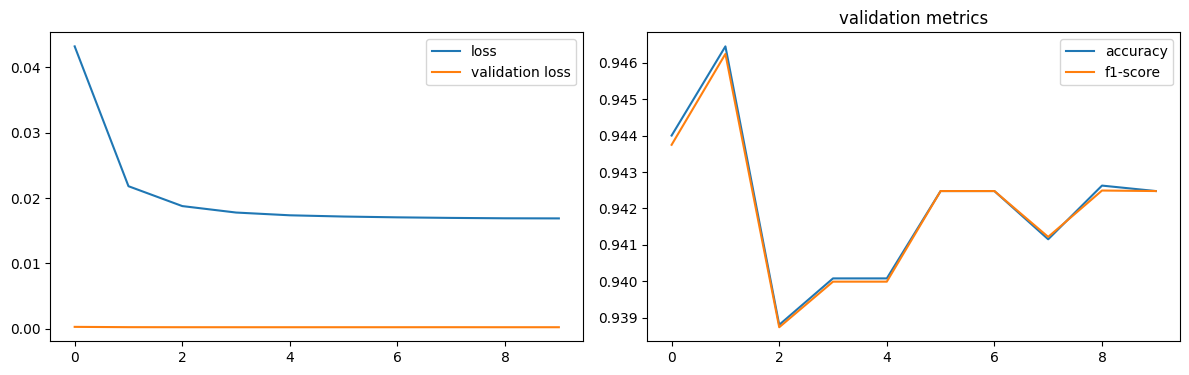

Test: loss: 0.14322040975093842, avg metrics: (0.9502100229263306, 0.950166642665863)
dropping feature: (29, 'neuron30')


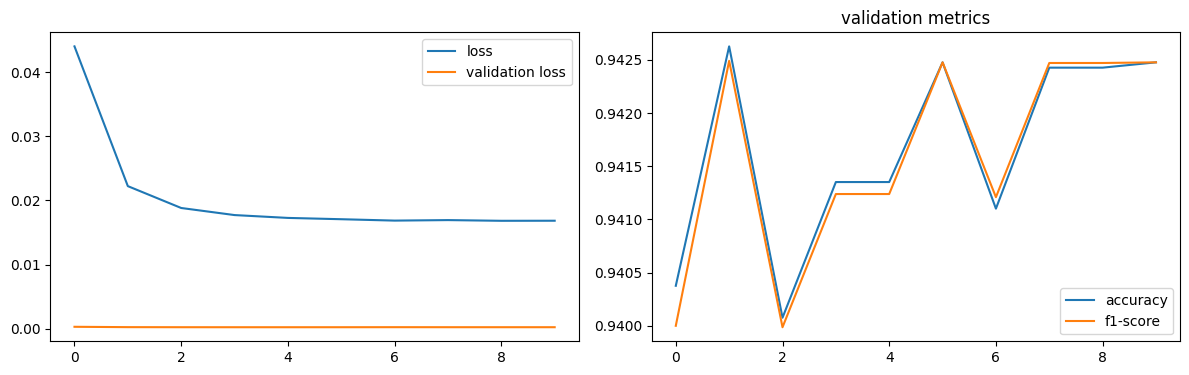

Test: loss: 0.14235839247703552, avg metrics: (0.950130558013916, 0.9500828981399536)
dropping feature: (17, 'neuron17')


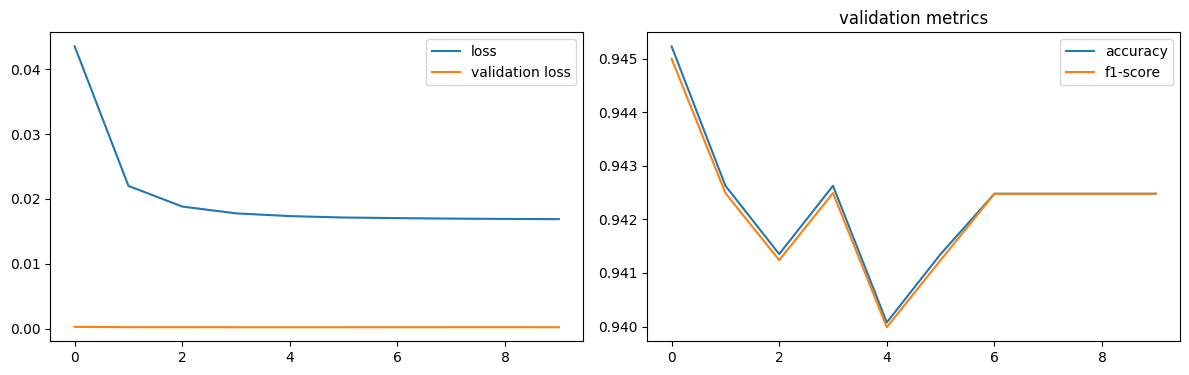

Test: loss: 0.1424713432788849, avg metrics: (0.9488149404525756, 0.9487491488456726)
dropping feature: (12, 'neuron12')


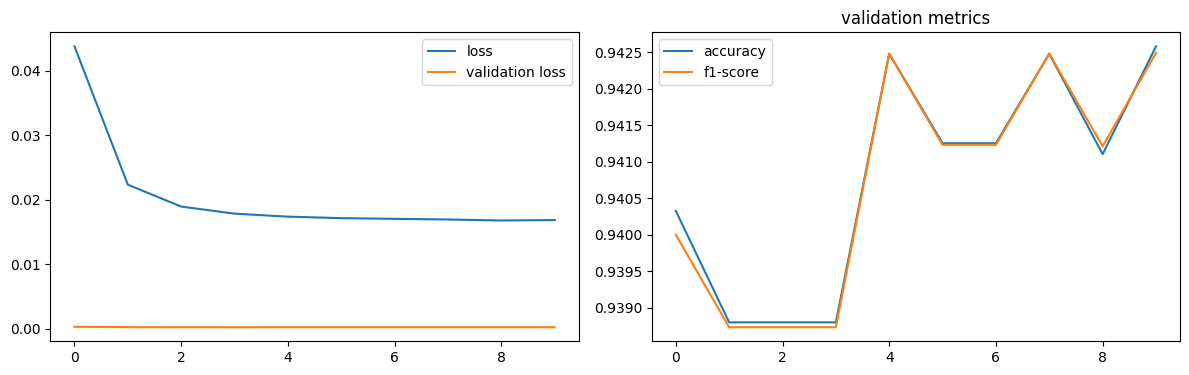

Test: loss: 0.14315766096115112, avg metrics: (0.94981609582901, 0.9497486352920532)
dropping feature: (19, 'neuron21')


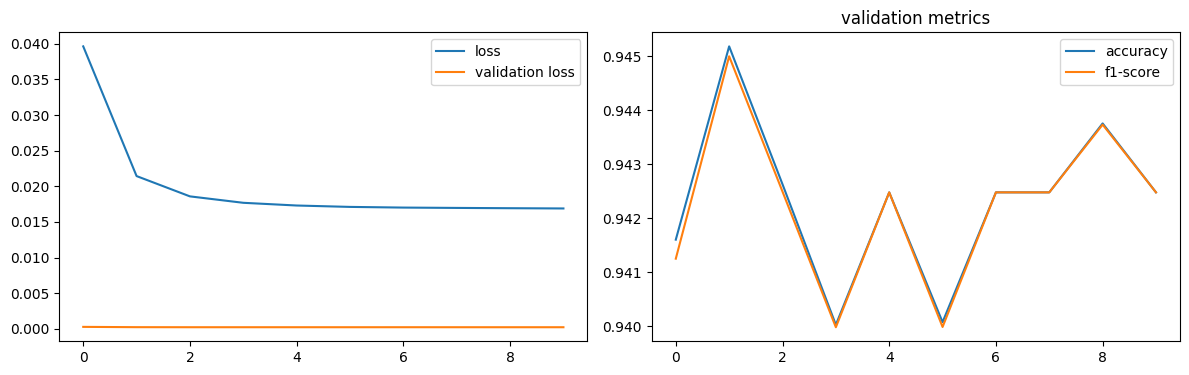

Test: loss: 0.14258775115013123, avg metrics: (0.9487410426139832, 0.9486653566360473)
dropping feature: (16, 'neuron18')


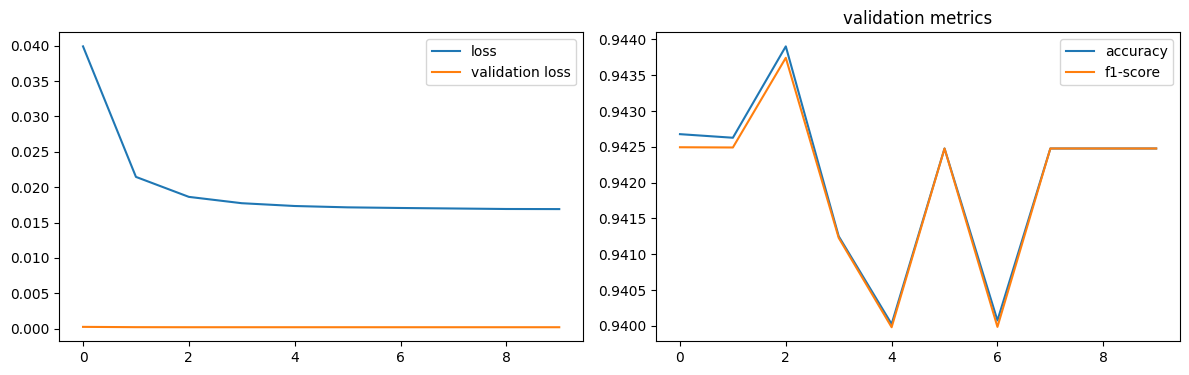

Test: loss: 0.14294315874576569, avg metrics: (0.94988112449646, 0.9498329520225525)
dropping feature: (14, 'neuron15')


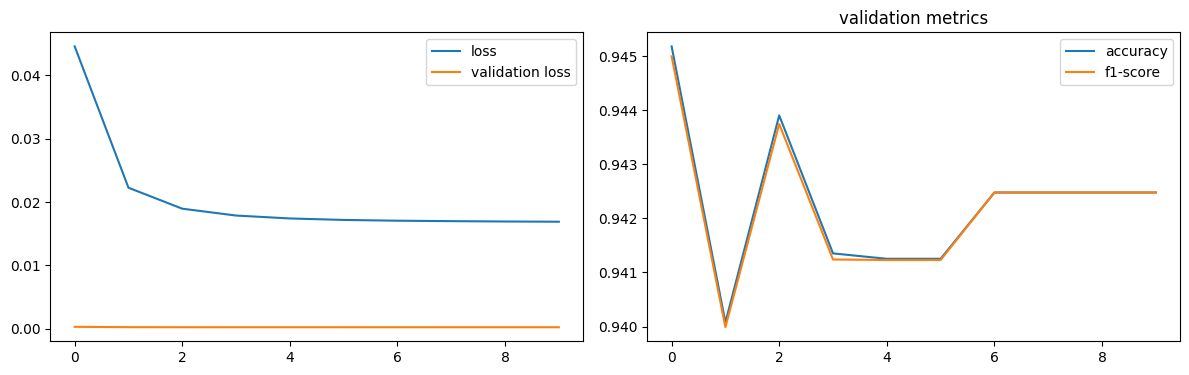

Test: loss: 0.14265118539333344, avg metrics: (0.9487410664558411, 0.9486652374267578)
dropping feature: (7, 'neuron7')


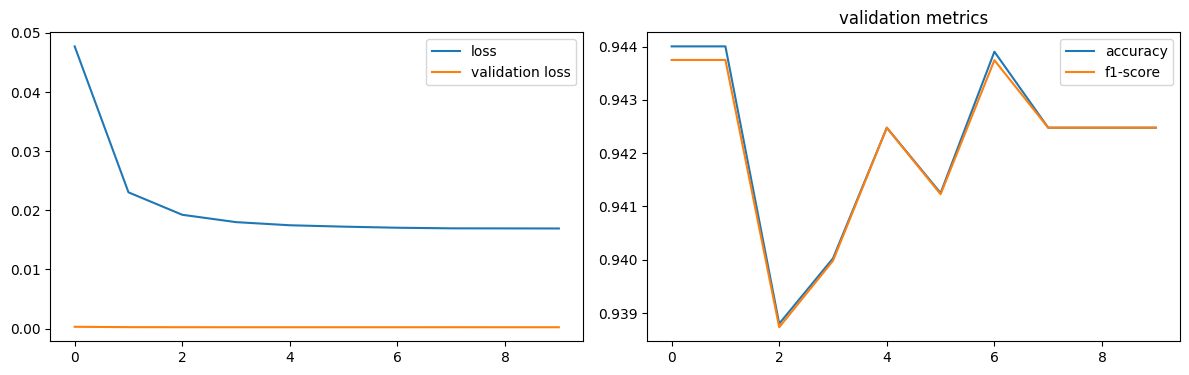

Test: loss: 0.14264172315597534, avg metrics: (0.9489738345146179, 0.9489161610603333)
dropping feature: (20, 'neuron26')


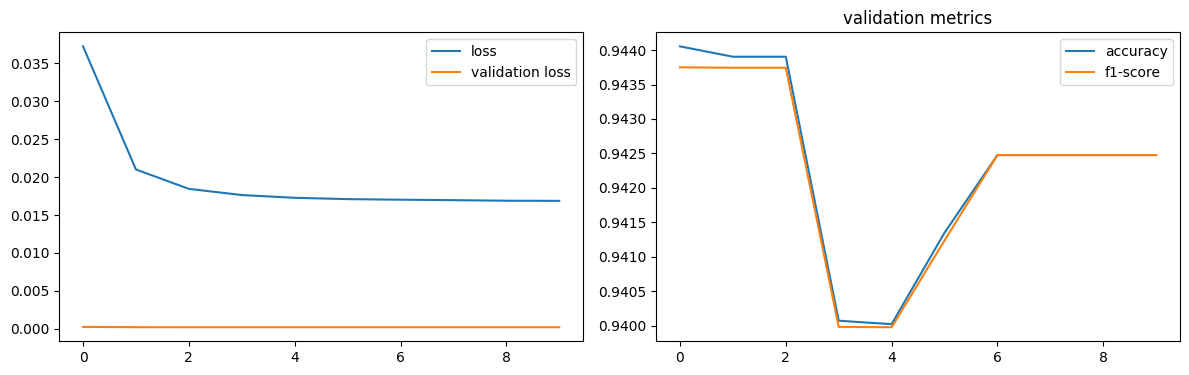

Test: loss: 0.14233916997909546, avg metrics: (0.9487421870231628, 0.9486647129058838)
dropping feature: (0, 'neuron0')


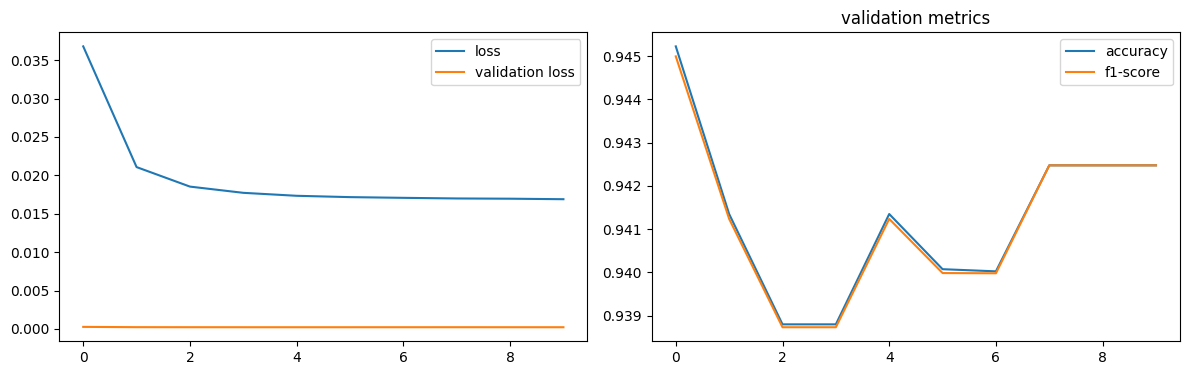

Test: loss: 0.14299391210079193, avg metrics: (0.9490721821784973, 0.9489986419677734)
dropping feature: (7, 'neuron9')


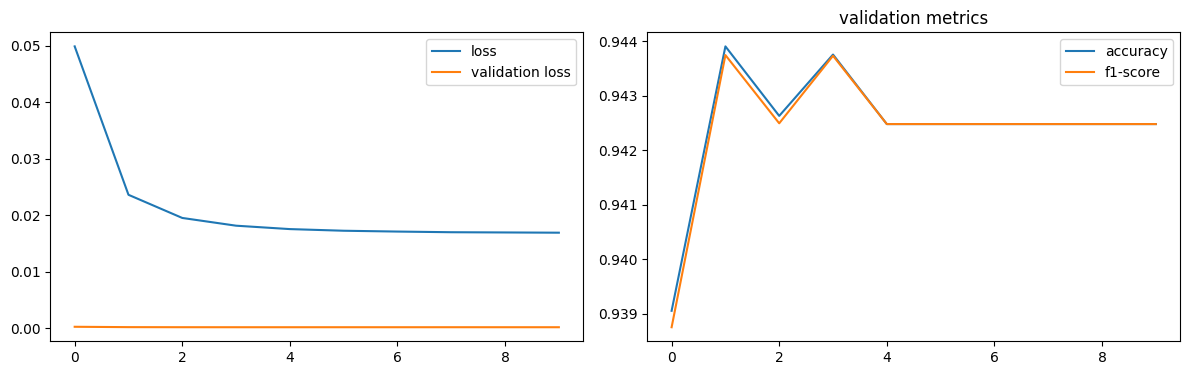

Test: loss: 0.14301562309265137, avg metrics: (0.9484132647514343, 0.9483314037322998)
dropping feature: (1, 'neuron2')


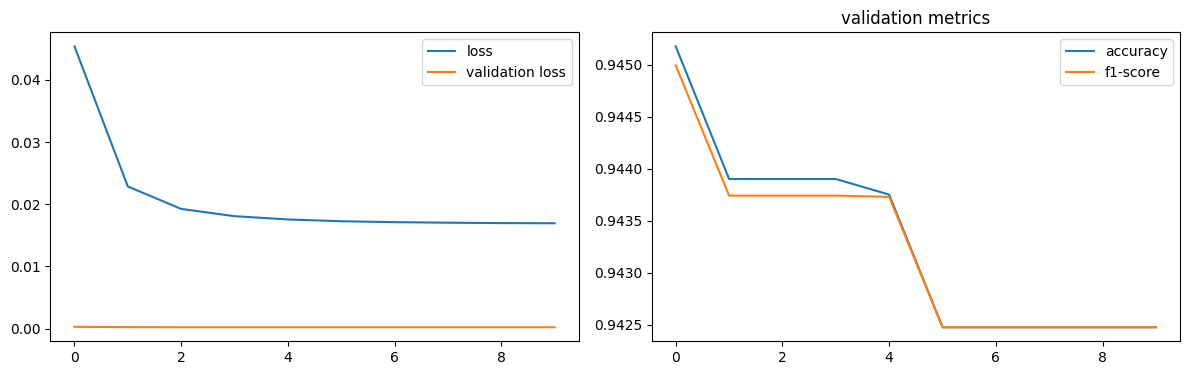

Test: loss: 0.14292387664318085, avg metrics: (0.9484143733978272, 0.9483310580253601)
dropping feature: (3, 'neuron5')


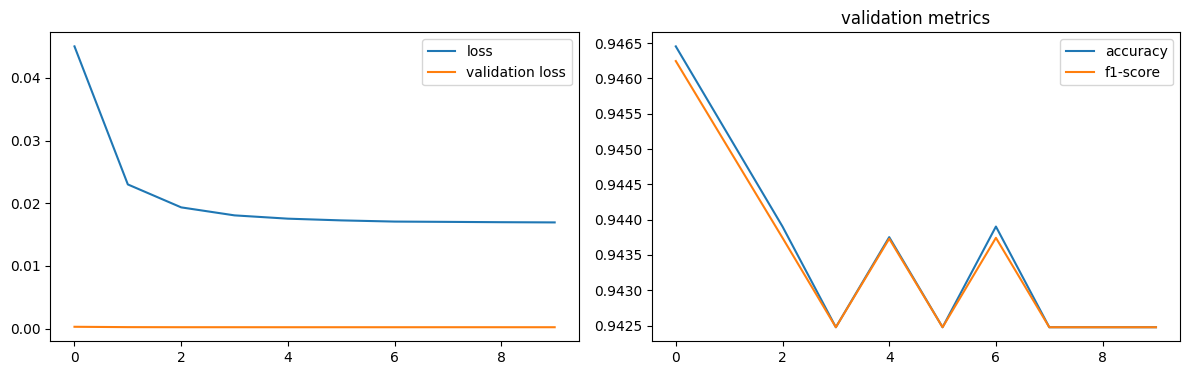

Test: loss: 0.14276614785194397, avg metrics: (0.9488932847976684, 0.9488325476646423)
dropping feature: (15, 'neuron25')


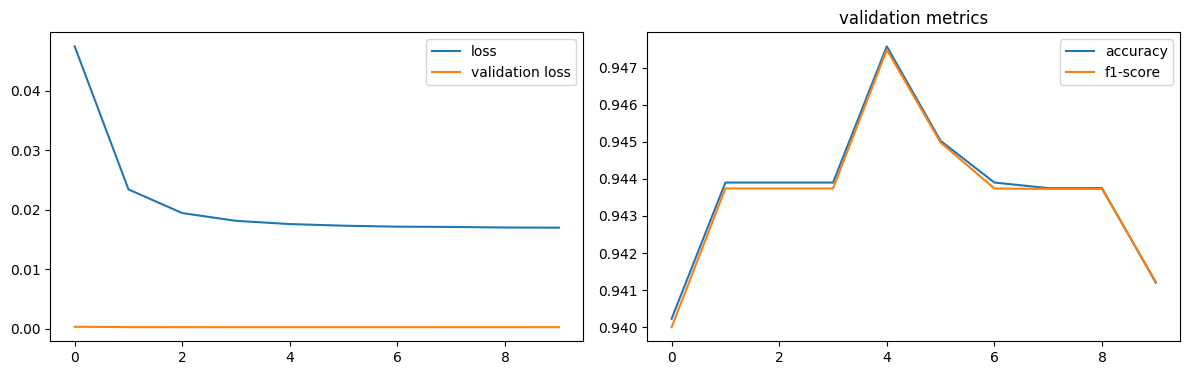

Test: loss: 0.14369645714759827, avg metrics: (0.9488271951675415, 0.9487484097480774)
dropping feature: (15, 'neuron28')


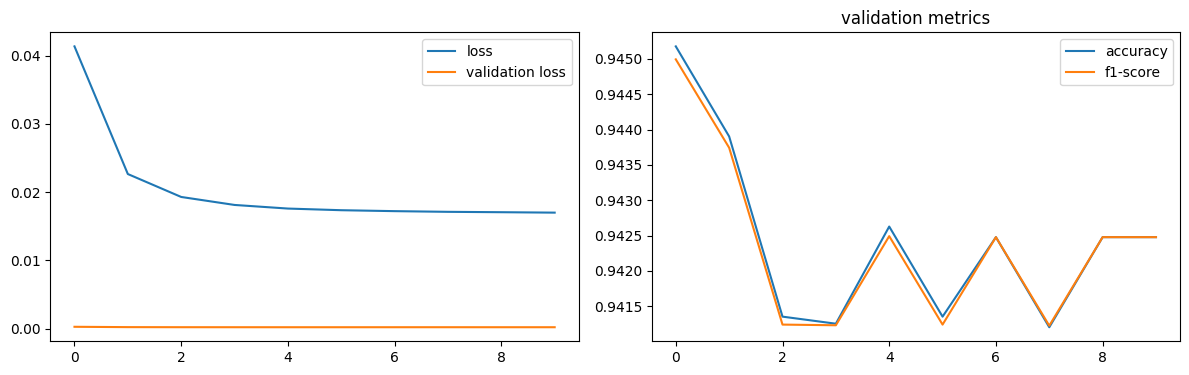

Test: loss: 0.14390985667705536, avg metrics: (0.9487366199493408, 0.9486654043197632)
dropping feature: (16, 'neuron31')


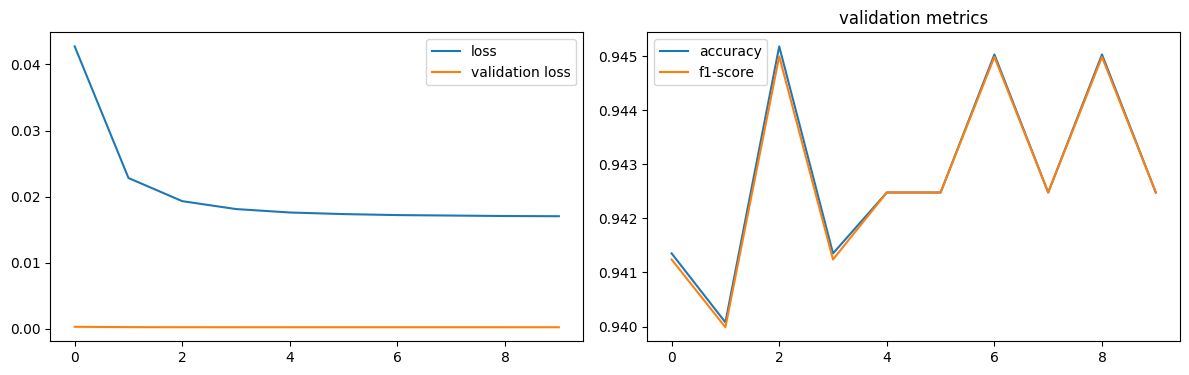

Test: loss: 0.14421458542346954, avg metrics: (0.9488138437271119, 0.9487493753433227)
dropping feature: (2, 'neuron4')


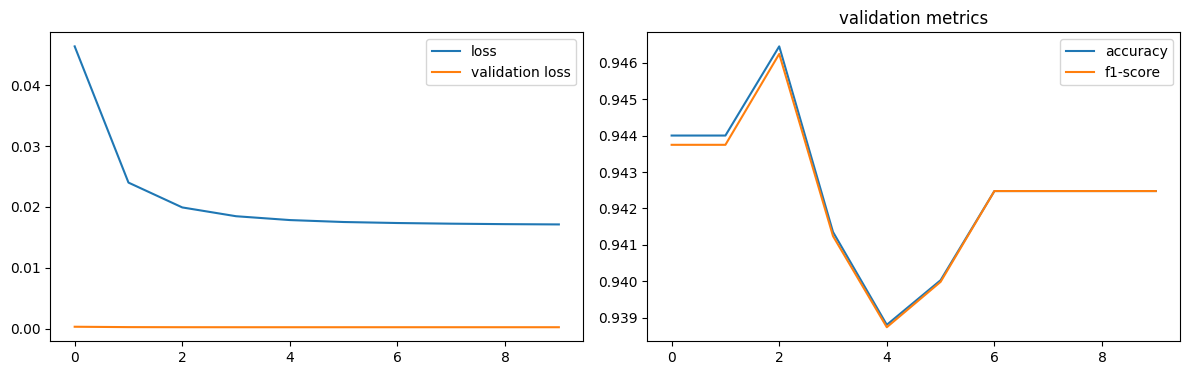

Test: loss: 0.14545652270317078, avg metrics: (0.947074294090271, 0.9469985961914062)
dropping feature: (1, 'neuron3')


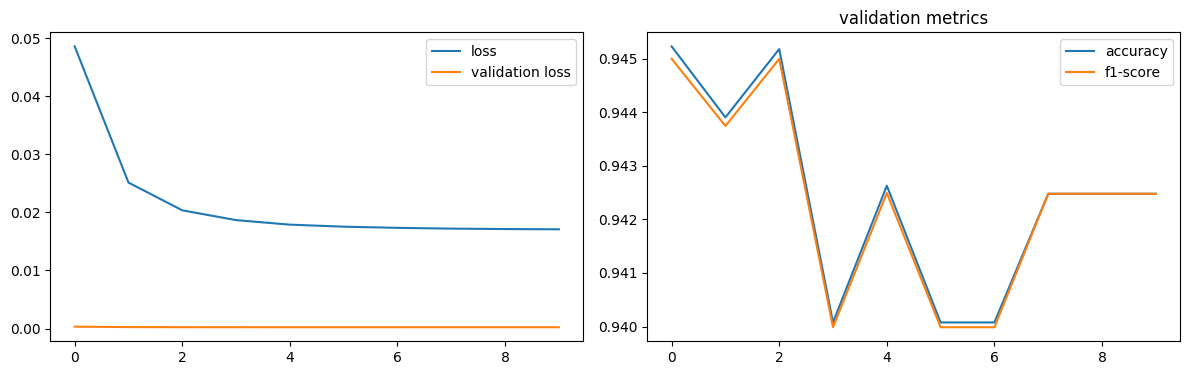

Test: loss: 0.14479677379131317, avg metrics: (0.9476626515388489, 0.9475815057754516)
dropping feature: (5, 'neuron13')


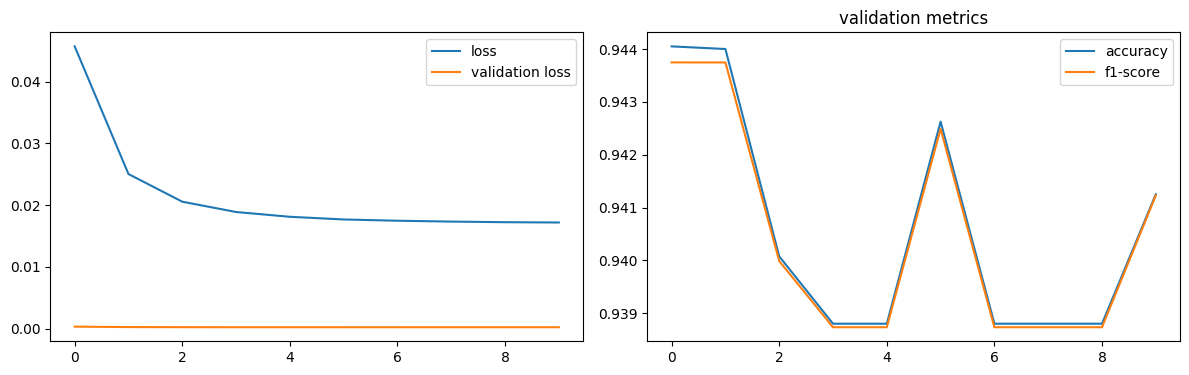

Test: loss: 0.14572234451770782, avg metrics: (0.9476471185684204, 0.947582733631134)
dropping feature: (6, 'neuron16')


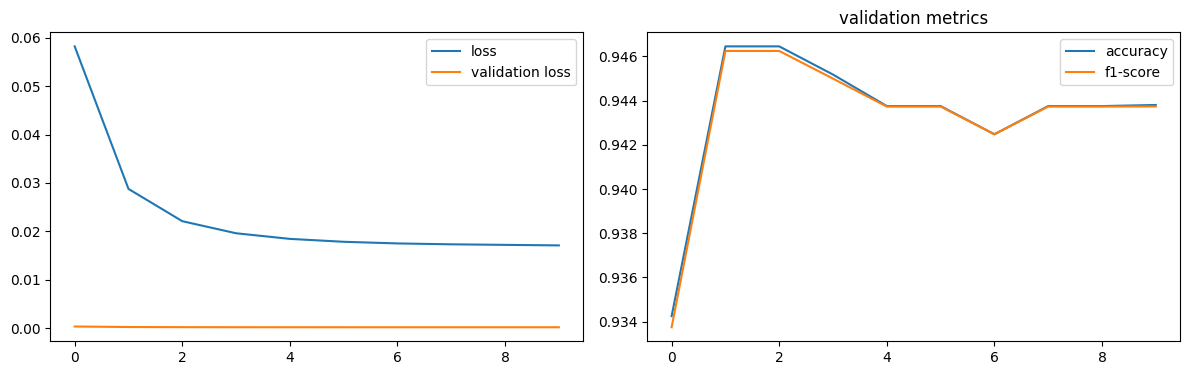

Test: loss: 0.14507408440113068, avg metrics: (0.9479121446609498, 0.9478315234184265)
dropping feature: (4, 'neuron11')


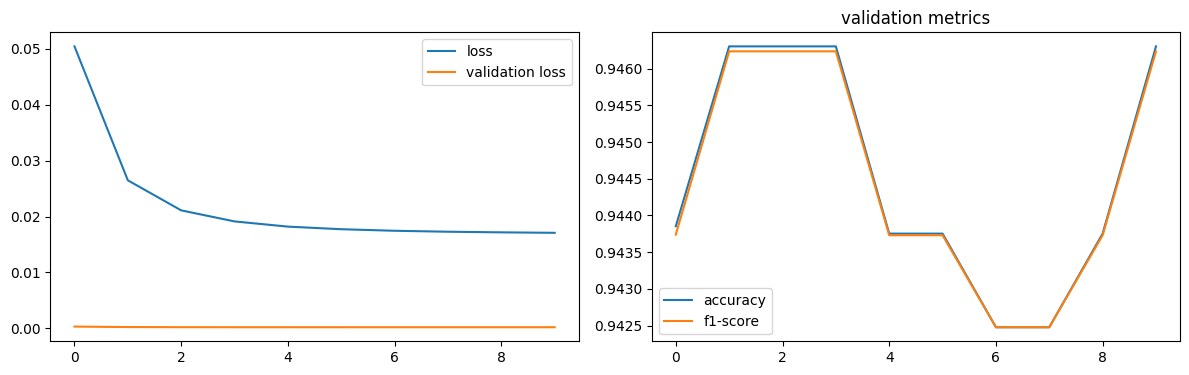

Test: loss: 0.14501428604125977, avg metrics: (0.9494177341461182, 0.9493312239646912)
dropping feature: (5, 'neuron19')


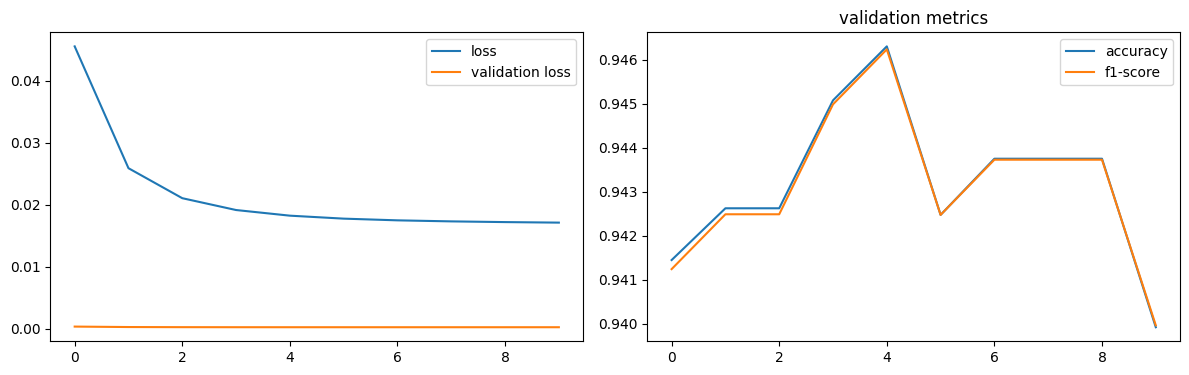

Test: loss: 0.14455534517765045, avg metrics: (0.9481671452522278, 0.9480811595916748)
dropping feature: (9, 'neuron29')


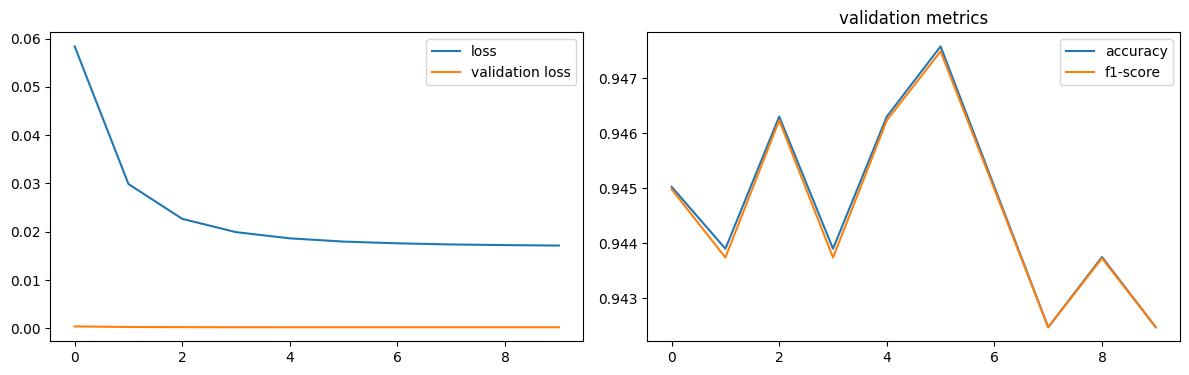

Test: loss: 0.14502599835395813, avg metrics: (0.9479210138320923, 0.9478308320045471)
dropping feature: (5, 'neuron20')


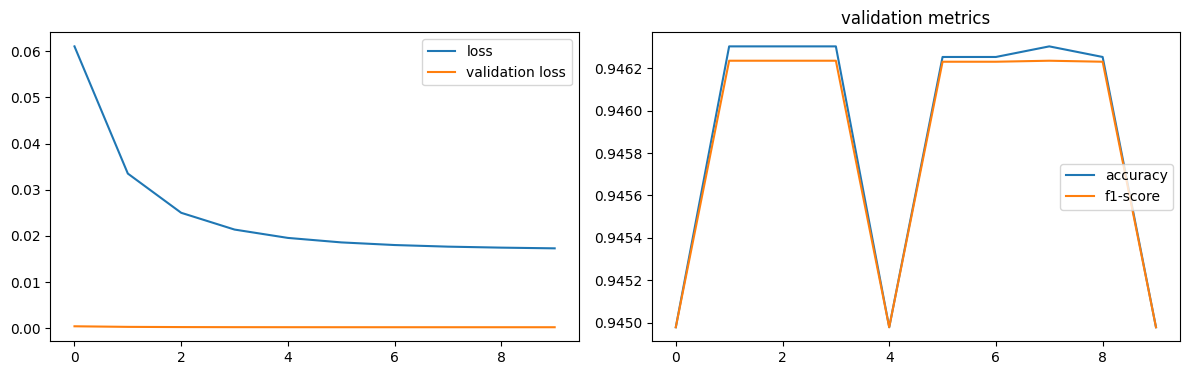

Test: loss: 0.14575886726379395, avg metrics: (0.9488327264785766, 0.9487478971481323)
dropping feature: (4, 'neuron14')


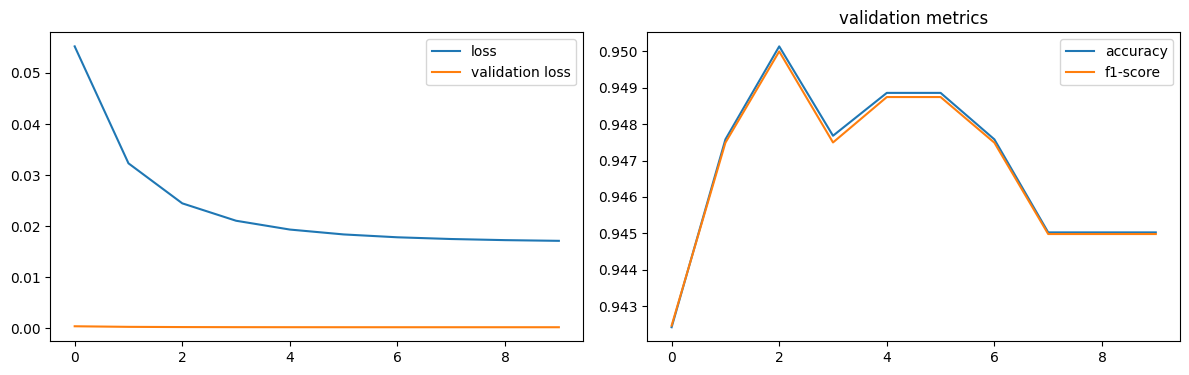

Test: loss: 0.1445302516222, avg metrics: (0.9495855331420898, 0.9494978189468384)
dropping feature: (4, 'neuron22')


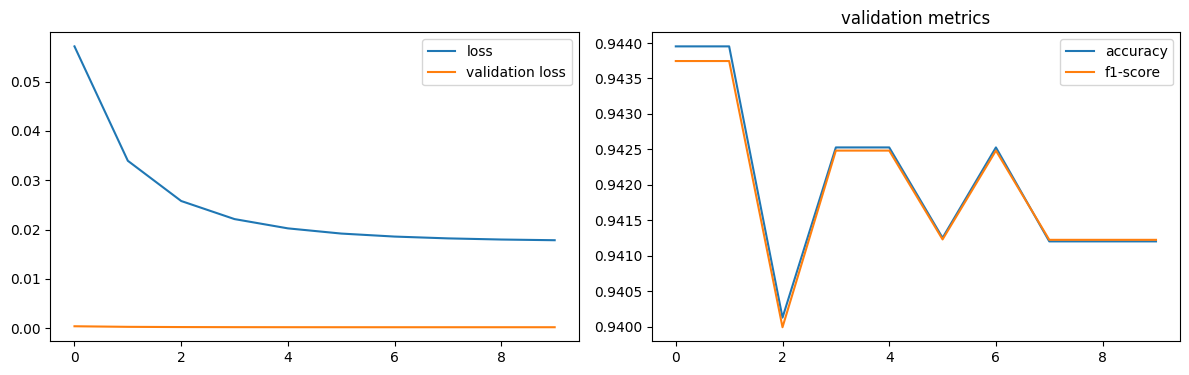

Test: loss: 0.15140455961227417, avg metrics: (0.944824755191803, 0.9447485923767089)
dropping feature: (1, 'neuron6')


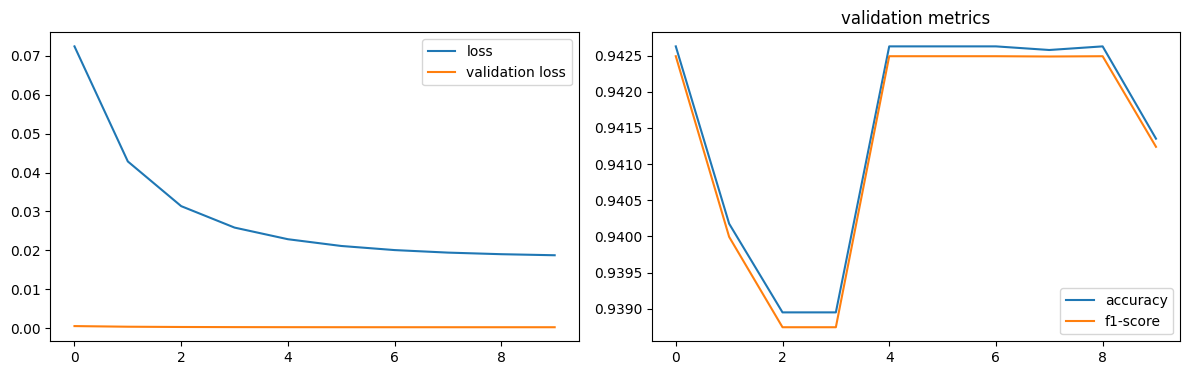

Test: loss: 0.15670020878314972, avg metrics: (0.9470665454864502, 0.9469992876052856)
dropping feature: (2, 'neuron10')


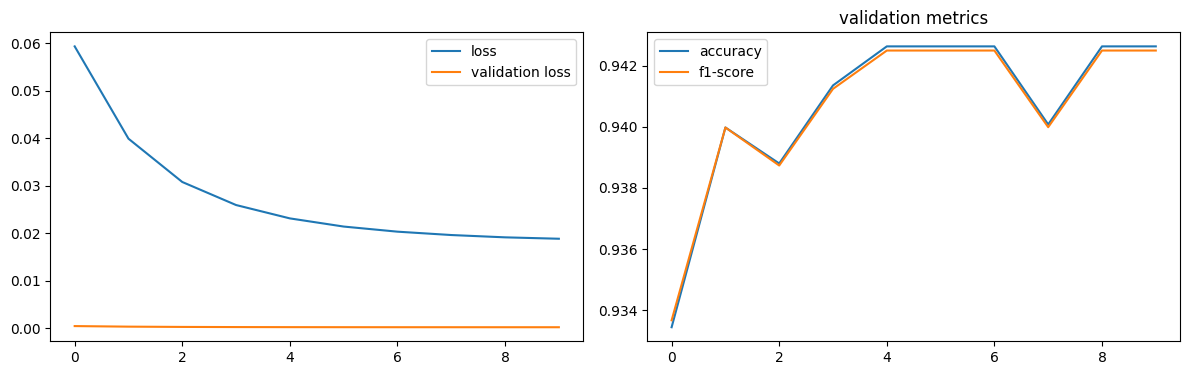

Test: loss: 0.1583639681339264, avg metrics: (0.9465731859207154, 0.9464987993240357)
dropping feature: (3, 'neuron24')


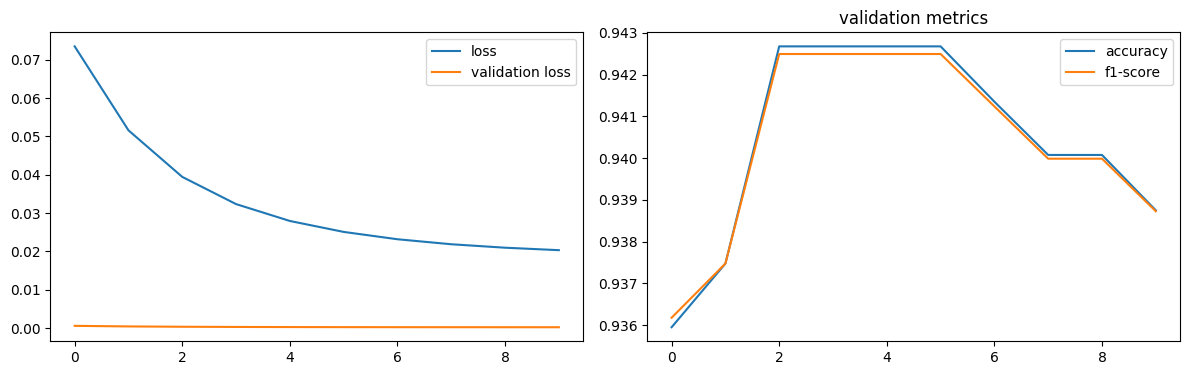

Test: loss: 0.16884063184261322, avg metrics: (0.9416623950004578, 0.941581392288208)
dropping feature: (1, 'neuron8')


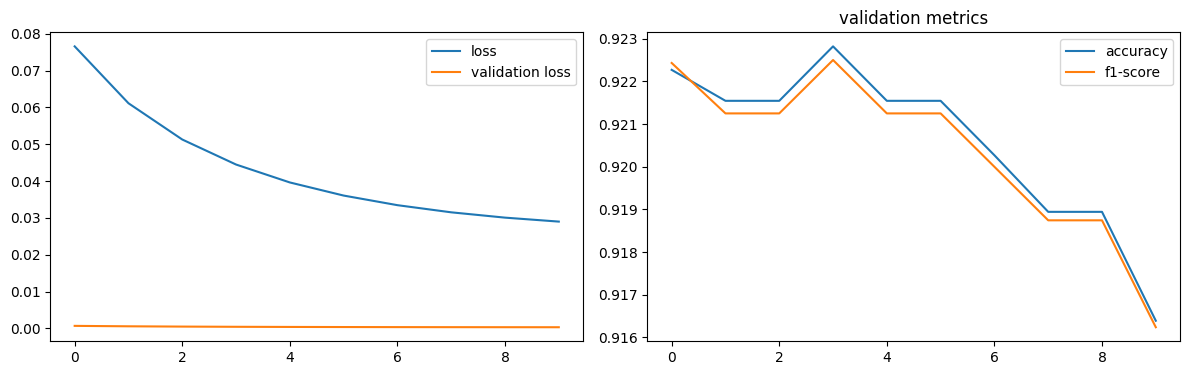

Test: loss: 0.23046094179153442, avg metrics: (0.9214437484741211, 0.9212071299552917)
dropping feature: (1, 'neuron23')


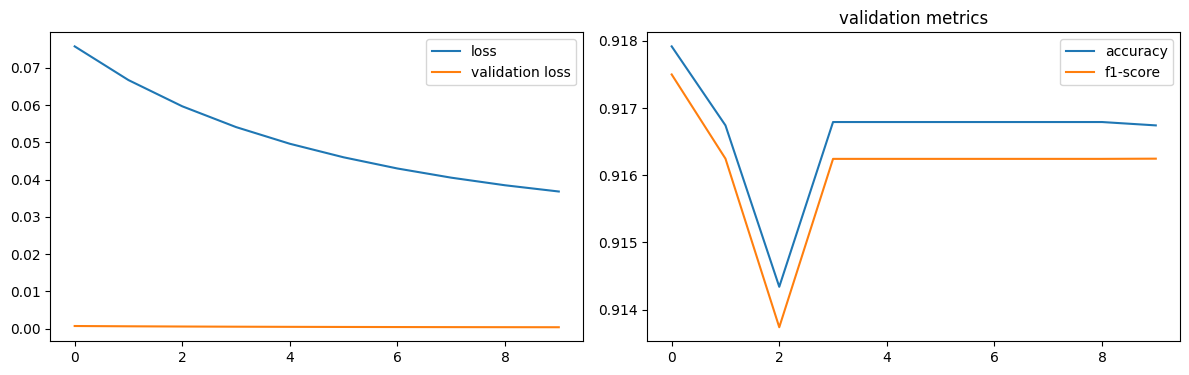

Test: loss: 0.28572356700897217, avg metrics: (0.9175907731056213, 0.9172453641891479)


In [35]:
torch.manual_seed(2024)

headers = [f"neuron{i}" for i in range(32)]


def model_factory(size):
    model = MLP(1, (1, size), 2)
    model.layer1 = nn.Identity()
    model.layer2 = nn.Identity()
    return model


test_metrics, dropped, models = prune(
    datasets, headers, analyze_dgsm,
    model_factory, optimizer_factory, criterion, score_outputs, 10,
    labels, "", None
)

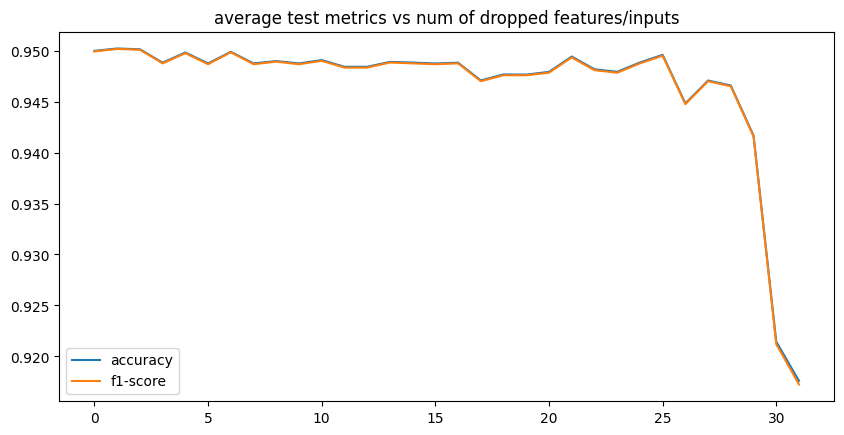

In [36]:
plot_dropping_metrics(test_metrics, labels)

In [37]:
num_drop_neurons = 25

save_models("banana", "fast-layer3", models, dropped)

reduced_datasets, reduced_headers = reduce_datasets(datasets, headers, dropped, num_drop_neurons)
layer = models[num_drop_neurons].out

best_model.out = layer
best_model.layer2[0] = reduce_linear(best_model.layer2[0], dropped, num_drop_neurons)

features left [7]:  ['neuron1', 'neuron6', 'neuron8', 'neuron10', 'neuron22', 'neuron23', 'neuron24']


### pruned

In [38]:
best_model

MLP(
  (layer1): Sequential(
    (0): Linear(in_features=6, out_features=4, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=4, out_features=7, bias=True)
    (1): ReLU()
  )
  (out): Linear(in_features=7, out_features=2, bias=True)
  (relu): ReLU()
)

In [39]:
with torch.no_grad():
    inputs, targets = fast_dataset["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test {labels}: {test_metrics}")

test ('accuracy', 'f1-score'): (0.9492533206939697, 0.9491643905639648)


test: ('accuracy', 'f1-score'): (0.960037112236023, 0.9599999785423279)


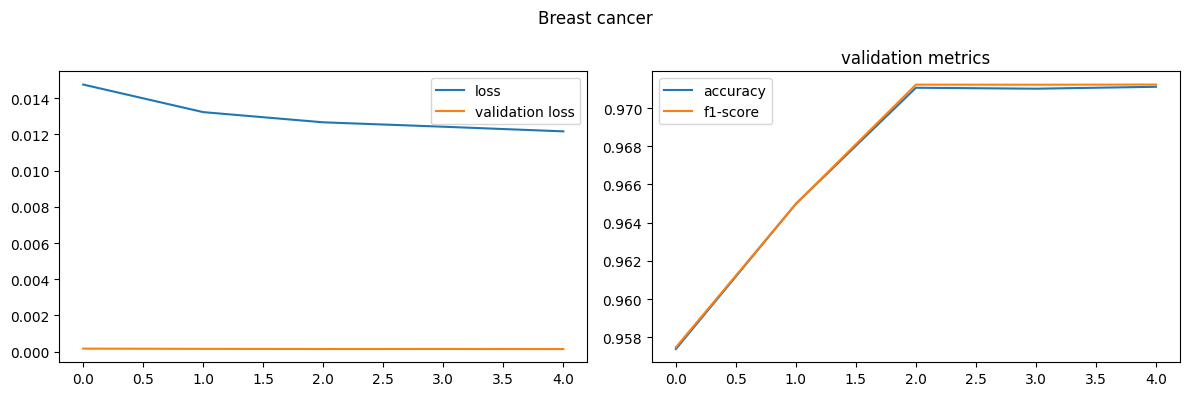

In [40]:
optimizer = optimizer_factory(best_model)
metrics = model_train(dgsm_datasets, best_model, optimizer, criterion, score_outputs, 5)

with torch.no_grad():
    inputs, targets = dgsm_datasets["test"][:]
    outputs = best_model(inputs)

    test_metrics = score_outputs(outputs, targets)

print(f"test: {labels}: {test_metrics}")
plot_metrics('Breast cancer', metrics, labels)

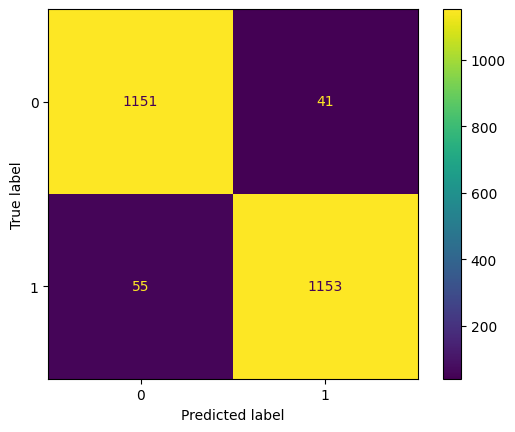

In [41]:
ConfusionMatrixDisplay.from_predictions(targets, outputs.argmax(dim=1))
plt.show()

In [42]:
save_models("banana", "fast-prunned", [best_model], None)